In [1]:
import numpy as np

import tensorflow as tf

from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import sys
import os
import tqdm

from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())

%matplotlib inline

# check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

print('Modules imported.')

C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16738989968024544838
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1682669568
locality {
  bus_id: 1
}
incarnation: 1892366527142460887
physical_device_desc: "device: 0, name: GeForce GTX 660, pci bus id: 0000:01:00.0, compute capability: 3.0"
]
Default GPU Device: /device:GPU:0
Modules imported.


## GAN

In [4]:
width = 28
height = 28
channels = 1

In [9]:
# discriminator structure
def build_discriminator():

        img_shape = (width, height, channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [20]:
# generator structure
def build_generator():

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
        model.add(Reshape((28, 28, 1)))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

In [15]:
# defining an optimizer
optimizer = Adam(0.0002, 0.5)

In [16]:
# build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [21]:
# build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              525312    
__________

In [22]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)

In [24]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [25]:
# try to discriminate generated images
valid = discriminator(img)

In [26]:
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [31]:
def train(epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(epoch)

In [36]:
def save_imgs(epoch):
        directory = "images"
        
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [39]:
train(epochs=30000, batch_size=128, save_interval=1000)

0 [D loss: 0.317552, acc.: 87.50%] [G loss: 0.943372]
1 [D loss: 0.284892, acc.: 96.88%] [G loss: 0.989026]
2 [D loss: 0.275389, acc.: 100.00%] [G loss: 1.171293]
3 [D loss: 0.240541, acc.: 100.00%] [G loss: 1.156849]
4 [D loss: 0.220103, acc.: 96.88%] [G loss: 1.388932]
5 [D loss: 0.202378, acc.: 100.00%] [G loss: 1.502640]
6 [D loss: 0.158331, acc.: 100.00%] [G loss: 1.559485]
7 [D loss: 0.133183, acc.: 100.00%] [G loss: 1.665053]
8 [D loss: 0.119655, acc.: 100.00%] [G loss: 1.897158]
9 [D loss: 0.123174, acc.: 100.00%] [G loss: 1.938442]
10 [D loss: 0.096450, acc.: 100.00%] [G loss: 2.090250]
11 [D loss: 0.092796, acc.: 100.00%] [G loss: 2.107686]
12 [D loss: 0.074870, acc.: 100.00%] [G loss: 2.325726]
13 [D loss: 0.080795, acc.: 100.00%] [G loss: 2.462733]
14 [D loss: 0.063024, acc.: 100.00%] [G loss: 2.304101]
15 [D loss: 0.064327, acc.: 100.00%] [G loss: 2.454669]
16 [D loss: 0.051524, acc.: 100.00%] [G loss: 2.532189]
17 [D loss: 0.063959, acc.: 100.00%] [G loss: 2.644046]
18 [D

292 [D loss: 0.795734, acc.: 43.75%] [G loss: 0.861573]
293 [D loss: 0.719249, acc.: 50.00%] [G loss: 0.931957]
294 [D loss: 0.596468, acc.: 62.50%] [G loss: 1.059528]
295 [D loss: 0.994263, acc.: 28.12%] [G loss: 0.592773]
296 [D loss: 0.635506, acc.: 59.38%] [G loss: 0.802891]
297 [D loss: 0.611505, acc.: 56.25%] [G loss: 0.904456]
298 [D loss: 0.668241, acc.: 59.38%] [G loss: 1.002056]
299 [D loss: 0.703174, acc.: 59.38%] [G loss: 0.879872]
300 [D loss: 0.647926, acc.: 62.50%] [G loss: 0.921656]
301 [D loss: 0.742926, acc.: 43.75%] [G loss: 0.904735]
302 [D loss: 0.731528, acc.: 40.62%] [G loss: 0.791151]
303 [D loss: 0.699430, acc.: 50.00%] [G loss: 0.966684]
304 [D loss: 0.737803, acc.: 43.75%] [G loss: 0.913870]
305 [D loss: 0.735252, acc.: 46.88%] [G loss: 0.875846]
306 [D loss: 0.741453, acc.: 43.75%] [G loss: 0.859358]
307 [D loss: 0.803064, acc.: 43.75%] [G loss: 0.637810]
308 [D loss: 0.683924, acc.: 56.25%] [G loss: 0.861553]
309 [D loss: 0.784469, acc.: 37.50%] [G loss: 0.

584 [D loss: 0.656751, acc.: 53.12%] [G loss: 0.733206]
585 [D loss: 0.638132, acc.: 71.88%] [G loss: 0.736305]
586 [D loss: 0.632661, acc.: 65.62%] [G loss: 0.721862]
587 [D loss: 0.664592, acc.: 56.25%] [G loss: 0.743012]
588 [D loss: 0.623258, acc.: 65.62%] [G loss: 0.764604]
589 [D loss: 0.641840, acc.: 56.25%] [G loss: 0.756719]
590 [D loss: 0.678128, acc.: 46.88%] [G loss: 0.747260]
591 [D loss: 0.614263, acc.: 59.38%] [G loss: 0.744490]
592 [D loss: 0.657529, acc.: 53.12%] [G loss: 0.757817]
593 [D loss: 0.644278, acc.: 56.25%] [G loss: 0.739635]
594 [D loss: 0.641692, acc.: 53.12%] [G loss: 0.750298]
595 [D loss: 0.625047, acc.: 62.50%] [G loss: 0.757375]
596 [D loss: 0.638241, acc.: 65.62%] [G loss: 0.742961]
597 [D loss: 0.625888, acc.: 65.62%] [G loss: 0.735091]
598 [D loss: 0.633177, acc.: 62.50%] [G loss: 0.733919]
599 [D loss: 0.651861, acc.: 53.12%] [G loss: 0.740412]
600 [D loss: 0.619112, acc.: 56.25%] [G loss: 0.751866]
601 [D loss: 0.673422, acc.: 62.50%] [G loss: 0.

876 [D loss: 0.663833, acc.: 46.88%] [G loss: 0.791256]
877 [D loss: 0.636550, acc.: 59.38%] [G loss: 0.768892]
878 [D loss: 0.612566, acc.: 68.75%] [G loss: 0.784220]
879 [D loss: 0.601025, acc.: 78.12%] [G loss: 0.809942]
880 [D loss: 0.618825, acc.: 65.62%] [G loss: 0.800527]
881 [D loss: 0.656561, acc.: 62.50%] [G loss: 0.843786]
882 [D loss: 0.599875, acc.: 68.75%] [G loss: 0.823065]
883 [D loss: 0.610983, acc.: 75.00%] [G loss: 0.826219]
884 [D loss: 0.580693, acc.: 68.75%] [G loss: 0.831425]
885 [D loss: 0.615698, acc.: 62.50%] [G loss: 0.838838]
886 [D loss: 0.608308, acc.: 65.62%] [G loss: 0.804094]
887 [D loss: 0.605328, acc.: 68.75%] [G loss: 0.828869]
888 [D loss: 0.616187, acc.: 81.25%] [G loss: 0.818320]
889 [D loss: 0.682462, acc.: 59.38%] [G loss: 0.791652]
890 [D loss: 0.621070, acc.: 59.38%] [G loss: 0.820476]
891 [D loss: 0.654095, acc.: 65.62%] [G loss: 0.842362]
892 [D loss: 0.633070, acc.: 53.12%] [G loss: 0.788066]
893 [D loss: 0.614132, acc.: 75.00%] [G loss: 0.

1164 [D loss: 0.672773, acc.: 53.12%] [G loss: 0.787673]
1165 [D loss: 0.723524, acc.: 50.00%] [G loss: 0.814081]
1166 [D loss: 0.627565, acc.: 71.88%] [G loss: 0.872217]
1167 [D loss: 0.633825, acc.: 71.88%] [G loss: 0.865012]
1168 [D loss: 0.619527, acc.: 68.75%] [G loss: 0.860449]
1169 [D loss: 0.672913, acc.: 56.25%] [G loss: 0.837117]
1170 [D loss: 0.575303, acc.: 78.12%] [G loss: 0.818532]
1171 [D loss: 0.590117, acc.: 68.75%] [G loss: 0.891059]
1172 [D loss: 0.626064, acc.: 56.25%] [G loss: 0.875551]
1173 [D loss: 0.712345, acc.: 53.12%] [G loss: 0.783695]
1174 [D loss: 0.619723, acc.: 65.62%] [G loss: 0.762286]
1175 [D loss: 0.611770, acc.: 75.00%] [G loss: 0.834650]
1176 [D loss: 0.572992, acc.: 81.25%] [G loss: 0.870884]
1177 [D loss: 0.576985, acc.: 68.75%] [G loss: 0.840722]
1178 [D loss: 0.604545, acc.: 68.75%] [G loss: 0.920960]
1179 [D loss: 0.598673, acc.: 71.88%] [G loss: 0.927129]
1180 [D loss: 0.578237, acc.: 65.62%] [G loss: 0.898928]
1181 [D loss: 0.664432, acc.: 4

1450 [D loss: 0.613803, acc.: 62.50%] [G loss: 0.853224]
1451 [D loss: 0.655530, acc.: 56.25%] [G loss: 0.901956]
1452 [D loss: 0.613489, acc.: 68.75%] [G loss: 0.860172]
1453 [D loss: 0.572703, acc.: 75.00%] [G loss: 0.900380]
1454 [D loss: 0.612659, acc.: 68.75%] [G loss: 0.811751]
1455 [D loss: 0.668024, acc.: 56.25%] [G loss: 0.886145]
1456 [D loss: 0.653109, acc.: 68.75%] [G loss: 0.970752]
1457 [D loss: 0.704992, acc.: 53.12%] [G loss: 0.944406]
1458 [D loss: 0.568781, acc.: 84.38%] [G loss: 0.911788]
1459 [D loss: 0.668142, acc.: 50.00%] [G loss: 0.867952]
1460 [D loss: 0.610653, acc.: 71.88%] [G loss: 0.906268]
1461 [D loss: 0.614052, acc.: 65.62%] [G loss: 0.923856]
1462 [D loss: 0.601256, acc.: 71.88%] [G loss: 0.965289]
1463 [D loss: 0.538024, acc.: 87.50%] [G loss: 1.012063]
1464 [D loss: 0.597903, acc.: 68.75%] [G loss: 1.032354]
1465 [D loss: 0.542214, acc.: 81.25%] [G loss: 0.922151]
1466 [D loss: 0.640768, acc.: 59.38%] [G loss: 0.918269]
1467 [D loss: 0.589923, acc.: 7

1736 [D loss: 0.602940, acc.: 62.50%] [G loss: 0.904220]
1737 [D loss: 0.657166, acc.: 65.62%] [G loss: 0.826849]
1738 [D loss: 0.594370, acc.: 78.12%] [G loss: 0.741890]
1739 [D loss: 0.585324, acc.: 75.00%] [G loss: 0.886255]
1740 [D loss: 0.612274, acc.: 62.50%] [G loss: 0.979064]
1741 [D loss: 0.578360, acc.: 75.00%] [G loss: 0.969893]
1742 [D loss: 0.653973, acc.: 59.38%] [G loss: 0.981707]
1743 [D loss: 0.626289, acc.: 65.62%] [G loss: 0.873451]
1744 [D loss: 0.604298, acc.: 68.75%] [G loss: 0.917818]
1745 [D loss: 0.584445, acc.: 68.75%] [G loss: 0.926606]
1746 [D loss: 0.599488, acc.: 75.00%] [G loss: 0.997479]
1747 [D loss: 0.588186, acc.: 62.50%] [G loss: 0.932711]
1748 [D loss: 0.581587, acc.: 71.88%] [G loss: 0.914485]
1749 [D loss: 0.689386, acc.: 59.38%] [G loss: 0.918748]
1750 [D loss: 0.588893, acc.: 68.75%] [G loss: 1.021117]
1751 [D loss: 0.558212, acc.: 75.00%] [G loss: 1.081197]
1752 [D loss: 0.575787, acc.: 71.88%] [G loss: 1.071690]
1753 [D loss: 0.602521, acc.: 8

2022 [D loss: 0.675266, acc.: 56.25%] [G loss: 0.938453]
2023 [D loss: 0.548791, acc.: 75.00%] [G loss: 0.931941]
2024 [D loss: 0.529216, acc.: 78.12%] [G loss: 1.014344]
2025 [D loss: 0.607983, acc.: 65.62%] [G loss: 0.989078]
2026 [D loss: 0.689584, acc.: 56.25%] [G loss: 1.022409]
2027 [D loss: 0.571864, acc.: 78.12%] [G loss: 0.959331]
2028 [D loss: 0.592526, acc.: 68.75%] [G loss: 0.944756]
2029 [D loss: 0.576811, acc.: 68.75%] [G loss: 0.921561]
2030 [D loss: 0.626189, acc.: 65.62%] [G loss: 0.902938]
2031 [D loss: 0.482687, acc.: 81.25%] [G loss: 0.880050]
2032 [D loss: 0.600425, acc.: 65.62%] [G loss: 0.909127]
2033 [D loss: 0.611405, acc.: 68.75%] [G loss: 0.957119]
2034 [D loss: 0.563430, acc.: 71.88%] [G loss: 1.011347]
2035 [D loss: 0.504647, acc.: 84.38%] [G loss: 1.110936]
2036 [D loss: 0.514521, acc.: 81.25%] [G loss: 1.040418]
2037 [D loss: 0.633856, acc.: 59.38%] [G loss: 0.992929]
2038 [D loss: 0.645550, acc.: 62.50%] [G loss: 0.894840]
2039 [D loss: 0.628573, acc.: 6

2308 [D loss: 0.614043, acc.: 59.38%] [G loss: 1.030231]
2309 [D loss: 0.577464, acc.: 71.88%] [G loss: 1.035997]
2310 [D loss: 0.564053, acc.: 71.88%] [G loss: 0.921547]
2311 [D loss: 0.590446, acc.: 71.88%] [G loss: 0.975520]
2312 [D loss: 0.606114, acc.: 68.75%] [G loss: 1.030915]
2313 [D loss: 0.562745, acc.: 68.75%] [G loss: 0.936938]
2314 [D loss: 0.598598, acc.: 62.50%] [G loss: 0.979674]
2315 [D loss: 0.647725, acc.: 68.75%] [G loss: 0.940843]
2316 [D loss: 0.604707, acc.: 62.50%] [G loss: 0.934526]
2317 [D loss: 0.611255, acc.: 62.50%] [G loss: 0.905339]
2318 [D loss: 0.656871, acc.: 68.75%] [G loss: 0.882302]
2319 [D loss: 0.543572, acc.: 81.25%] [G loss: 0.966260]
2320 [D loss: 0.545156, acc.: 81.25%] [G loss: 0.942060]
2321 [D loss: 0.571559, acc.: 71.88%] [G loss: 1.024921]
2322 [D loss: 0.577390, acc.: 71.88%] [G loss: 1.074741]
2323 [D loss: 0.540898, acc.: 78.12%] [G loss: 1.045011]
2324 [D loss: 0.581086, acc.: 68.75%] [G loss: 0.868177]
2325 [D loss: 0.703318, acc.: 6

2594 [D loss: 0.552346, acc.: 75.00%] [G loss: 0.974921]
2595 [D loss: 0.699674, acc.: 53.12%] [G loss: 1.011106]
2596 [D loss: 0.636488, acc.: 75.00%] [G loss: 0.968033]
2597 [D loss: 0.627254, acc.: 68.75%] [G loss: 0.941199]
2598 [D loss: 0.700475, acc.: 59.38%] [G loss: 0.894664]
2599 [D loss: 0.701266, acc.: 53.12%] [G loss: 0.850665]
2600 [D loss: 0.504300, acc.: 75.00%] [G loss: 1.065049]
2601 [D loss: 0.664434, acc.: 59.38%] [G loss: 1.037534]
2602 [D loss: 0.577820, acc.: 62.50%] [G loss: 0.914550]
2603 [D loss: 0.638108, acc.: 59.38%] [G loss: 0.858175]
2604 [D loss: 0.642597, acc.: 68.75%] [G loss: 0.883798]
2605 [D loss: 0.624429, acc.: 68.75%] [G loss: 0.887455]
2606 [D loss: 0.570841, acc.: 71.88%] [G loss: 0.948022]
2607 [D loss: 0.588657, acc.: 59.38%] [G loss: 0.982482]
2608 [D loss: 0.640199, acc.: 62.50%] [G loss: 0.959780]
2609 [D loss: 0.722906, acc.: 50.00%] [G loss: 0.895007]
2610 [D loss: 0.567878, acc.: 71.88%] [G loss: 0.981740]
2611 [D loss: 0.513921, acc.: 6

2880 [D loss: 0.681359, acc.: 59.38%] [G loss: 1.030632]
2881 [D loss: 0.584206, acc.: 75.00%] [G loss: 1.017774]
2882 [D loss: 0.631534, acc.: 65.62%] [G loss: 0.934258]
2883 [D loss: 0.721578, acc.: 53.12%] [G loss: 0.917205]
2884 [D loss: 0.611737, acc.: 71.88%] [G loss: 0.994673]
2885 [D loss: 0.648230, acc.: 65.62%] [G loss: 0.987963]
2886 [D loss: 0.600264, acc.: 71.88%] [G loss: 0.970896]
2887 [D loss: 0.625670, acc.: 62.50%] [G loss: 0.946407]
2888 [D loss: 0.671739, acc.: 53.12%] [G loss: 0.967790]
2889 [D loss: 0.620832, acc.: 68.75%] [G loss: 1.002574]
2890 [D loss: 0.585786, acc.: 71.88%] [G loss: 0.946093]
2891 [D loss: 0.647018, acc.: 65.62%] [G loss: 0.878924]
2892 [D loss: 0.722577, acc.: 53.12%] [G loss: 0.886714]
2893 [D loss: 0.661473, acc.: 56.25%] [G loss: 0.888818]
2894 [D loss: 0.669175, acc.: 59.38%] [G loss: 0.942862]
2895 [D loss: 0.602078, acc.: 62.50%] [G loss: 0.907620]
2896 [D loss: 0.617322, acc.: 62.50%] [G loss: 0.990850]
2897 [D loss: 0.654899, acc.: 5

3166 [D loss: 0.677975, acc.: 65.62%] [G loss: 0.853064]
3167 [D loss: 0.619673, acc.: 68.75%] [G loss: 0.849337]
3168 [D loss: 0.659971, acc.: 56.25%] [G loss: 0.794225]
3169 [D loss: 0.729294, acc.: 43.75%] [G loss: 0.915599]
3170 [D loss: 0.583440, acc.: 68.75%] [G loss: 0.999690]
3171 [D loss: 0.624734, acc.: 62.50%] [G loss: 0.930790]
3172 [D loss: 0.782514, acc.: 50.00%] [G loss: 0.849509]
3173 [D loss: 0.675087, acc.: 56.25%] [G loss: 0.912231]
3174 [D loss: 0.590851, acc.: 71.88%] [G loss: 0.911429]
3175 [D loss: 0.755609, acc.: 53.12%] [G loss: 0.962765]
3176 [D loss: 0.583717, acc.: 65.62%] [G loss: 0.957742]
3177 [D loss: 0.672866, acc.: 56.25%] [G loss: 0.986318]
3178 [D loss: 0.598492, acc.: 71.88%] [G loss: 0.915705]
3179 [D loss: 0.694070, acc.: 56.25%] [G loss: 0.942387]
3180 [D loss: 0.760104, acc.: 46.88%] [G loss: 0.912291]
3181 [D loss: 0.532480, acc.: 78.12%] [G loss: 0.995123]
3182 [D loss: 0.639587, acc.: 68.75%] [G loss: 0.945058]
3183 [D loss: 0.670789, acc.: 5

3452 [D loss: 0.617658, acc.: 68.75%] [G loss: 0.966306]
3453 [D loss: 0.638679, acc.: 68.75%] [G loss: 0.919275]
3454 [D loss: 0.733916, acc.: 53.12%] [G loss: 0.898626]
3455 [D loss: 0.676446, acc.: 62.50%] [G loss: 0.912019]
3456 [D loss: 0.637096, acc.: 68.75%] [G loss: 0.921449]
3457 [D loss: 0.746333, acc.: 59.38%] [G loss: 0.908949]
3458 [D loss: 0.596207, acc.: 68.75%] [G loss: 0.921912]
3459 [D loss: 0.568265, acc.: 81.25%] [G loss: 0.974229]
3460 [D loss: 0.687168, acc.: 53.12%] [G loss: 0.905067]
3461 [D loss: 0.617021, acc.: 53.12%] [G loss: 0.966087]
3462 [D loss: 0.623755, acc.: 68.75%] [G loss: 0.949909]
3463 [D loss: 0.648682, acc.: 62.50%] [G loss: 0.903435]
3464 [D loss: 0.674015, acc.: 56.25%] [G loss: 0.848919]
3465 [D loss: 0.723572, acc.: 62.50%] [G loss: 0.851633]
3466 [D loss: 0.639286, acc.: 62.50%] [G loss: 0.888049]
3467 [D loss: 0.723167, acc.: 40.62%] [G loss: 0.952629]
3468 [D loss: 0.552245, acc.: 71.88%] [G loss: 1.050591]
3469 [D loss: 0.606127, acc.: 6

3738 [D loss: 0.677023, acc.: 59.38%] [G loss: 0.915772]
3739 [D loss: 0.662144, acc.: 59.38%] [G loss: 0.948210]
3740 [D loss: 0.743081, acc.: 59.38%] [G loss: 0.942683]
3741 [D loss: 0.683059, acc.: 59.38%] [G loss: 0.893284]
3742 [D loss: 0.671019, acc.: 50.00%] [G loss: 0.958401]
3743 [D loss: 0.550240, acc.: 75.00%] [G loss: 0.971055]
3744 [D loss: 0.624498, acc.: 56.25%] [G loss: 0.889670]
3745 [D loss: 0.695363, acc.: 59.38%] [G loss: 0.935985]
3746 [D loss: 0.689720, acc.: 62.50%] [G loss: 0.960823]
3747 [D loss: 0.600467, acc.: 71.88%] [G loss: 0.874722]
3748 [D loss: 0.733474, acc.: 43.75%] [G loss: 0.942748]
3749 [D loss: 0.623477, acc.: 62.50%] [G loss: 0.888903]
3750 [D loss: 0.667930, acc.: 56.25%] [G loss: 0.930488]
3751 [D loss: 0.590773, acc.: 71.88%] [G loss: 0.856099]
3752 [D loss: 0.651999, acc.: 59.38%] [G loss: 0.869401]
3753 [D loss: 0.606160, acc.: 65.62%] [G loss: 0.896805]
3754 [D loss: 0.687338, acc.: 53.12%] [G loss: 0.975039]
3755 [D loss: 0.634983, acc.: 5

4024 [D loss: 0.559533, acc.: 78.12%] [G loss: 0.927836]
4025 [D loss: 0.624337, acc.: 71.88%] [G loss: 0.895192]
4026 [D loss: 0.549246, acc.: 90.62%] [G loss: 0.873210]
4027 [D loss: 0.720748, acc.: 46.88%] [G loss: 0.926795]
4028 [D loss: 0.736883, acc.: 46.88%] [G loss: 0.817393]
4029 [D loss: 0.604664, acc.: 68.75%] [G loss: 0.824722]
4030 [D loss: 0.668521, acc.: 65.62%] [G loss: 0.906168]
4031 [D loss: 0.639019, acc.: 62.50%] [G loss: 0.960954]
4032 [D loss: 0.619328, acc.: 68.75%] [G loss: 0.910061]
4033 [D loss: 0.576723, acc.: 84.38%] [G loss: 0.892208]
4034 [D loss: 0.634634, acc.: 65.62%] [G loss: 0.853345]
4035 [D loss: 0.558565, acc.: 68.75%] [G loss: 0.907899]
4036 [D loss: 0.597068, acc.: 68.75%] [G loss: 0.898704]
4037 [D loss: 0.626709, acc.: 59.38%] [G loss: 0.971039]
4038 [D loss: 0.787934, acc.: 46.88%] [G loss: 0.868504]
4039 [D loss: 0.642679, acc.: 59.38%] [G loss: 0.827523]
4040 [D loss: 0.608163, acc.: 59.38%] [G loss: 0.904859]
4041 [D loss: 0.644650, acc.: 7

4310 [D loss: 0.625590, acc.: 75.00%] [G loss: 0.939559]
4311 [D loss: 0.692457, acc.: 56.25%] [G loss: 0.878878]
4312 [D loss: 0.620610, acc.: 68.75%] [G loss: 0.908182]
4313 [D loss: 0.671348, acc.: 50.00%] [G loss: 0.896380]
4314 [D loss: 0.642537, acc.: 65.62%] [G loss: 0.937826]
4315 [D loss: 0.621506, acc.: 65.62%] [G loss: 0.946518]
4316 [D loss: 0.645725, acc.: 56.25%] [G loss: 0.965589]
4317 [D loss: 0.649481, acc.: 71.88%] [G loss: 0.885864]
4318 [D loss: 0.704310, acc.: 50.00%] [G loss: 0.917158]
4319 [D loss: 0.634486, acc.: 59.38%] [G loss: 0.826811]
4320 [D loss: 0.589249, acc.: 75.00%] [G loss: 0.954394]
4321 [D loss: 0.679357, acc.: 56.25%] [G loss: 0.852146]
4322 [D loss: 0.636235, acc.: 56.25%] [G loss: 0.904669]
4323 [D loss: 0.672583, acc.: 50.00%] [G loss: 0.850967]
4324 [D loss: 0.742538, acc.: 53.12%] [G loss: 0.884487]
4325 [D loss: 0.558579, acc.: 81.25%] [G loss: 0.902380]
4326 [D loss: 0.682430, acc.: 62.50%] [G loss: 0.979602]
4327 [D loss: 0.611795, acc.: 6

4596 [D loss: 0.718589, acc.: 56.25%] [G loss: 0.793837]
4597 [D loss: 0.660718, acc.: 65.62%] [G loss: 0.884336]
4598 [D loss: 0.620340, acc.: 62.50%] [G loss: 0.898232]
4599 [D loss: 0.586085, acc.: 71.88%] [G loss: 0.847726]
4600 [D loss: 0.581187, acc.: 62.50%] [G loss: 0.881104]
4601 [D loss: 0.686318, acc.: 56.25%] [G loss: 0.757126]
4602 [D loss: 0.626373, acc.: 65.62%] [G loss: 0.876078]
4603 [D loss: 0.585251, acc.: 78.12%] [G loss: 0.877867]
4604 [D loss: 0.654635, acc.: 59.38%] [G loss: 0.928850]
4605 [D loss: 0.681156, acc.: 56.25%] [G loss: 0.874443]
4606 [D loss: 0.727881, acc.: 53.12%] [G loss: 0.905279]
4607 [D loss: 0.649010, acc.: 65.62%] [G loss: 0.901090]
4608 [D loss: 0.657605, acc.: 62.50%] [G loss: 0.864200]
4609 [D loss: 0.643726, acc.: 68.75%] [G loss: 0.852074]
4610 [D loss: 0.687466, acc.: 50.00%] [G loss: 0.911131]
4611 [D loss: 0.549509, acc.: 84.38%] [G loss: 1.003053]
4612 [D loss: 0.627501, acc.: 62.50%] [G loss: 1.026729]
4613 [D loss: 0.715949, acc.: 5

4882 [D loss: 0.647559, acc.: 62.50%] [G loss: 0.964312]
4883 [D loss: 0.664580, acc.: 65.62%] [G loss: 0.902825]
4884 [D loss: 0.598338, acc.: 68.75%] [G loss: 0.910707]
4885 [D loss: 0.726440, acc.: 53.12%] [G loss: 0.874406]
4886 [D loss: 0.678237, acc.: 62.50%] [G loss: 0.800458]
4887 [D loss: 0.673417, acc.: 59.38%] [G loss: 0.820925]
4888 [D loss: 0.656988, acc.: 62.50%] [G loss: 0.852314]
4889 [D loss: 0.736429, acc.: 56.25%] [G loss: 0.885706]
4890 [D loss: 0.697989, acc.: 59.38%] [G loss: 0.922552]
4891 [D loss: 0.598942, acc.: 71.88%] [G loss: 0.974193]
4892 [D loss: 0.673889, acc.: 56.25%] [G loss: 0.851702]
4893 [D loss: 0.685340, acc.: 56.25%] [G loss: 0.931592]
4894 [D loss: 0.769542, acc.: 43.75%] [G loss: 0.903693]
4895 [D loss: 0.692367, acc.: 46.88%] [G loss: 0.964490]
4896 [D loss: 0.682755, acc.: 56.25%] [G loss: 0.942918]
4897 [D loss: 0.710960, acc.: 46.88%] [G loss: 0.821156]
4898 [D loss: 0.555426, acc.: 68.75%] [G loss: 0.861742]
4899 [D loss: 0.719927, acc.: 5

5168 [D loss: 0.698741, acc.: 56.25%] [G loss: 0.906928]
5169 [D loss: 0.665556, acc.: 56.25%] [G loss: 0.926120]
5170 [D loss: 0.671982, acc.: 59.38%] [G loss: 0.984388]
5171 [D loss: 0.716847, acc.: 50.00%] [G loss: 0.949768]
5172 [D loss: 0.622880, acc.: 62.50%] [G loss: 0.871648]
5173 [D loss: 0.641795, acc.: 68.75%] [G loss: 0.906505]
5174 [D loss: 0.784867, acc.: 50.00%] [G loss: 0.924845]
5175 [D loss: 0.636598, acc.: 62.50%] [G loss: 0.950005]
5176 [D loss: 0.678928, acc.: 62.50%] [G loss: 0.868310]
5177 [D loss: 0.692271, acc.: 68.75%] [G loss: 0.830492]
5178 [D loss: 0.615507, acc.: 62.50%] [G loss: 0.862905]
5179 [D loss: 0.662471, acc.: 62.50%] [G loss: 0.832528]
5180 [D loss: 0.612386, acc.: 71.88%] [G loss: 0.848015]
5181 [D loss: 0.608713, acc.: 68.75%] [G loss: 0.913383]
5182 [D loss: 0.747313, acc.: 46.88%] [G loss: 0.776273]
5183 [D loss: 0.600000, acc.: 65.62%] [G loss: 0.828118]
5184 [D loss: 0.723500, acc.: 59.38%] [G loss: 0.877747]
5185 [D loss: 0.644846, acc.: 6

5454 [D loss: 0.658504, acc.: 65.62%] [G loss: 0.838054]
5455 [D loss: 0.649647, acc.: 62.50%] [G loss: 0.862301]
5456 [D loss: 0.644562, acc.: 65.62%] [G loss: 0.857512]
5457 [D loss: 0.672212, acc.: 62.50%] [G loss: 0.812163]
5458 [D loss: 0.648701, acc.: 59.38%] [G loss: 0.934605]
5459 [D loss: 0.732385, acc.: 40.62%] [G loss: 0.881727]
5460 [D loss: 0.696850, acc.: 62.50%] [G loss: 0.917664]
5461 [D loss: 0.628258, acc.: 71.88%] [G loss: 0.940484]
5462 [D loss: 0.641650, acc.: 62.50%] [G loss: 0.898420]
5463 [D loss: 0.752646, acc.: 56.25%] [G loss: 0.932299]
5464 [D loss: 0.777268, acc.: 43.75%] [G loss: 0.931611]
5465 [D loss: 0.711243, acc.: 62.50%] [G loss: 0.912366]
5466 [D loss: 0.620301, acc.: 65.62%] [G loss: 0.987812]
5467 [D loss: 0.635212, acc.: 59.38%] [G loss: 0.920171]
5468 [D loss: 0.657163, acc.: 65.62%] [G loss: 0.908868]
5469 [D loss: 0.648626, acc.: 53.12%] [G loss: 0.893871]
5470 [D loss: 0.666463, acc.: 62.50%] [G loss: 0.894871]
5471 [D loss: 0.561850, acc.: 7

5740 [D loss: 0.696352, acc.: 62.50%] [G loss: 0.933023]
5741 [D loss: 0.636078, acc.: 65.62%] [G loss: 0.902379]
5742 [D loss: 0.659067, acc.: 59.38%] [G loss: 0.975341]
5743 [D loss: 0.677369, acc.: 53.12%] [G loss: 0.807823]
5744 [D loss: 0.603330, acc.: 68.75%] [G loss: 0.882127]
5745 [D loss: 0.630657, acc.: 71.88%] [G loss: 0.977301]
5746 [D loss: 0.661315, acc.: 65.62%] [G loss: 0.877271]
5747 [D loss: 0.647774, acc.: 65.62%] [G loss: 0.829412]
5748 [D loss: 0.725063, acc.: 56.25%] [G loss: 0.820644]
5749 [D loss: 0.665301, acc.: 56.25%] [G loss: 0.843859]
5750 [D loss: 0.693360, acc.: 53.12%] [G loss: 0.812738]
5751 [D loss: 0.651286, acc.: 68.75%] [G loss: 0.842469]
5752 [D loss: 0.660051, acc.: 62.50%] [G loss: 0.841782]
5753 [D loss: 0.685048, acc.: 62.50%] [G loss: 0.938738]
5754 [D loss: 0.638280, acc.: 56.25%] [G loss: 0.889591]
5755 [D loss: 0.629595, acc.: 65.62%] [G loss: 0.891564]
5756 [D loss: 0.625580, acc.: 65.62%] [G loss: 0.844983]
5757 [D loss: 0.671911, acc.: 5

6026 [D loss: 0.709355, acc.: 46.88%] [G loss: 0.835536]
6027 [D loss: 0.679563, acc.: 59.38%] [G loss: 0.880996]
6028 [D loss: 0.678430, acc.: 56.25%] [G loss: 0.868700]
6029 [D loss: 0.670125, acc.: 56.25%] [G loss: 0.846088]
6030 [D loss: 0.642509, acc.: 59.38%] [G loss: 0.947477]
6031 [D loss: 0.654647, acc.: 62.50%] [G loss: 0.842432]
6032 [D loss: 0.662069, acc.: 59.38%] [G loss: 0.894145]
6033 [D loss: 0.718643, acc.: 53.12%] [G loss: 0.907821]
6034 [D loss: 0.644114, acc.: 65.62%] [G loss: 0.856280]
6035 [D loss: 0.572518, acc.: 65.62%] [G loss: 0.886256]
6036 [D loss: 0.718445, acc.: 56.25%] [G loss: 0.911585]
6037 [D loss: 0.653474, acc.: 53.12%] [G loss: 0.917666]
6038 [D loss: 0.692151, acc.: 56.25%] [G loss: 0.918119]
6039 [D loss: 0.814672, acc.: 43.75%] [G loss: 0.852054]
6040 [D loss: 0.592993, acc.: 75.00%] [G loss: 0.896528]
6041 [D loss: 0.621555, acc.: 59.38%] [G loss: 0.947522]
6042 [D loss: 0.591581, acc.: 68.75%] [G loss: 0.894541]
6043 [D loss: 0.613896, acc.: 7

6312 [D loss: 0.636935, acc.: 65.62%] [G loss: 0.894184]
6313 [D loss: 0.638270, acc.: 68.75%] [G loss: 0.810780]
6314 [D loss: 0.733775, acc.: 43.75%] [G loss: 0.839006]
6315 [D loss: 0.577883, acc.: 65.62%] [G loss: 0.918792]
6316 [D loss: 0.685955, acc.: 56.25%] [G loss: 0.792964]
6317 [D loss: 0.659359, acc.: 59.38%] [G loss: 0.885621]
6318 [D loss: 0.565910, acc.: 75.00%] [G loss: 0.949076]
6319 [D loss: 0.731921, acc.: 50.00%] [G loss: 0.909217]
6320 [D loss: 0.639813, acc.: 59.38%] [G loss: 1.024819]
6321 [D loss: 0.639492, acc.: 71.88%] [G loss: 0.896245]
6322 [D loss: 0.646833, acc.: 53.12%] [G loss: 0.904218]
6323 [D loss: 0.716746, acc.: 62.50%] [G loss: 0.909361]
6324 [D loss: 0.706571, acc.: 53.12%] [G loss: 0.875669]
6325 [D loss: 0.610706, acc.: 75.00%] [G loss: 0.875506]
6326 [D loss: 0.614049, acc.: 59.38%] [G loss: 0.884019]
6327 [D loss: 0.581988, acc.: 65.62%] [G loss: 0.795858]
6328 [D loss: 0.659185, acc.: 59.38%] [G loss: 0.872380]
6329 [D loss: 0.629725, acc.: 6

6598 [D loss: 0.633656, acc.: 65.62%] [G loss: 0.905457]
6599 [D loss: 0.672864, acc.: 56.25%] [G loss: 0.909451]
6600 [D loss: 0.656608, acc.: 56.25%] [G loss: 0.840019]
6601 [D loss: 0.846767, acc.: 21.88%] [G loss: 0.871353]
6602 [D loss: 0.669882, acc.: 56.25%] [G loss: 0.874168]
6603 [D loss: 0.595791, acc.: 81.25%] [G loss: 0.916282]
6604 [D loss: 0.642656, acc.: 65.62%] [G loss: 0.898019]
6605 [D loss: 0.647197, acc.: 62.50%] [G loss: 0.959968]
6606 [D loss: 0.728024, acc.: 50.00%] [G loss: 0.885110]
6607 [D loss: 0.692403, acc.: 62.50%] [G loss: 0.852288]
6608 [D loss: 0.574949, acc.: 84.38%] [G loss: 0.890487]
6609 [D loss: 0.713036, acc.: 56.25%] [G loss: 0.852288]
6610 [D loss: 0.688054, acc.: 56.25%] [G loss: 0.907048]
6611 [D loss: 0.663431, acc.: 59.38%] [G loss: 0.827256]
6612 [D loss: 0.715560, acc.: 53.12%] [G loss: 0.924235]
6613 [D loss: 0.650677, acc.: 65.62%] [G loss: 0.954355]
6614 [D loss: 0.606076, acc.: 65.62%] [G loss: 1.019709]
6615 [D loss: 0.676368, acc.: 5

6884 [D loss: 0.625097, acc.: 59.38%] [G loss: 0.874401]
6885 [D loss: 0.700276, acc.: 56.25%] [G loss: 0.827171]
6886 [D loss: 0.700570, acc.: 53.12%] [G loss: 0.900490]
6887 [D loss: 0.710120, acc.: 53.12%] [G loss: 0.780468]
6888 [D loss: 0.657617, acc.: 56.25%] [G loss: 0.829240]
6889 [D loss: 0.619455, acc.: 71.88%] [G loss: 0.843138]
6890 [D loss: 0.702589, acc.: 56.25%] [G loss: 0.821164]
6891 [D loss: 0.677585, acc.: 68.75%] [G loss: 0.886623]
6892 [D loss: 0.718029, acc.: 53.12%] [G loss: 0.859030]
6893 [D loss: 0.615856, acc.: 68.75%] [G loss: 0.875925]
6894 [D loss: 0.685541, acc.: 59.38%] [G loss: 0.888731]
6895 [D loss: 0.644470, acc.: 62.50%] [G loss: 0.869885]
6896 [D loss: 0.609991, acc.: 78.12%] [G loss: 0.867975]
6897 [D loss: 0.659665, acc.: 62.50%] [G loss: 0.847990]
6898 [D loss: 0.705134, acc.: 46.88%] [G loss: 0.914278]
6899 [D loss: 0.731494, acc.: 43.75%] [G loss: 0.921141]
6900 [D loss: 0.618614, acc.: 68.75%] [G loss: 0.931726]
6901 [D loss: 0.676552, acc.: 5

7170 [D loss: 0.635621, acc.: 62.50%] [G loss: 0.859329]
7171 [D loss: 0.684189, acc.: 59.38%] [G loss: 0.887747]
7172 [D loss: 0.682299, acc.: 62.50%] [G loss: 0.820543]
7173 [D loss: 0.709701, acc.: 59.38%] [G loss: 0.815484]
7174 [D loss: 0.564281, acc.: 78.12%] [G loss: 0.864878]
7175 [D loss: 0.707330, acc.: 50.00%] [G loss: 0.904475]
7176 [D loss: 0.719031, acc.: 62.50%] [G loss: 0.821682]
7177 [D loss: 0.576954, acc.: 71.88%] [G loss: 0.853538]
7178 [D loss: 0.673326, acc.: 56.25%] [G loss: 0.925228]
7179 [D loss: 0.575131, acc.: 75.00%] [G loss: 0.855333]
7180 [D loss: 0.703768, acc.: 50.00%] [G loss: 0.936137]
7181 [D loss: 0.635883, acc.: 68.75%] [G loss: 0.957527]
7182 [D loss: 0.649078, acc.: 59.38%] [G loss: 0.922117]
7183 [D loss: 0.734208, acc.: 56.25%] [G loss: 0.851266]
7184 [D loss: 0.606592, acc.: 65.62%] [G loss: 0.836471]
7185 [D loss: 0.576432, acc.: 75.00%] [G loss: 0.850406]
7186 [D loss: 0.621305, acc.: 59.38%] [G loss: 0.805209]
7187 [D loss: 0.572529, acc.: 7

7456 [D loss: 0.658198, acc.: 62.50%] [G loss: 0.878969]
7457 [D loss: 0.707302, acc.: 53.12%] [G loss: 0.868685]
7458 [D loss: 0.667723, acc.: 59.38%] [G loss: 0.902909]
7459 [D loss: 0.638258, acc.: 62.50%] [G loss: 0.872482]
7460 [D loss: 0.642338, acc.: 59.38%] [G loss: 0.901848]
7461 [D loss: 0.692267, acc.: 56.25%] [G loss: 0.966456]
7462 [D loss: 0.763608, acc.: 50.00%] [G loss: 0.864583]
7463 [D loss: 0.678705, acc.: 56.25%] [G loss: 0.876971]
7464 [D loss: 0.733654, acc.: 50.00%] [G loss: 0.841516]
7465 [D loss: 0.779200, acc.: 40.62%] [G loss: 0.902917]
7466 [D loss: 0.658636, acc.: 65.62%] [G loss: 0.930879]
7467 [D loss: 0.652787, acc.: 53.12%] [G loss: 0.861913]
7468 [D loss: 0.707025, acc.: 59.38%] [G loss: 0.971593]
7469 [D loss: 0.735655, acc.: 56.25%] [G loss: 0.834648]
7470 [D loss: 0.601747, acc.: 62.50%] [G loss: 0.860745]
7471 [D loss: 0.672065, acc.: 56.25%] [G loss: 0.893740]
7472 [D loss: 0.668087, acc.: 59.38%] [G loss: 0.916309]
7473 [D loss: 0.734733, acc.: 5

7742 [D loss: 0.616725, acc.: 68.75%] [G loss: 0.899750]
7743 [D loss: 0.760998, acc.: 40.62%] [G loss: 0.910083]
7744 [D loss: 0.692067, acc.: 53.12%] [G loss: 0.931095]
7745 [D loss: 0.678040, acc.: 50.00%] [G loss: 0.816724]
7746 [D loss: 0.709634, acc.: 59.38%] [G loss: 0.840877]
7747 [D loss: 0.647763, acc.: 56.25%] [G loss: 0.873946]
7748 [D loss: 0.616070, acc.: 68.75%] [G loss: 0.942077]
7749 [D loss: 0.705341, acc.: 53.12%] [G loss: 0.931457]
7750 [D loss: 0.660115, acc.: 65.62%] [G loss: 0.873576]
7751 [D loss: 0.607067, acc.: 71.88%] [G loss: 0.870949]
7752 [D loss: 0.714784, acc.: 56.25%] [G loss: 0.848834]
7753 [D loss: 0.641397, acc.: 56.25%] [G loss: 0.789686]
7754 [D loss: 0.603877, acc.: 75.00%] [G loss: 0.839911]
7755 [D loss: 0.659692, acc.: 65.62%] [G loss: 0.869784]
7756 [D loss: 0.543589, acc.: 78.12%] [G loss: 0.934297]
7757 [D loss: 0.694205, acc.: 59.38%] [G loss: 0.925979]
7758 [D loss: 0.646430, acc.: 56.25%] [G loss: 0.990740]
7759 [D loss: 0.617262, acc.: 6

8028 [D loss: 0.612009, acc.: 68.75%] [G loss: 0.897342]
8029 [D loss: 0.663267, acc.: 62.50%] [G loss: 0.871375]
8030 [D loss: 0.756545, acc.: 53.12%] [G loss: 0.885994]
8031 [D loss: 0.617477, acc.: 68.75%] [G loss: 0.885089]
8032 [D loss: 0.652216, acc.: 65.62%] [G loss: 0.881609]
8033 [D loss: 0.676376, acc.: 65.62%] [G loss: 0.897059]
8034 [D loss: 0.635908, acc.: 68.75%] [G loss: 0.945812]
8035 [D loss: 0.638115, acc.: 68.75%] [G loss: 0.886228]
8036 [D loss: 0.681146, acc.: 56.25%] [G loss: 0.897956]
8037 [D loss: 0.558947, acc.: 78.12%] [G loss: 0.850915]
8038 [D loss: 0.634096, acc.: 68.75%] [G loss: 0.889007]
8039 [D loss: 0.636512, acc.: 62.50%] [G loss: 0.873876]
8040 [D loss: 0.677438, acc.: 62.50%] [G loss: 0.867157]
8041 [D loss: 0.626232, acc.: 68.75%] [G loss: 0.892867]
8042 [D loss: 0.699907, acc.: 59.38%] [G loss: 0.885913]
8043 [D loss: 0.637833, acc.: 53.12%] [G loss: 0.965530]
8044 [D loss: 0.696974, acc.: 53.12%] [G loss: 0.946869]
8045 [D loss: 0.752162, acc.: 5

8314 [D loss: 0.648716, acc.: 68.75%] [G loss: 0.905831]
8315 [D loss: 0.646469, acc.: 71.88%] [G loss: 0.879483]
8316 [D loss: 0.627195, acc.: 68.75%] [G loss: 0.874574]
8317 [D loss: 0.758057, acc.: 46.88%] [G loss: 0.916825]
8318 [D loss: 0.678249, acc.: 59.38%] [G loss: 0.846145]
8319 [D loss: 0.699022, acc.: 46.88%] [G loss: 0.760893]
8320 [D loss: 0.691390, acc.: 59.38%] [G loss: 0.747221]
8321 [D loss: 0.703420, acc.: 53.12%] [G loss: 0.872130]
8322 [D loss: 0.638238, acc.: 59.38%] [G loss: 0.895917]
8323 [D loss: 0.667555, acc.: 62.50%] [G loss: 0.921632]
8324 [D loss: 0.756214, acc.: 62.50%] [G loss: 0.960207]
8325 [D loss: 0.673717, acc.: 50.00%] [G loss: 0.946726]
8326 [D loss: 0.643855, acc.: 62.50%] [G loss: 0.857890]
8327 [D loss: 0.632240, acc.: 68.75%] [G loss: 0.878630]
8328 [D loss: 0.732603, acc.: 50.00%] [G loss: 0.906844]
8329 [D loss: 0.609787, acc.: 62.50%] [G loss: 0.846299]
8330 [D loss: 0.626568, acc.: 62.50%] [G loss: 0.864635]
8331 [D loss: 0.678228, acc.: 5

8600 [D loss: 0.576449, acc.: 62.50%] [G loss: 0.862024]
8601 [D loss: 0.711921, acc.: 50.00%] [G loss: 0.852899]
8602 [D loss: 0.669954, acc.: 68.75%] [G loss: 0.942565]
8603 [D loss: 0.742697, acc.: 53.12%] [G loss: 0.856872]
8604 [D loss: 0.712156, acc.: 56.25%] [G loss: 0.878547]
8605 [D loss: 0.695706, acc.: 50.00%] [G loss: 0.868591]
8606 [D loss: 0.721652, acc.: 50.00%] [G loss: 0.898031]
8607 [D loss: 0.697167, acc.: 46.88%] [G loss: 0.949971]
8608 [D loss: 0.614381, acc.: 68.75%] [G loss: 0.897836]
8609 [D loss: 0.729211, acc.: 56.25%] [G loss: 0.817394]
8610 [D loss: 0.701644, acc.: 53.12%] [G loss: 0.835542]
8611 [D loss: 0.607587, acc.: 59.38%] [G loss: 0.858444]
8612 [D loss: 0.668387, acc.: 56.25%] [G loss: 0.821917]
8613 [D loss: 0.701513, acc.: 53.12%] [G loss: 0.849556]
8614 [D loss: 0.662104, acc.: 53.12%] [G loss: 0.804278]
8615 [D loss: 0.758821, acc.: 46.88%] [G loss: 0.802879]
8616 [D loss: 0.710695, acc.: 53.12%] [G loss: 0.887733]
8617 [D loss: 0.733446, acc.: 5

8886 [D loss: 0.725434, acc.: 40.62%] [G loss: 0.858666]
8887 [D loss: 0.686343, acc.: 43.75%] [G loss: 0.850581]
8888 [D loss: 0.725330, acc.: 43.75%] [G loss: 0.854128]
8889 [D loss: 0.678245, acc.: 56.25%] [G loss: 0.904138]
8890 [D loss: 0.571025, acc.: 78.12%] [G loss: 0.980592]
8891 [D loss: 0.630215, acc.: 68.75%] [G loss: 0.889735]
8892 [D loss: 0.758206, acc.: 43.75%] [G loss: 0.827451]
8893 [D loss: 0.635371, acc.: 71.88%] [G loss: 0.766092]
8894 [D loss: 0.710066, acc.: 56.25%] [G loss: 0.840167]
8895 [D loss: 0.665831, acc.: 59.38%] [G loss: 0.859138]
8896 [D loss: 0.529290, acc.: 84.38%] [G loss: 0.907710]
8897 [D loss: 0.659007, acc.: 68.75%] [G loss: 0.891313]
8898 [D loss: 0.730347, acc.: 59.38%] [G loss: 1.010253]
8899 [D loss: 0.657296, acc.: 59.38%] [G loss: 0.916021]
8900 [D loss: 0.746817, acc.: 37.50%] [G loss: 0.877048]
8901 [D loss: 0.718513, acc.: 50.00%] [G loss: 0.873762]
8902 [D loss: 0.679679, acc.: 59.38%] [G loss: 0.916075]
8903 [D loss: 0.615974, acc.: 7

9172 [D loss: 0.721866, acc.: 59.38%] [G loss: 0.900440]
9173 [D loss: 0.582855, acc.: 84.38%] [G loss: 0.829147]
9174 [D loss: 0.719570, acc.: 50.00%] [G loss: 0.868618]
9175 [D loss: 0.682649, acc.: 50.00%] [G loss: 0.896044]
9176 [D loss: 0.717140, acc.: 53.12%] [G loss: 0.887012]
9177 [D loss: 0.637468, acc.: 62.50%] [G loss: 0.906613]
9178 [D loss: 0.808973, acc.: 37.50%] [G loss: 0.889154]
9179 [D loss: 0.652485, acc.: 59.38%] [G loss: 0.859938]
9180 [D loss: 0.688146, acc.: 50.00%] [G loss: 0.848605]
9181 [D loss: 0.630200, acc.: 75.00%] [G loss: 0.875417]
9182 [D loss: 0.725660, acc.: 46.88%] [G loss: 0.873443]
9183 [D loss: 0.648844, acc.: 56.25%] [G loss: 0.859601]
9184 [D loss: 0.697302, acc.: 46.88%] [G loss: 0.824590]
9185 [D loss: 0.695239, acc.: 56.25%] [G loss: 0.806528]
9186 [D loss: 0.696886, acc.: 50.00%] [G loss: 0.840331]
9187 [D loss: 0.623520, acc.: 71.88%] [G loss: 0.826838]
9188 [D loss: 0.688926, acc.: 53.12%] [G loss: 0.808715]
9189 [D loss: 0.697361, acc.: 5

9458 [D loss: 0.627161, acc.: 65.62%] [G loss: 0.881575]
9459 [D loss: 0.688228, acc.: 56.25%] [G loss: 0.807800]
9460 [D loss: 0.693235, acc.: 53.12%] [G loss: 0.812793]
9461 [D loss: 0.608799, acc.: 75.00%] [G loss: 0.801843]
9462 [D loss: 0.711730, acc.: 53.12%] [G loss: 0.866427]
9463 [D loss: 0.732585, acc.: 53.12%] [G loss: 0.829687]
9464 [D loss: 0.660511, acc.: 71.88%] [G loss: 0.961435]
9465 [D loss: 0.763969, acc.: 40.62%] [G loss: 0.784877]
9466 [D loss: 0.654938, acc.: 62.50%] [G loss: 0.900279]
9467 [D loss: 0.678943, acc.: 56.25%] [G loss: 0.840819]
9468 [D loss: 0.645287, acc.: 62.50%] [G loss: 0.822940]
9469 [D loss: 0.763979, acc.: 53.12%] [G loss: 0.758762]
9470 [D loss: 0.746836, acc.: 50.00%] [G loss: 0.795123]
9471 [D loss: 0.626671, acc.: 62.50%] [G loss: 0.790266]
9472 [D loss: 0.571573, acc.: 71.88%] [G loss: 0.881271]
9473 [D loss: 0.704833, acc.: 56.25%] [G loss: 0.888690]
9474 [D loss: 0.612065, acc.: 56.25%] [G loss: 0.821244]
9475 [D loss: 0.823555, acc.: 4

9744 [D loss: 0.706800, acc.: 46.88%] [G loss: 0.817530]
9745 [D loss: 0.690579, acc.: 43.75%] [G loss: 0.756481]
9746 [D loss: 0.695169, acc.: 62.50%] [G loss: 0.848757]
9747 [D loss: 0.729423, acc.: 50.00%] [G loss: 0.818677]
9748 [D loss: 0.707125, acc.: 50.00%] [G loss: 0.801092]
9749 [D loss: 0.630107, acc.: 65.62%] [G loss: 0.763034]
9750 [D loss: 0.746729, acc.: 46.88%] [G loss: 0.835618]
9751 [D loss: 0.730614, acc.: 50.00%] [G loss: 0.918608]
9752 [D loss: 0.673904, acc.: 53.12%] [G loss: 0.869079]
9753 [D loss: 0.680696, acc.: 68.75%] [G loss: 0.933754]
9754 [D loss: 0.694850, acc.: 50.00%] [G loss: 0.865744]
9755 [D loss: 0.638471, acc.: 65.62%] [G loss: 0.780227]
9756 [D loss: 0.690068, acc.: 56.25%] [G loss: 0.801180]
9757 [D loss: 0.730000, acc.: 46.88%] [G loss: 0.867755]
9758 [D loss: 0.681130, acc.: 65.62%] [G loss: 0.857042]
9759 [D loss: 0.730019, acc.: 50.00%] [G loss: 0.885814]
9760 [D loss: 0.688773, acc.: 53.12%] [G loss: 0.870862]
9761 [D loss: 0.728729, acc.: 4

10030 [D loss: 0.593072, acc.: 71.88%] [G loss: 0.881614]
10031 [D loss: 0.668254, acc.: 59.38%] [G loss: 0.917539]
10032 [D loss: 0.657535, acc.: 62.50%] [G loss: 0.930950]
10033 [D loss: 0.686771, acc.: 59.38%] [G loss: 0.879291]
10034 [D loss: 0.674621, acc.: 56.25%] [G loss: 0.925790]
10035 [D loss: 0.715481, acc.: 56.25%] [G loss: 0.870933]
10036 [D loss: 0.745438, acc.: 56.25%] [G loss: 0.881624]
10037 [D loss: 0.694787, acc.: 59.38%] [G loss: 0.819494]
10038 [D loss: 0.675777, acc.: 65.62%] [G loss: 0.829356]
10039 [D loss: 0.723365, acc.: 46.88%] [G loss: 0.817317]
10040 [D loss: 0.636210, acc.: 78.12%] [G loss: 0.895849]
10041 [D loss: 0.617916, acc.: 62.50%] [G loss: 0.857717]
10042 [D loss: 0.612503, acc.: 68.75%] [G loss: 0.892430]
10043 [D loss: 0.769283, acc.: 40.62%] [G loss: 0.949112]
10044 [D loss: 0.639838, acc.: 65.62%] [G loss: 0.961546]
10045 [D loss: 0.619916, acc.: 68.75%] [G loss: 0.981832]
10046 [D loss: 0.641228, acc.: 68.75%] [G loss: 0.843426]
10047 [D loss:

10312 [D loss: 0.637056, acc.: 71.88%] [G loss: 0.810566]
10313 [D loss: 0.615449, acc.: 75.00%] [G loss: 0.879310]
10314 [D loss: 0.731890, acc.: 40.62%] [G loss: 0.874531]
10315 [D loss: 0.702942, acc.: 53.12%] [G loss: 0.870153]
10316 [D loss: 0.617034, acc.: 62.50%] [G loss: 0.896721]
10317 [D loss: 0.704291, acc.: 56.25%] [G loss: 0.832061]
10318 [D loss: 0.699350, acc.: 53.12%] [G loss: 0.801382]
10319 [D loss: 0.671028, acc.: 53.12%] [G loss: 0.913401]
10320 [D loss: 0.731102, acc.: 40.62%] [G loss: 0.848349]
10321 [D loss: 0.612045, acc.: 65.62%] [G loss: 0.815280]
10322 [D loss: 0.677732, acc.: 59.38%] [G loss: 0.802214]
10323 [D loss: 0.784047, acc.: 43.75%] [G loss: 0.933794]
10324 [D loss: 0.659746, acc.: 59.38%] [G loss: 0.907902]
10325 [D loss: 0.708402, acc.: 46.88%] [G loss: 0.779490]
10326 [D loss: 0.689356, acc.: 59.38%] [G loss: 0.917830]
10327 [D loss: 0.675208, acc.: 62.50%] [G loss: 0.854675]
10328 [D loss: 0.681215, acc.: 59.38%] [G loss: 0.815474]
10329 [D loss:

10594 [D loss: 0.666007, acc.: 53.12%] [G loss: 0.847840]
10595 [D loss: 0.676240, acc.: 46.88%] [G loss: 0.865002]
10596 [D loss: 0.684586, acc.: 62.50%] [G loss: 0.831609]
10597 [D loss: 0.697311, acc.: 43.75%] [G loss: 0.934343]
10598 [D loss: 0.705317, acc.: 53.12%] [G loss: 0.929410]
10599 [D loss: 0.647564, acc.: 62.50%] [G loss: 0.966083]
10600 [D loss: 0.720905, acc.: 46.88%] [G loss: 0.855208]
10601 [D loss: 0.714208, acc.: 43.75%] [G loss: 0.863260]
10602 [D loss: 0.663103, acc.: 59.38%] [G loss: 0.942423]
10603 [D loss: 0.835575, acc.: 31.25%] [G loss: 0.807896]
10604 [D loss: 0.718819, acc.: 50.00%] [G loss: 0.852323]
10605 [D loss: 0.688208, acc.: 56.25%] [G loss: 0.899657]
10606 [D loss: 0.734956, acc.: 37.50%] [G loss: 0.795834]
10607 [D loss: 0.738841, acc.: 56.25%] [G loss: 0.826507]
10608 [D loss: 0.697506, acc.: 56.25%] [G loss: 0.850178]
10609 [D loss: 0.647314, acc.: 78.12%] [G loss: 0.882541]
10610 [D loss: 0.698894, acc.: 59.38%] [G loss: 0.857486]
10611 [D loss:

10876 [D loss: 0.610832, acc.: 71.88%] [G loss: 0.859676]
10877 [D loss: 0.684748, acc.: 62.50%] [G loss: 0.815286]
10878 [D loss: 0.658536, acc.: 62.50%] [G loss: 0.908375]
10879 [D loss: 0.649529, acc.: 59.38%] [G loss: 0.902842]
10880 [D loss: 0.676153, acc.: 56.25%] [G loss: 0.933509]
10881 [D loss: 0.669604, acc.: 56.25%] [G loss: 0.935372]
10882 [D loss: 0.626163, acc.: 59.38%] [G loss: 0.801130]
10883 [D loss: 0.687445, acc.: 68.75%] [G loss: 0.870386]
10884 [D loss: 0.627508, acc.: 62.50%] [G loss: 0.877029]
10885 [D loss: 0.667616, acc.: 62.50%] [G loss: 0.851606]
10886 [D loss: 0.620719, acc.: 65.62%] [G loss: 0.866057]
10887 [D loss: 0.580594, acc.: 71.88%] [G loss: 0.817773]
10888 [D loss: 0.704700, acc.: 46.88%] [G loss: 0.875889]
10889 [D loss: 0.655995, acc.: 59.38%] [G loss: 0.902977]
10890 [D loss: 0.641171, acc.: 59.38%] [G loss: 0.906533]
10891 [D loss: 0.629302, acc.: 65.62%] [G loss: 0.820218]
10892 [D loss: 0.647171, acc.: 68.75%] [G loss: 0.840445]
10893 [D loss:

11158 [D loss: 0.685899, acc.: 62.50%] [G loss: 0.817881]
11159 [D loss: 0.749572, acc.: 53.12%] [G loss: 0.836242]
11160 [D loss: 0.666830, acc.: 65.62%] [G loss: 0.753891]
11161 [D loss: 0.621424, acc.: 65.62%] [G loss: 0.822958]
11162 [D loss: 0.675287, acc.: 62.50%] [G loss: 0.772910]
11163 [D loss: 0.639760, acc.: 59.38%] [G loss: 0.853365]
11164 [D loss: 0.659878, acc.: 59.38%] [G loss: 0.897872]
11165 [D loss: 0.694222, acc.: 50.00%] [G loss: 0.809112]
11166 [D loss: 0.650840, acc.: 62.50%] [G loss: 0.892402]
11167 [D loss: 0.665449, acc.: 62.50%] [G loss: 0.890267]
11168 [D loss: 0.608020, acc.: 71.88%] [G loss: 0.854223]
11169 [D loss: 0.731021, acc.: 46.88%] [G loss: 0.925620]
11170 [D loss: 0.581390, acc.: 65.62%] [G loss: 0.817883]
11171 [D loss: 0.572484, acc.: 81.25%] [G loss: 0.904644]
11172 [D loss: 0.704041, acc.: 53.12%] [G loss: 0.857841]
11173 [D loss: 0.743439, acc.: 46.88%] [G loss: 0.870581]
11174 [D loss: 0.744549, acc.: 53.12%] [G loss: 0.836543]
11175 [D loss:

11440 [D loss: 0.713536, acc.: 50.00%] [G loss: 0.766787]
11441 [D loss: 0.734185, acc.: 62.50%] [G loss: 0.817387]
11442 [D loss: 0.786342, acc.: 46.88%] [G loss: 0.877803]
11443 [D loss: 0.721463, acc.: 46.88%] [G loss: 0.811418]
11444 [D loss: 0.724699, acc.: 46.88%] [G loss: 0.883449]
11445 [D loss: 0.678958, acc.: 50.00%] [G loss: 0.942302]
11446 [D loss: 0.713810, acc.: 46.88%] [G loss: 0.848523]
11447 [D loss: 0.664179, acc.: 62.50%] [G loss: 0.854975]
11448 [D loss: 0.641061, acc.: 59.38%] [G loss: 0.869815]
11449 [D loss: 0.644494, acc.: 65.62%] [G loss: 0.861592]
11450 [D loss: 0.668887, acc.: 62.50%] [G loss: 0.794109]
11451 [D loss: 0.717093, acc.: 46.88%] [G loss: 0.854398]
11452 [D loss: 0.628382, acc.: 62.50%] [G loss: 0.840188]
11453 [D loss: 0.649452, acc.: 65.62%] [G loss: 0.812827]
11454 [D loss: 0.676210, acc.: 50.00%] [G loss: 0.797680]
11455 [D loss: 0.650804, acc.: 59.38%] [G loss: 0.877058]
11456 [D loss: 0.676624, acc.: 62.50%] [G loss: 0.869356]
11457 [D loss:

11722 [D loss: 0.694690, acc.: 46.88%] [G loss: 0.863794]
11723 [D loss: 0.653881, acc.: 68.75%] [G loss: 0.882396]
11724 [D loss: 0.643202, acc.: 53.12%] [G loss: 0.833771]
11725 [D loss: 0.755539, acc.: 46.88%] [G loss: 0.843380]
11726 [D loss: 0.738364, acc.: 43.75%] [G loss: 0.861700]
11727 [D loss: 0.665674, acc.: 59.38%] [G loss: 0.836954]
11728 [D loss: 0.709194, acc.: 50.00%] [G loss: 0.880938]
11729 [D loss: 0.680918, acc.: 59.38%] [G loss: 0.829415]
11730 [D loss: 0.696690, acc.: 50.00%] [G loss: 0.818804]
11731 [D loss: 0.597128, acc.: 62.50%] [G loss: 0.793761]
11732 [D loss: 0.676150, acc.: 59.38%] [G loss: 0.876807]
11733 [D loss: 0.640481, acc.: 65.62%] [G loss: 0.797305]
11734 [D loss: 0.651925, acc.: 65.62%] [G loss: 0.801626]
11735 [D loss: 0.620598, acc.: 65.62%] [G loss: 0.886506]
11736 [D loss: 0.669754, acc.: 56.25%] [G loss: 0.851774]
11737 [D loss: 0.594508, acc.: 75.00%] [G loss: 0.853250]
11738 [D loss: 0.627079, acc.: 59.38%] [G loss: 0.924905]
11739 [D loss:

12004 [D loss: 0.659669, acc.: 59.38%] [G loss: 0.795367]
12005 [D loss: 0.673347, acc.: 56.25%] [G loss: 0.890457]
12006 [D loss: 0.757716, acc.: 46.88%] [G loss: 0.953149]
12007 [D loss: 0.740248, acc.: 46.88%] [G loss: 0.882415]
12008 [D loss: 0.723671, acc.: 50.00%] [G loss: 0.892457]
12009 [D loss: 0.722924, acc.: 53.12%] [G loss: 0.815481]
12010 [D loss: 0.612116, acc.: 71.88%] [G loss: 0.814246]
12011 [D loss: 0.613621, acc.: 68.75%] [G loss: 0.799197]
12012 [D loss: 0.759503, acc.: 50.00%] [G loss: 0.897892]
12013 [D loss: 0.756222, acc.: 50.00%] [G loss: 0.843490]
12014 [D loss: 0.702403, acc.: 56.25%] [G loss: 0.844787]
12015 [D loss: 0.673467, acc.: 56.25%] [G loss: 0.879349]
12016 [D loss: 0.645790, acc.: 59.38%] [G loss: 0.889328]
12017 [D loss: 0.681045, acc.: 59.38%] [G loss: 0.808580]
12018 [D loss: 0.661501, acc.: 68.75%] [G loss: 0.817843]
12019 [D loss: 0.703529, acc.: 56.25%] [G loss: 0.879939]
12020 [D loss: 0.677191, acc.: 53.12%] [G loss: 0.842825]
12021 [D loss:

12286 [D loss: 0.686879, acc.: 53.12%] [G loss: 0.903698]
12287 [D loss: 0.678532, acc.: 56.25%] [G loss: 0.842733]
12288 [D loss: 0.652048, acc.: 71.88%] [G loss: 0.829673]
12289 [D loss: 0.669260, acc.: 56.25%] [G loss: 0.836800]
12290 [D loss: 0.690410, acc.: 50.00%] [G loss: 0.882756]
12291 [D loss: 0.674902, acc.: 62.50%] [G loss: 0.932930]
12292 [D loss: 0.639869, acc.: 65.62%] [G loss: 0.890338]
12293 [D loss: 0.598083, acc.: 65.62%] [G loss: 0.875921]
12294 [D loss: 0.675082, acc.: 56.25%] [G loss: 0.839266]
12295 [D loss: 0.719278, acc.: 56.25%] [G loss: 0.919772]
12296 [D loss: 0.614806, acc.: 65.62%] [G loss: 0.849206]
12297 [D loss: 0.748807, acc.: 43.75%] [G loss: 0.884319]
12298 [D loss: 0.655297, acc.: 68.75%] [G loss: 0.915354]
12299 [D loss: 0.700052, acc.: 46.88%] [G loss: 0.944640]
12300 [D loss: 0.656808, acc.: 62.50%] [G loss: 0.958511]
12301 [D loss: 0.709568, acc.: 43.75%] [G loss: 0.917325]
12302 [D loss: 0.716143, acc.: 40.62%] [G loss: 0.927828]
12303 [D loss:

12568 [D loss: 0.687162, acc.: 53.12%] [G loss: 0.991451]
12569 [D loss: 0.770121, acc.: 50.00%] [G loss: 0.912989]
12570 [D loss: 0.724874, acc.: 59.38%] [G loss: 0.843053]
12571 [D loss: 0.707843, acc.: 37.50%] [G loss: 0.944557]
12572 [D loss: 0.651271, acc.: 56.25%] [G loss: 0.892374]
12573 [D loss: 0.729258, acc.: 50.00%] [G loss: 0.806500]
12574 [D loss: 0.667973, acc.: 56.25%] [G loss: 0.874898]
12575 [D loss: 0.632006, acc.: 71.88%] [G loss: 0.863501]
12576 [D loss: 0.674047, acc.: 53.12%] [G loss: 0.920790]
12577 [D loss: 0.700205, acc.: 50.00%] [G loss: 0.871212]
12578 [D loss: 0.642805, acc.: 65.62%] [G loss: 0.853966]
12579 [D loss: 0.671041, acc.: 53.12%] [G loss: 0.869404]
12580 [D loss: 0.697557, acc.: 53.12%] [G loss: 0.863647]
12581 [D loss: 0.611580, acc.: 75.00%] [G loss: 0.877800]
12582 [D loss: 0.681799, acc.: 43.75%] [G loss: 0.895138]
12583 [D loss: 0.627594, acc.: 68.75%] [G loss: 0.883605]
12584 [D loss: 0.733268, acc.: 50.00%] [G loss: 0.851806]
12585 [D loss:

12850 [D loss: 0.689187, acc.: 62.50%] [G loss: 0.791858]
12851 [D loss: 0.699223, acc.: 56.25%] [G loss: 0.769484]
12852 [D loss: 0.628415, acc.: 62.50%] [G loss: 0.829099]
12853 [D loss: 0.594414, acc.: 71.88%] [G loss: 0.812015]
12854 [D loss: 0.698331, acc.: 59.38%] [G loss: 0.896459]
12855 [D loss: 0.669625, acc.: 59.38%] [G loss: 0.855919]
12856 [D loss: 0.664203, acc.: 59.38%] [G loss: 0.923671]
12857 [D loss: 0.765862, acc.: 43.75%] [G loss: 0.793809]
12858 [D loss: 0.654274, acc.: 68.75%] [G loss: 0.862126]
12859 [D loss: 0.624957, acc.: 65.62%] [G loss: 0.765326]
12860 [D loss: 0.659744, acc.: 59.38%] [G loss: 0.826694]
12861 [D loss: 0.758621, acc.: 50.00%] [G loss: 0.930671]
12862 [D loss: 0.657015, acc.: 65.62%] [G loss: 0.870633]
12863 [D loss: 0.714137, acc.: 53.12%] [G loss: 0.856904]
12864 [D loss: 0.672809, acc.: 71.88%] [G loss: 0.884800]
12865 [D loss: 0.723478, acc.: 65.62%] [G loss: 0.833986]
12866 [D loss: 0.681127, acc.: 53.12%] [G loss: 0.807163]
12867 [D loss:

13132 [D loss: 0.681740, acc.: 53.12%] [G loss: 0.863547]
13133 [D loss: 0.654354, acc.: 59.38%] [G loss: 0.886871]
13134 [D loss: 0.688196, acc.: 56.25%] [G loss: 0.831928]
13135 [D loss: 0.657469, acc.: 59.38%] [G loss: 0.874321]
13136 [D loss: 0.664430, acc.: 65.62%] [G loss: 0.882931]
13137 [D loss: 0.699173, acc.: 53.12%] [G loss: 0.793337]
13138 [D loss: 0.599771, acc.: 68.75%] [G loss: 0.816721]
13139 [D loss: 0.676903, acc.: 56.25%] [G loss: 0.838090]
13140 [D loss: 0.664951, acc.: 59.38%] [G loss: 0.895098]
13141 [D loss: 0.734253, acc.: 50.00%] [G loss: 0.906263]
13142 [D loss: 0.585266, acc.: 71.88%] [G loss: 0.817727]
13143 [D loss: 0.674691, acc.: 62.50%] [G loss: 0.873296]
13144 [D loss: 0.685192, acc.: 53.12%] [G loss: 0.901634]
13145 [D loss: 0.685695, acc.: 50.00%] [G loss: 0.788645]
13146 [D loss: 0.698672, acc.: 43.75%] [G loss: 0.792255]
13147 [D loss: 0.726588, acc.: 46.88%] [G loss: 0.774508]
13148 [D loss: 0.666932, acc.: 59.38%] [G loss: 0.763181]
13149 [D loss:

13414 [D loss: 0.660071, acc.: 62.50%] [G loss: 0.872529]
13415 [D loss: 0.700574, acc.: 56.25%] [G loss: 0.865153]
13416 [D loss: 0.608016, acc.: 68.75%] [G loss: 0.914056]
13417 [D loss: 0.735310, acc.: 46.88%] [G loss: 0.923851]
13418 [D loss: 0.649080, acc.: 59.38%] [G loss: 0.929061]
13419 [D loss: 0.723562, acc.: 43.75%] [G loss: 0.811363]
13420 [D loss: 0.684727, acc.: 50.00%] [G loss: 0.764798]
13421 [D loss: 0.641075, acc.: 68.75%] [G loss: 0.767576]
13422 [D loss: 0.667227, acc.: 53.12%] [G loss: 0.795544]
13423 [D loss: 0.633108, acc.: 59.38%] [G loss: 0.860457]
13424 [D loss: 0.741570, acc.: 43.75%] [G loss: 0.814880]
13425 [D loss: 0.721529, acc.: 50.00%] [G loss: 0.922203]
13426 [D loss: 0.699106, acc.: 46.88%] [G loss: 0.825136]
13427 [D loss: 0.650787, acc.: 65.62%] [G loss: 0.869882]
13428 [D loss: 0.652289, acc.: 68.75%] [G loss: 0.885285]
13429 [D loss: 0.735312, acc.: 46.88%] [G loss: 0.813779]
13430 [D loss: 0.690947, acc.: 50.00%] [G loss: 0.917247]
13431 [D loss:

13696 [D loss: 0.675087, acc.: 62.50%] [G loss: 0.933727]
13697 [D loss: 0.763303, acc.: 43.75%] [G loss: 0.856216]
13698 [D loss: 0.637550, acc.: 62.50%] [G loss: 0.874787]
13699 [D loss: 0.758716, acc.: 53.12%] [G loss: 0.874041]
13700 [D loss: 0.679003, acc.: 53.12%] [G loss: 0.783021]
13701 [D loss: 0.692040, acc.: 40.62%] [G loss: 0.778445]
13702 [D loss: 0.670889, acc.: 62.50%] [G loss: 0.901168]
13703 [D loss: 0.722309, acc.: 46.88%] [G loss: 0.876165]
13704 [D loss: 0.655313, acc.: 68.75%] [G loss: 0.929666]
13705 [D loss: 0.682168, acc.: 46.88%] [G loss: 0.905441]
13706 [D loss: 0.593787, acc.: 68.75%] [G loss: 1.022566]
13707 [D loss: 0.695791, acc.: 53.12%] [G loss: 0.925941]
13708 [D loss: 0.692203, acc.: 68.75%] [G loss: 0.795326]
13709 [D loss: 0.606571, acc.: 68.75%] [G loss: 0.825458]
13710 [D loss: 0.730061, acc.: 53.12%] [G loss: 0.855912]
13711 [D loss: 0.635993, acc.: 59.38%] [G loss: 0.804729]
13712 [D loss: 0.620564, acc.: 68.75%] [G loss: 0.801448]
13713 [D loss:

13978 [D loss: 0.736358, acc.: 43.75%] [G loss: 0.814678]
13979 [D loss: 0.667936, acc.: 56.25%] [G loss: 0.780342]
13980 [D loss: 0.672216, acc.: 53.12%] [G loss: 0.813387]
13981 [D loss: 0.693529, acc.: 53.12%] [G loss: 0.852041]
13982 [D loss: 0.594402, acc.: 75.00%] [G loss: 0.785142]
13983 [D loss: 0.724715, acc.: 53.12%] [G loss: 0.833086]
13984 [D loss: 0.712372, acc.: 50.00%] [G loss: 0.859831]
13985 [D loss: 0.666666, acc.: 62.50%] [G loss: 0.929157]
13986 [D loss: 0.688062, acc.: 62.50%] [G loss: 0.871502]
13987 [D loss: 0.750707, acc.: 43.75%] [G loss: 0.862564]
13988 [D loss: 0.627557, acc.: 68.75%] [G loss: 0.865134]
13989 [D loss: 0.814451, acc.: 18.75%] [G loss: 0.815437]
13990 [D loss: 0.664502, acc.: 56.25%] [G loss: 0.817537]
13991 [D loss: 0.682857, acc.: 59.38%] [G loss: 0.876463]
13992 [D loss: 0.732877, acc.: 43.75%] [G loss: 0.814687]
13993 [D loss: 0.698665, acc.: 59.38%] [G loss: 0.874080]
13994 [D loss: 0.682555, acc.: 56.25%] [G loss: 0.853432]
13995 [D loss:

14260 [D loss: 0.608833, acc.: 78.12%] [G loss: 0.828260]
14261 [D loss: 0.661710, acc.: 62.50%] [G loss: 0.860215]
14262 [D loss: 0.729218, acc.: 62.50%] [G loss: 0.841240]
14263 [D loss: 0.713124, acc.: 46.88%] [G loss: 0.831758]
14264 [D loss: 0.707887, acc.: 53.12%] [G loss: 0.909011]
14265 [D loss: 0.667550, acc.: 56.25%] [G loss: 0.993313]
14266 [D loss: 0.635947, acc.: 59.38%] [G loss: 0.922048]
14267 [D loss: 0.672338, acc.: 68.75%] [G loss: 0.858746]
14268 [D loss: 0.649052, acc.: 65.62%] [G loss: 0.932978]
14269 [D loss: 0.674407, acc.: 56.25%] [G loss: 0.890066]
14270 [D loss: 0.686141, acc.: 53.12%] [G loss: 0.821561]
14271 [D loss: 0.796603, acc.: 31.25%] [G loss: 0.828224]
14272 [D loss: 0.690233, acc.: 56.25%] [G loss: 0.878842]
14273 [D loss: 0.670922, acc.: 53.12%] [G loss: 0.886549]
14274 [D loss: 0.648074, acc.: 59.38%] [G loss: 0.956199]
14275 [D loss: 0.623912, acc.: 68.75%] [G loss: 0.975086]
14276 [D loss: 0.659672, acc.: 59.38%] [G loss: 0.885194]
14277 [D loss:

14542 [D loss: 0.668449, acc.: 56.25%] [G loss: 0.825661]
14543 [D loss: 0.715714, acc.: 46.88%] [G loss: 0.858704]
14544 [D loss: 0.614652, acc.: 65.62%] [G loss: 0.882660]
14545 [D loss: 0.702233, acc.: 50.00%] [G loss: 0.846225]
14546 [D loss: 0.622133, acc.: 71.88%] [G loss: 0.899848]
14547 [D loss: 0.676315, acc.: 56.25%] [G loss: 0.869668]
14548 [D loss: 0.687137, acc.: 68.75%] [G loss: 0.817862]
14549 [D loss: 0.631123, acc.: 68.75%] [G loss: 0.824151]
14550 [D loss: 0.650126, acc.: 65.62%] [G loss: 0.825417]
14551 [D loss: 0.617733, acc.: 68.75%] [G loss: 0.832101]
14552 [D loss: 0.571480, acc.: 81.25%] [G loss: 0.856943]
14553 [D loss: 0.660303, acc.: 62.50%] [G loss: 0.890200]
14554 [D loss: 0.651631, acc.: 62.50%] [G loss: 0.864369]
14555 [D loss: 0.694252, acc.: 53.12%] [G loss: 0.811778]
14556 [D loss: 0.730259, acc.: 46.88%] [G loss: 0.825266]
14557 [D loss: 0.702998, acc.: 59.38%] [G loss: 0.847161]
14558 [D loss: 0.588413, acc.: 68.75%] [G loss: 0.884307]
14559 [D loss:

14824 [D loss: 0.632009, acc.: 68.75%] [G loss: 0.826711]
14825 [D loss: 0.782379, acc.: 37.50%] [G loss: 0.842420]
14826 [D loss: 0.606625, acc.: 68.75%] [G loss: 0.792783]
14827 [D loss: 0.616692, acc.: 62.50%] [G loss: 0.824029]
14828 [D loss: 0.600406, acc.: 59.38%] [G loss: 0.867461]
14829 [D loss: 0.756159, acc.: 53.12%] [G loss: 0.863519]
14830 [D loss: 0.673553, acc.: 53.12%] [G loss: 0.867245]
14831 [D loss: 0.684410, acc.: 56.25%] [G loss: 0.826519]
14832 [D loss: 0.699370, acc.: 50.00%] [G loss: 0.826178]
14833 [D loss: 0.692775, acc.: 53.12%] [G loss: 0.831109]
14834 [D loss: 0.686801, acc.: 53.12%] [G loss: 0.828954]
14835 [D loss: 0.721595, acc.: 59.38%] [G loss: 0.831081]
14836 [D loss: 0.603453, acc.: 71.88%] [G loss: 0.833111]
14837 [D loss: 0.710925, acc.: 50.00%] [G loss: 0.788684]
14838 [D loss: 0.693645, acc.: 50.00%] [G loss: 0.809574]
14839 [D loss: 0.674144, acc.: 68.75%] [G loss: 0.859095]
14840 [D loss: 0.668034, acc.: 50.00%] [G loss: 0.850344]
14841 [D loss:

15106 [D loss: 0.687235, acc.: 62.50%] [G loss: 0.890098]
15107 [D loss: 0.667301, acc.: 59.38%] [G loss: 0.908794]
15108 [D loss: 0.684333, acc.: 53.12%] [G loss: 0.917566]
15109 [D loss: 0.633504, acc.: 62.50%] [G loss: 0.955797]
15110 [D loss: 0.643826, acc.: 56.25%] [G loss: 0.889203]
15111 [D loss: 0.691948, acc.: 59.38%] [G loss: 0.885793]
15112 [D loss: 0.701463, acc.: 56.25%] [G loss: 0.783587]
15113 [D loss: 0.764061, acc.: 50.00%] [G loss: 0.778221]
15114 [D loss: 0.745376, acc.: 46.88%] [G loss: 0.797634]
15115 [D loss: 0.672089, acc.: 59.38%] [G loss: 0.849092]
15116 [D loss: 0.677427, acc.: 56.25%] [G loss: 0.934004]
15117 [D loss: 0.726467, acc.: 53.12%] [G loss: 0.966339]
15118 [D loss: 0.714396, acc.: 53.12%] [G loss: 0.799795]
15119 [D loss: 0.722093, acc.: 56.25%] [G loss: 0.811373]
15120 [D loss: 0.654315, acc.: 65.62%] [G loss: 0.888893]
15121 [D loss: 0.716695, acc.: 53.12%] [G loss: 0.775524]
15122 [D loss: 0.708361, acc.: 53.12%] [G loss: 0.858819]
15123 [D loss:

15388 [D loss: 0.643529, acc.: 59.38%] [G loss: 0.855395]
15389 [D loss: 0.768878, acc.: 50.00%] [G loss: 0.840557]
15390 [D loss: 0.732996, acc.: 53.12%] [G loss: 0.820000]
15391 [D loss: 0.738682, acc.: 46.88%] [G loss: 0.809633]
15392 [D loss: 0.636416, acc.: 56.25%] [G loss: 0.812973]
15393 [D loss: 0.667207, acc.: 65.62%] [G loss: 0.799875]
15394 [D loss: 0.661904, acc.: 53.12%] [G loss: 0.793513]
15395 [D loss: 0.668113, acc.: 65.62%] [G loss: 0.823135]
15396 [D loss: 0.695891, acc.: 56.25%] [G loss: 0.817544]
15397 [D loss: 0.686203, acc.: 62.50%] [G loss: 0.817764]
15398 [D loss: 0.652944, acc.: 59.38%] [G loss: 0.806575]
15399 [D loss: 0.722229, acc.: 53.12%] [G loss: 0.786563]
15400 [D loss: 0.682814, acc.: 62.50%] [G loss: 0.757622]
15401 [D loss: 0.752623, acc.: 46.88%] [G loss: 0.791275]
15402 [D loss: 0.745810, acc.: 53.12%] [G loss: 0.831538]
15403 [D loss: 0.655872, acc.: 56.25%] [G loss: 0.840324]
15404 [D loss: 0.710521, acc.: 53.12%] [G loss: 0.789235]
15405 [D loss:

15670 [D loss: 0.735186, acc.: 50.00%] [G loss: 0.928680]
15671 [D loss: 0.705006, acc.: 56.25%] [G loss: 0.816216]
15672 [D loss: 0.616469, acc.: 65.62%] [G loss: 0.845109]
15673 [D loss: 0.640824, acc.: 68.75%] [G loss: 0.801120]
15674 [D loss: 0.700760, acc.: 53.12%] [G loss: 0.790793]
15675 [D loss: 0.599269, acc.: 65.62%] [G loss: 0.793085]
15676 [D loss: 0.722818, acc.: 62.50%] [G loss: 0.811285]
15677 [D loss: 0.665292, acc.: 53.12%] [G loss: 0.769615]
15678 [D loss: 0.664864, acc.: 53.12%] [G loss: 0.872167]
15679 [D loss: 0.649989, acc.: 53.12%] [G loss: 0.883146]
15680 [D loss: 0.710434, acc.: 50.00%] [G loss: 0.857326]
15681 [D loss: 0.688814, acc.: 59.38%] [G loss: 0.791289]
15682 [D loss: 0.680989, acc.: 53.12%] [G loss: 0.824855]
15683 [D loss: 0.727007, acc.: 56.25%] [G loss: 0.765277]
15684 [D loss: 0.698301, acc.: 50.00%] [G loss: 0.788305]
15685 [D loss: 0.733663, acc.: 50.00%] [G loss: 0.867345]
15686 [D loss: 0.667799, acc.: 62.50%] [G loss: 0.913241]
15687 [D loss:

15952 [D loss: 0.785036, acc.: 31.25%] [G loss: 0.814308]
15953 [D loss: 0.672783, acc.: 46.88%] [G loss: 0.808190]
15954 [D loss: 0.635920, acc.: 65.62%] [G loss: 0.845342]
15955 [D loss: 0.758412, acc.: 43.75%] [G loss: 0.776416]
15956 [D loss: 0.758272, acc.: 46.88%] [G loss: 0.820898]
15957 [D loss: 0.650617, acc.: 62.50%] [G loss: 0.783460]
15958 [D loss: 0.805878, acc.: 34.38%] [G loss: 0.809083]
15959 [D loss: 0.692696, acc.: 53.12%] [G loss: 0.813561]
15960 [D loss: 0.640147, acc.: 62.50%] [G loss: 0.890820]
15961 [D loss: 0.713835, acc.: 40.62%] [G loss: 0.949743]
15962 [D loss: 0.645449, acc.: 56.25%] [G loss: 0.995430]
15963 [D loss: 0.686313, acc.: 59.38%] [G loss: 0.889285]
15964 [D loss: 0.675602, acc.: 53.12%] [G loss: 0.877544]
15965 [D loss: 0.653449, acc.: 59.38%] [G loss: 0.877999]
15966 [D loss: 0.737610, acc.: 40.62%] [G loss: 0.826696]
15967 [D loss: 0.762546, acc.: 53.12%] [G loss: 0.817850]
15968 [D loss: 0.662433, acc.: 65.62%] [G loss: 0.782934]
15969 [D loss:

16234 [D loss: 0.631661, acc.: 68.75%] [G loss: 0.814171]
16235 [D loss: 0.768711, acc.: 46.88%] [G loss: 0.806393]
16236 [D loss: 0.742500, acc.: 46.88%] [G loss: 0.889756]
16237 [D loss: 0.540327, acc.: 84.38%] [G loss: 0.866673]
16238 [D loss: 0.778411, acc.: 37.50%] [G loss: 0.883474]
16239 [D loss: 0.643509, acc.: 75.00%] [G loss: 0.833718]
16240 [D loss: 0.710457, acc.: 46.88%] [G loss: 0.865000]
16241 [D loss: 0.701116, acc.: 56.25%] [G loss: 0.848931]
16242 [D loss: 0.658752, acc.: 62.50%] [G loss: 0.897320]
16243 [D loss: 0.657603, acc.: 56.25%] [G loss: 0.927552]
16244 [D loss: 0.644511, acc.: 68.75%] [G loss: 0.871520]
16245 [D loss: 0.611340, acc.: 68.75%] [G loss: 0.909771]
16246 [D loss: 0.634914, acc.: 71.88%] [G loss: 0.871809]
16247 [D loss: 0.644974, acc.: 62.50%] [G loss: 0.900313]
16248 [D loss: 0.578983, acc.: 62.50%] [G loss: 0.863893]
16249 [D loss: 0.638225, acc.: 62.50%] [G loss: 0.883308]
16250 [D loss: 0.690366, acc.: 62.50%] [G loss: 0.872194]
16251 [D loss:

16516 [D loss: 0.678805, acc.: 56.25%] [G loss: 0.827518]
16517 [D loss: 0.666828, acc.: 62.50%] [G loss: 0.790955]
16518 [D loss: 0.663324, acc.: 59.38%] [G loss: 0.810153]
16519 [D loss: 0.728684, acc.: 50.00%] [G loss: 0.817698]
16520 [D loss: 0.679873, acc.: 56.25%] [G loss: 0.812275]
16521 [D loss: 0.649602, acc.: 59.38%] [G loss: 0.795861]
16522 [D loss: 0.693652, acc.: 53.12%] [G loss: 0.775829]
16523 [D loss: 0.613800, acc.: 65.62%] [G loss: 0.849677]
16524 [D loss: 0.722677, acc.: 43.75%] [G loss: 0.903335]
16525 [D loss: 0.666900, acc.: 62.50%] [G loss: 0.841772]
16526 [D loss: 0.690287, acc.: 53.12%] [G loss: 0.789427]
16527 [D loss: 0.699500, acc.: 56.25%] [G loss: 0.772544]
16528 [D loss: 0.656471, acc.: 62.50%] [G loss: 0.832693]
16529 [D loss: 0.679456, acc.: 50.00%] [G loss: 0.818950]
16530 [D loss: 0.649876, acc.: 59.38%] [G loss: 0.825894]
16531 [D loss: 0.677709, acc.: 62.50%] [G loss: 0.776688]
16532 [D loss: 0.723555, acc.: 40.62%] [G loss: 0.820618]
16533 [D loss:

16798 [D loss: 0.726647, acc.: 53.12%] [G loss: 0.851475]
16799 [D loss: 0.771086, acc.: 46.88%] [G loss: 0.855838]
16800 [D loss: 0.571662, acc.: 78.12%] [G loss: 0.861204]
16801 [D loss: 0.720870, acc.: 53.12%] [G loss: 0.863387]
16802 [D loss: 0.656847, acc.: 59.38%] [G loss: 0.780793]
16803 [D loss: 0.604515, acc.: 62.50%] [G loss: 0.840602]
16804 [D loss: 0.666266, acc.: 56.25%] [G loss: 0.850610]
16805 [D loss: 0.664340, acc.: 65.62%] [G loss: 0.874909]
16806 [D loss: 0.657516, acc.: 65.62%] [G loss: 0.868821]
16807 [D loss: 0.713962, acc.: 53.12%] [G loss: 0.845224]
16808 [D loss: 0.696694, acc.: 53.12%] [G loss: 0.727246]
16809 [D loss: 0.623647, acc.: 68.75%] [G loss: 0.762467]
16810 [D loss: 0.739387, acc.: 59.38%] [G loss: 0.745592]
16811 [D loss: 0.660991, acc.: 56.25%] [G loss: 0.823927]
16812 [D loss: 0.637429, acc.: 65.62%] [G loss: 0.801279]
16813 [D loss: 0.658000, acc.: 59.38%] [G loss: 0.809573]
16814 [D loss: 0.650028, acc.: 59.38%] [G loss: 0.794667]
16815 [D loss:

17080 [D loss: 0.666565, acc.: 50.00%] [G loss: 0.919015]
17081 [D loss: 0.642966, acc.: 62.50%] [G loss: 0.914502]
17082 [D loss: 0.651773, acc.: 71.88%] [G loss: 0.869835]
17083 [D loss: 0.742562, acc.: 40.62%] [G loss: 0.788097]
17084 [D loss: 0.716525, acc.: 50.00%] [G loss: 0.791449]
17085 [D loss: 0.710771, acc.: 43.75%] [G loss: 0.842707]
17086 [D loss: 0.759034, acc.: 50.00%] [G loss: 0.815203]
17087 [D loss: 0.680834, acc.: 53.12%] [G loss: 0.773374]
17088 [D loss: 0.675600, acc.: 59.38%] [G loss: 0.852653]
17089 [D loss: 0.599378, acc.: 68.75%] [G loss: 0.857431]
17090 [D loss: 0.732190, acc.: 50.00%] [G loss: 0.861317]
17091 [D loss: 0.701126, acc.: 50.00%] [G loss: 0.825149]
17092 [D loss: 0.659499, acc.: 56.25%] [G loss: 0.930240]
17093 [D loss: 0.678226, acc.: 50.00%] [G loss: 0.841442]
17094 [D loss: 0.635873, acc.: 62.50%] [G loss: 0.910611]
17095 [D loss: 0.709722, acc.: 53.12%] [G loss: 0.865505]
17096 [D loss: 0.619201, acc.: 62.50%] [G loss: 0.884258]
17097 [D loss:

17362 [D loss: 0.706227, acc.: 50.00%] [G loss: 0.871223]
17363 [D loss: 0.624717, acc.: 65.62%] [G loss: 0.828272]
17364 [D loss: 0.710202, acc.: 50.00%] [G loss: 0.853104]
17365 [D loss: 0.732973, acc.: 50.00%] [G loss: 0.857795]
17366 [D loss: 0.644063, acc.: 59.38%] [G loss: 0.816031]
17367 [D loss: 0.684308, acc.: 62.50%] [G loss: 0.806590]
17368 [D loss: 0.677364, acc.: 62.50%] [G loss: 0.838737]
17369 [D loss: 0.695596, acc.: 56.25%] [G loss: 0.827443]
17370 [D loss: 0.758456, acc.: 53.12%] [G loss: 0.884532]
17371 [D loss: 0.618288, acc.: 68.75%] [G loss: 0.867913]
17372 [D loss: 0.718779, acc.: 46.88%] [G loss: 0.835856]
17373 [D loss: 0.736054, acc.: 56.25%] [G loss: 0.842091]
17374 [D loss: 0.624403, acc.: 68.75%] [G loss: 0.814865]
17375 [D loss: 0.721388, acc.: 53.12%] [G loss: 0.799393]
17376 [D loss: 0.733647, acc.: 53.12%] [G loss: 0.726084]
17377 [D loss: 0.824602, acc.: 46.88%] [G loss: 0.786638]
17378 [D loss: 0.658428, acc.: 53.12%] [G loss: 0.816647]
17379 [D loss:

17644 [D loss: 0.664523, acc.: 65.62%] [G loss: 0.826622]
17645 [D loss: 0.618704, acc.: 62.50%] [G loss: 0.887866]
17646 [D loss: 0.770969, acc.: 37.50%] [G loss: 0.875104]
17647 [D loss: 0.716068, acc.: 40.62%] [G loss: 0.905177]
17648 [D loss: 0.745594, acc.: 43.75%] [G loss: 0.845230]
17649 [D loss: 0.681497, acc.: 62.50%] [G loss: 0.923198]
17650 [D loss: 0.612015, acc.: 75.00%] [G loss: 0.850581]
17651 [D loss: 0.687921, acc.: 59.38%] [G loss: 0.796325]
17652 [D loss: 0.662295, acc.: 53.12%] [G loss: 0.892972]
17653 [D loss: 0.618193, acc.: 62.50%] [G loss: 0.810324]
17654 [D loss: 0.615537, acc.: 62.50%] [G loss: 0.856913]
17655 [D loss: 0.654841, acc.: 50.00%] [G loss: 0.807695]
17656 [D loss: 0.674692, acc.: 62.50%] [G loss: 0.830443]
17657 [D loss: 0.692078, acc.: 50.00%] [G loss: 0.841774]
17658 [D loss: 0.652797, acc.: 56.25%] [G loss: 0.828551]
17659 [D loss: 0.700700, acc.: 56.25%] [G loss: 0.799042]
17660 [D loss: 0.596343, acc.: 68.75%] [G loss: 0.850591]
17661 [D loss:

17926 [D loss: 0.598294, acc.: 68.75%] [G loss: 0.798764]
17927 [D loss: 0.587957, acc.: 62.50%] [G loss: 0.835536]
17928 [D loss: 0.713662, acc.: 53.12%] [G loss: 0.785014]
17929 [D loss: 0.747676, acc.: 50.00%] [G loss: 0.825936]
17930 [D loss: 0.683147, acc.: 65.62%] [G loss: 0.846689]
17931 [D loss: 0.603975, acc.: 75.00%] [G loss: 0.835639]
17932 [D loss: 0.769097, acc.: 53.12%] [G loss: 0.825559]
17933 [D loss: 0.670511, acc.: 59.38%] [G loss: 0.828958]
17934 [D loss: 0.698987, acc.: 56.25%] [G loss: 0.794738]
17935 [D loss: 0.633608, acc.: 65.62%] [G loss: 0.843566]
17936 [D loss: 0.628155, acc.: 71.88%] [G loss: 0.811034]
17937 [D loss: 0.627715, acc.: 65.62%] [G loss: 0.892425]
17938 [D loss: 0.654172, acc.: 65.62%] [G loss: 0.801789]
17939 [D loss: 0.712778, acc.: 46.88%] [G loss: 0.783701]
17940 [D loss: 0.677634, acc.: 53.12%] [G loss: 0.832521]
17941 [D loss: 0.701803, acc.: 62.50%] [G loss: 0.810470]
17942 [D loss: 0.622744, acc.: 68.75%] [G loss: 0.842259]
17943 [D loss:

18208 [D loss: 0.645890, acc.: 59.38%] [G loss: 0.861181]
18209 [D loss: 0.738054, acc.: 59.38%] [G loss: 0.779311]
18210 [D loss: 0.706013, acc.: 56.25%] [G loss: 0.911152]
18211 [D loss: 0.732854, acc.: 40.62%] [G loss: 0.935348]
18212 [D loss: 0.702686, acc.: 46.88%] [G loss: 0.901998]
18213 [D loss: 0.655784, acc.: 59.38%] [G loss: 0.962855]
18214 [D loss: 0.663748, acc.: 65.62%] [G loss: 0.911069]
18215 [D loss: 0.680269, acc.: 59.38%] [G loss: 0.865641]
18216 [D loss: 0.679610, acc.: 53.12%] [G loss: 0.830226]
18217 [D loss: 0.648719, acc.: 71.88%] [G loss: 0.817530]
18218 [D loss: 0.611367, acc.: 62.50%] [G loss: 0.857649]
18219 [D loss: 0.732871, acc.: 40.62%] [G loss: 0.806991]
18220 [D loss: 0.683277, acc.: 53.12%] [G loss: 0.860378]
18221 [D loss: 0.587473, acc.: 71.88%] [G loss: 0.867397]
18222 [D loss: 0.705674, acc.: 53.12%] [G loss: 0.854705]
18223 [D loss: 0.673165, acc.: 62.50%] [G loss: 0.875249]
18224 [D loss: 0.634478, acc.: 65.62%] [G loss: 0.838249]
18225 [D loss:

18490 [D loss: 0.660383, acc.: 56.25%] [G loss: 0.801231]
18491 [D loss: 0.755640, acc.: 50.00%] [G loss: 0.838404]
18492 [D loss: 0.742201, acc.: 40.62%] [G loss: 0.808646]
18493 [D loss: 0.663339, acc.: 59.38%] [G loss: 0.817836]
18494 [D loss: 0.690720, acc.: 53.12%] [G loss: 0.761978]
18495 [D loss: 0.584054, acc.: 81.25%] [G loss: 0.805082]
18496 [D loss: 0.739319, acc.: 46.88%] [G loss: 0.799920]
18497 [D loss: 0.604541, acc.: 78.12%] [G loss: 0.814820]
18498 [D loss: 0.630335, acc.: 59.38%] [G loss: 0.801377]
18499 [D loss: 0.722077, acc.: 46.88%] [G loss: 0.860871]
18500 [D loss: 0.607618, acc.: 62.50%] [G loss: 0.934727]
18501 [D loss: 0.659579, acc.: 53.12%] [G loss: 0.927377]
18502 [D loss: 0.668321, acc.: 59.38%] [G loss: 0.896126]
18503 [D loss: 0.646464, acc.: 62.50%] [G loss: 0.957293]
18504 [D loss: 0.724789, acc.: 46.88%] [G loss: 0.922061]
18505 [D loss: 0.752447, acc.: 53.12%] [G loss: 0.816780]
18506 [D loss: 0.635478, acc.: 65.62%] [G loss: 0.856019]
18507 [D loss:

18772 [D loss: 0.677158, acc.: 53.12%] [G loss: 0.798027]
18773 [D loss: 0.670757, acc.: 59.38%] [G loss: 0.860193]
18774 [D loss: 0.679056, acc.: 65.62%] [G loss: 0.841720]
18775 [D loss: 0.670637, acc.: 56.25%] [G loss: 0.787962]
18776 [D loss: 0.682544, acc.: 56.25%] [G loss: 0.830276]
18777 [D loss: 0.698110, acc.: 56.25%] [G loss: 0.817059]
18778 [D loss: 0.679124, acc.: 50.00%] [G loss: 0.821307]
18779 [D loss: 0.690279, acc.: 59.38%] [G loss: 0.834967]
18780 [D loss: 0.630811, acc.: 65.62%] [G loss: 0.771733]
18781 [D loss: 0.658095, acc.: 59.38%] [G loss: 0.810964]
18782 [D loss: 0.699264, acc.: 56.25%] [G loss: 0.756726]
18783 [D loss: 0.659442, acc.: 59.38%] [G loss: 0.813291]
18784 [D loss: 0.649199, acc.: 59.38%] [G loss: 0.834485]
18785 [D loss: 0.725063, acc.: 50.00%] [G loss: 0.917364]
18786 [D loss: 0.686960, acc.: 50.00%] [G loss: 0.808152]
18787 [D loss: 0.704237, acc.: 53.12%] [G loss: 0.797418]
18788 [D loss: 0.687962, acc.: 56.25%] [G loss: 0.762514]
18789 [D loss:

KeyboardInterrupt: 

## Capsule Net

In [2]:
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

In [3]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [4]:
def train(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=save_dir + '/tensorboard-logs',
                               batch_size=batch_size, histogram_freq=debug)
    checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.9 ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., lam_recon],
                  metrics={'out_caps': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, batch_size, shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / batch_size),
                        epochs=epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(save_dir + '/trained_model_capsnet.h5')
    print('Trained model saved to \'%s/trained_model_capsnet.h5\'' % save_dir)

    from utils import plot_log
    plot_log(save_dir + '/log.csv', show=True)

    return model

In [5]:
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    import matplotlib.pyplot as plt
    from utils import combine_images
    from PIL import Image

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()

In [6]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

In [7]:
batch_size = 100
epochs = 30
lam_recon = 0.392  # 784 * 0.0005, paper uses sum of SE, here uses MSE
num_routing = 3
shift_fraction = 0.1
debug = 1  # debug>0 will save weights by TensorBoard
save_dir ='./result'
is_training = 1
weights = None
lr = 0.001

In [8]:
# load data
(x_train, y_train), (x_test, y_test) = load_mnist()

# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=len(np.unique(np.argmax(y_train, 1))),
                num_routing=num_routing)
model.summary()
#plot_model(model, to_file=save_dir+'/model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

Epoch 1/30


 84/600 [===>..........................] - ETA: 10:17 - loss: 0.1084 - out_caps_loss: 0.0834 - out_recon_loss: 0.0640 - out_caps_acc: 0.90 - ETA: 8:56 - loss: 0.1441 - out_caps_loss: 0.1182 - out_recon_loss: 0.0662 - out_caps_acc: 0.8900 - ETA: 8:23 - loss: 0.1438 - out_caps_loss: 0.1178 - out_recon_loss: 0.0661 - out_caps_acc: 0.880 - ETA: 8:08 - loss: 0.1389 - out_caps_loss: 0.1130 - out_recon_loss: 0.0658 - out_caps_acc: 0.892 - ETA: 7:59 - loss: 0.1331 - out_caps_loss: 0.1075 - out_recon_loss: 0.0654 - out_caps_acc: 0.906 - ETA: 7:53 - loss: 0.1298 - out_caps_loss: 0.1043 - out_recon_loss: 0.0649 - out_caps_acc: 0.915 - ETA: 7:48 - loss: 0.1283 - out_caps_loss: 0.1029 - out_recon_loss: 0.0649 - out_caps_acc: 0.914 - ETA: 7:44 - loss: 0.1274 - out_caps_loss: 0.1018 - out_recon_loss: 0.0653 - out_caps_acc: 0.917 - ETA: 7:41 - loss: 0.1286 - out_caps_loss: 0.1031 - out_recon_loss: 0.0652 - out_caps_acc: 0.920 - ETA: 7:37 - loss: 0.1278 - out_caps_loss: 0.1022 - out_recon_loss: 0.0653 

168/600 [=======>......................] - ETA: 6:40 - loss: 0.0971 - out_caps_loss: 0.0721 - out_recon_loss: 0.0637 - out_caps_acc: 0.944 - ETA: 6:39 - loss: 0.0969 - out_caps_loss: 0.0719 - out_recon_loss: 0.0637 - out_caps_acc: 0.945 - ETA: 6:38 - loss: 0.0968 - out_caps_loss: 0.0718 - out_recon_loss: 0.0637 - out_caps_acc: 0.945 - ETA: 6:38 - loss: 0.0966 - out_caps_loss: 0.0716 - out_recon_loss: 0.0636 - out_caps_acc: 0.945 - ETA: 6:37 - loss: 0.0965 - out_caps_loss: 0.0715 - out_recon_loss: 0.0636 - out_caps_acc: 0.945 - ETA: 6:36 - loss: 0.0965 - out_caps_loss: 0.0715 - out_recon_loss: 0.0637 - out_caps_acc: 0.945 - ETA: 6:35 - loss: 0.0962 - out_caps_loss: 0.0712 - out_recon_loss: 0.0637 - out_caps_acc: 0.946 - ETA: 6:34 - loss: 0.0961 - out_caps_loss: 0.0711 - out_recon_loss: 0.0636 - out_caps_acc: 0.946 - ETA: 6:33 - loss: 0.0958 - out_caps_loss: 0.0709 - out_recon_loss: 0.0636 - out_caps_acc: 0.946 - ETA: 6:32 - loss: 0.0956 - out_caps_loss: 0.0707 - out_recon_loss: 0.0636 -

252/600 [===========>..................] - ETA: 5:36 - loss: 0.0863 - out_caps_loss: 0.0619 - out_recon_loss: 0.0623 - out_caps_acc: 0.955 - ETA: 5:36 - loss: 0.0862 - out_caps_loss: 0.0617 - out_recon_loss: 0.0623 - out_caps_acc: 0.955 - ETA: 5:35 - loss: 0.0861 - out_caps_loss: 0.0617 - out_recon_loss: 0.0623 - out_caps_acc: 0.955 - ETA: 5:34 - loss: 0.0859 - out_caps_loss: 0.0615 - out_recon_loss: 0.0623 - out_caps_acc: 0.955 - ETA: 5:33 - loss: 0.0858 - out_caps_loss: 0.0614 - out_recon_loss: 0.0623 - out_caps_acc: 0.955 - ETA: 5:32 - loss: 0.0857 - out_caps_loss: 0.0613 - out_recon_loss: 0.0622 - out_caps_acc: 0.956 - ETA: 5:32 - loss: 0.0857 - out_caps_loss: 0.0613 - out_recon_loss: 0.0622 - out_caps_acc: 0.955 - ETA: 5:31 - loss: 0.0855 - out_caps_loss: 0.0612 - out_recon_loss: 0.0622 - out_caps_acc: 0.956 - ETA: 5:30 - loss: 0.0855 - out_caps_loss: 0.0611 - out_recon_loss: 0.0622 - out_caps_acc: 0.956 - ETA: 5:30 - loss: 0.0854 - out_caps_loss: 0.0610 - out_recon_loss: 0.0622 -

336/600 [===============>..............] - ETA: 4:31 - loss: 0.0792 - out_caps_loss: 0.0554 - out_recon_loss: 0.0609 - out_caps_acc: 0.960 - ETA: 4:30 - loss: 0.0791 - out_caps_loss: 0.0553 - out_recon_loss: 0.0609 - out_caps_acc: 0.960 - ETA: 4:29 - loss: 0.0790 - out_caps_loss: 0.0552 - out_recon_loss: 0.0609 - out_caps_acc: 0.960 - ETA: 4:28 - loss: 0.0789 - out_caps_loss: 0.0551 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:27 - loss: 0.0788 - out_caps_loss: 0.0550 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:27 - loss: 0.0787 - out_caps_loss: 0.0549 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:26 - loss: 0.0786 - out_caps_loss: 0.0548 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:25 - loss: 0.0786 - out_caps_loss: 0.0548 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:24 - loss: 0.0785 - out_caps_loss: 0.0547 - out_recon_loss: 0.0608 - out_caps_acc: 0.960 - ETA: 4:24 - loss: 0.0784 - out_caps_loss: 0.0546 - out_recon_loss: 0.0607 -

420/600 [====================>.........] - ETA: 3:25 - loss: 0.0738 - out_caps_loss: 0.0504 - out_recon_loss: 0.0596 - out_caps_acc: 0.964 - ETA: 3:24 - loss: 0.0737 - out_caps_loss: 0.0503 - out_recon_loss: 0.0595 - out_caps_acc: 0.964 - ETA: 3:23 - loss: 0.0736 - out_caps_loss: 0.0503 - out_recon_loss: 0.0595 - out_caps_acc: 0.964 - ETA: 3:22 - loss: 0.0735 - out_caps_loss: 0.0502 - out_recon_loss: 0.0595 - out_caps_acc: 0.965 - ETA: 3:22 - loss: 0.0735 - out_caps_loss: 0.0501 - out_recon_loss: 0.0595 - out_caps_acc: 0.965 - ETA: 3:21 - loss: 0.0734 - out_caps_loss: 0.0501 - out_recon_loss: 0.0595 - out_caps_acc: 0.965 - ETA: 3:20 - loss: 0.0733 - out_caps_loss: 0.0500 - out_recon_loss: 0.0594 - out_caps_acc: 0.965 - ETA: 3:19 - loss: 0.0733 - out_caps_loss: 0.0500 - out_recon_loss: 0.0594 - out_caps_acc: 0.965 - ETA: 3:18 - loss: 0.0732 - out_caps_loss: 0.0499 - out_recon_loss: 0.0594 - out_caps_acc: 0.965 - ETA: 3:18 - loss: 0.0732 - out_caps_loss: 0.0499 - out_recon_loss: 0.0594 -

504/600 [========================>.....] - ETA: 2:19 - loss: 0.0699 - out_caps_loss: 0.0471 - out_recon_loss: 0.0583 - out_caps_acc: 0.967 - ETA: 2:18 - loss: 0.0699 - out_caps_loss: 0.0470 - out_recon_loss: 0.0583 - out_caps_acc: 0.967 - ETA: 2:18 - loss: 0.0698 - out_caps_loss: 0.0470 - out_recon_loss: 0.0583 - out_caps_acc: 0.967 - ETA: 2:17 - loss: 0.0698 - out_caps_loss: 0.0469 - out_recon_loss: 0.0583 - out_caps_acc: 0.967 - ETA: 2:16 - loss: 0.0698 - out_caps_loss: 0.0469 - out_recon_loss: 0.0583 - out_caps_acc: 0.967 - ETA: 2:15 - loss: 0.0697 - out_caps_loss: 0.0469 - out_recon_loss: 0.0582 - out_caps_acc: 0.967 - ETA: 2:14 - loss: 0.0697 - out_caps_loss: 0.0468 - out_recon_loss: 0.0582 - out_caps_acc: 0.967 - ETA: 2:14 - loss: 0.0696 - out_caps_loss: 0.0468 - out_recon_loss: 0.0582 - out_caps_acc: 0.967 - ETA: 2:13 - loss: 0.0695 - out_caps_loss: 0.0467 - out_recon_loss: 0.0582 - out_caps_acc: 0.967 - ETA: 2:12 - loss: 0.0695 - out_caps_loss: 0.0467 - out_recon_loss: 0.0582 -

589/600 [============================>.] - ETA: 1:14 - loss: 0.0666 - out_caps_loss: 0.0442 - out_recon_loss: 0.0571 - out_caps_acc: 0.969 - ETA: 1:13 - loss: 0.0666 - out_caps_loss: 0.0442 - out_recon_loss: 0.0571 - out_caps_acc: 0.969 - ETA: 1:12 - loss: 0.0665 - out_caps_loss: 0.0442 - out_recon_loss: 0.0571 - out_caps_acc: 0.969 - ETA: 1:11 - loss: 0.0665 - out_caps_loss: 0.0441 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:10 - loss: 0.0664 - out_caps_loss: 0.0441 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:10 - loss: 0.0664 - out_caps_loss: 0.0440 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:09 - loss: 0.0664 - out_caps_loss: 0.0440 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:08 - loss: 0.0663 - out_caps_loss: 0.0440 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:07 - loss: 0.0663 - out_caps_loss: 0.0440 - out_recon_loss: 0.0570 - out_caps_acc: 0.969 - ETA: 1:07 - loss: 0.0663 - out_caps_loss: 0.0439 - out_recon_loss: 0.0570 -

600/600 [==============================] - 595s 992ms/step - loss: 0.0636 - out_caps_loss: 0.0417 - out_recon_loss: 0.0558 - out_caps_acc: 0.9714 - val_loss: 0.0338 - val_out_caps_loss: 0.0163 - val_out_recon_loss: 0.0445 - val_out_caps_acc: 0.9895
Epoch 2/30


 84/600 [===>..........................] - ETA: 7:45 - loss: 0.0372 - out_caps_loss: 0.0188 - out_recon_loss: 0.0468 - out_caps_acc: 0.990 - ETA: 7:31 - loss: 0.0430 - out_caps_loss: 0.0244 - out_recon_loss: 0.0475 - out_caps_acc: 0.995 - ETA: 7:31 - loss: 0.0470 - out_caps_loss: 0.0281 - out_recon_loss: 0.0482 - out_caps_acc: 0.990 - ETA: 7:29 - loss: 0.0437 - out_caps_loss: 0.0249 - out_recon_loss: 0.0480 - out_caps_acc: 0.992 - ETA: 7:31 - loss: 0.0421 - out_caps_loss: 0.0235 - out_recon_loss: 0.0476 - out_caps_acc: 0.992 - ETA: 7:30 - loss: 0.0433 - out_caps_loss: 0.0247 - out_recon_loss: 0.0475 - out_caps_acc: 0.990 - ETA: 7:30 - loss: 0.0438 - out_caps_loss: 0.0251 - out_recon_loss: 0.0477 - out_caps_acc: 0.988 - ETA: 7:30 - loss: 0.0435 - out_caps_loss: 0.0248 - out_recon_loss: 0.0476 - out_caps_acc: 0.990 - ETA: 7:29 - loss: 0.0448 - out_caps_loss: 0.0261 - out_recon_loss: 0.0476 - out_caps_acc: 0.987 - ETA: 7:28 - loss: 0.0442 - out_caps_loss: 0.0256 - out_recon_loss: 0.0475 -

168/600 [=======>......................] - ETA: 6:33 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.982 - ETA: 6:32 - loss: 0.0445 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.982 - ETA: 6:31 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.982 - ETA: 6:30 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.981 - ETA: 6:30 - loss: 0.0446 - out_caps_loss: 0.0262 - out_recon_loss: 0.0470 - out_caps_acc: 0.981 - ETA: 6:29 - loss: 0.0445 - out_caps_loss: 0.0261 - out_recon_loss: 0.0470 - out_caps_acc: 0.981 - ETA: 6:28 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.981 - ETA: 6:28 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0470 - out_caps_acc: 0.981 - ETA: 6:27 - loss: 0.0444 - out_caps_loss: 0.0260 - out_recon_loss: 0.0469 - out_caps_acc: 0.981 - ETA: 6:26 - loss: 0.0443 - out_caps_loss: 0.0259 - out_recon_loss: 0.0469 -

252/600 [===========>..................] - ETA: 5:33 - loss: 0.0427 - out_caps_loss: 0.0246 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:32 - loss: 0.0426 - out_caps_loss: 0.0245 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:31 - loss: 0.0426 - out_caps_loss: 0.0245 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:31 - loss: 0.0425 - out_caps_loss: 0.0245 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:30 - loss: 0.0425 - out_caps_loss: 0.0244 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:29 - loss: 0.0425 - out_caps_loss: 0.0244 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:28 - loss: 0.0424 - out_caps_loss: 0.0244 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:28 - loss: 0.0424 - out_caps_loss: 0.0243 - out_recon_loss: 0.0461 - out_caps_acc: 0.983 - ETA: 5:27 - loss: 0.0424 - out_caps_loss: 0.0243 - out_recon_loss: 0.0460 - out_caps_acc: 0.983 - ETA: 5:26 - loss: 0.0424 - out_caps_loss: 0.0243 - out_recon_loss: 0.0460 -

336/600 [===============>..............] - ETA: 4:29 - loss: 0.0416 - out_caps_loss: 0.0238 - out_recon_loss: 0.0454 - out_caps_acc: 0.984 - ETA: 4:28 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0454 - out_caps_acc: 0.984 - ETA: 4:27 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:27 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:26 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:25 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:24 - loss: 0.0414 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:24 - loss: 0.0414 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:23 - loss: 0.0415 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 - out_caps_acc: 0.984 - ETA: 4:22 - loss: 0.0414 - out_caps_loss: 0.0237 - out_recon_loss: 0.0453 -

420/600 [====================>.........] - ETA: 3:24 - loss: 0.0410 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:23 - loss: 0.0410 - out_caps_loss: 0.0235 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:23 - loss: 0.0410 - out_caps_loss: 0.0235 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:22 - loss: 0.0410 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:21 - loss: 0.0410 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:20 - loss: 0.0409 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:20 - loss: 0.0409 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:19 - loss: 0.0409 - out_caps_loss: 0.0234 - out_recon_loss: 0.0447 - out_caps_acc: 0.984 - ETA: 3:18 - loss: 0.0410 - out_caps_loss: 0.0234 - out_recon_loss: 0.0446 - out_caps_acc: 0.984 - ETA: 3:17 - loss: 0.0409 - out_caps_loss: 0.0234 - out_recon_loss: 0.0446 -

504/600 [========================>.....] - ETA: 2:19 - loss: 0.0404 - out_caps_loss: 0.0231 - out_recon_loss: 0.0441 - out_caps_acc: 0.984 - ETA: 2:18 - loss: 0.0404 - out_caps_loss: 0.0231 - out_recon_loss: 0.0441 - out_caps_acc: 0.984 - ETA: 2:17 - loss: 0.0404 - out_caps_loss: 0.0231 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:16 - loss: 0.0404 - out_caps_loss: 0.0231 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:16 - loss: 0.0403 - out_caps_loss: 0.0231 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:15 - loss: 0.0403 - out_caps_loss: 0.0231 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:14 - loss: 0.0403 - out_caps_loss: 0.0231 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:13 - loss: 0.0403 - out_caps_loss: 0.0230 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:13 - loss: 0.0403 - out_caps_loss: 0.0230 - out_recon_loss: 0.0440 - out_caps_acc: 0.984 - ETA: 2:12 - loss: 0.0402 - out_caps_loss: 0.0230 - out_recon_loss: 0.0440 -

589/600 [============================>.] - ETA: 1:14 - loss: 0.0396 - out_caps_loss: 0.0226 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:13 - loss: 0.0396 - out_caps_loss: 0.0226 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:12 - loss: 0.0396 - out_caps_loss: 0.0226 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:11 - loss: 0.0396 - out_caps_loss: 0.0226 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:10 - loss: 0.0396 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:10 - loss: 0.0396 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:09 - loss: 0.0395 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:08 - loss: 0.0395 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:07 - loss: 0.0395 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 - out_caps_acc: 0.984 - ETA: 1:07 - loss: 0.0395 - out_caps_loss: 0.0225 - out_recon_loss: 0.0434 -

600/600 [==============================] - 601s 1s/step - loss: 0.0389 - out_caps_loss: 0.0221 - out_recon_loss: 0.0428 - out_caps_acc: 0.9850 - val_loss: 0.0272 - val_out_caps_loss: 0.0135 - val_out_recon_loss: 0.0351 - val_out_caps_acc: 0.9895
Epoch 3/30


 84/600 [===>..........................] - ETA: 7:54 - loss: 0.0390 - out_caps_loss: 0.0233 - out_recon_loss: 0.0400 - out_caps_acc: 0.970 - ETA: 7:44 - loss: 0.0351 - out_caps_loss: 0.0194 - out_recon_loss: 0.0399 - out_caps_acc: 0.985 - ETA: 7:38 - loss: 0.0376 - out_caps_loss: 0.0223 - out_recon_loss: 0.0391 - out_caps_acc: 0.983 - ETA: 7:38 - loss: 0.0373 - out_caps_loss: 0.0219 - out_recon_loss: 0.0392 - out_caps_acc: 0.982 - ETA: 7:36 - loss: 0.0345 - out_caps_loss: 0.0192 - out_recon_loss: 0.0388 - out_caps_acc: 0.986 - ETA: 7:35 - loss: 0.0329 - out_caps_loss: 0.0178 - out_recon_loss: 0.0387 - out_caps_acc: 0.986 - ETA: 7:33 - loss: 0.0327 - out_caps_loss: 0.0176 - out_recon_loss: 0.0388 - out_caps_acc: 0.987 - ETA: 7:32 - loss: 0.0325 - out_caps_loss: 0.0174 - out_recon_loss: 0.0386 - out_caps_acc: 0.987 - ETA: 7:30 - loss: 0.0316 - out_caps_loss: 0.0164 - out_recon_loss: 0.0388 - out_caps_acc: 0.988 - ETA: 7:29 - loss: 0.0314 - out_caps_loss: 0.0162 - out_recon_loss: 0.0386 -

168/600 [=======>......................] - ETA: 6:35 - loss: 0.0338 - out_caps_loss: 0.0188 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:34 - loss: 0.0337 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:33 - loss: 0.0336 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:33 - loss: 0.0337 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:32 - loss: 0.0336 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:31 - loss: 0.0337 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:31 - loss: 0.0336 - out_caps_loss: 0.0187 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:30 - loss: 0.0335 - out_caps_loss: 0.0186 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:29 - loss: 0.0335 - out_caps_loss: 0.0186 - out_recon_loss: 0.0381 - out_caps_acc: 0.985 - ETA: 6:28 - loss: 0.0335 - out_caps_loss: 0.0186 - out_recon_loss: 0.0381 -

252/600 [===========>..................] - ETA: 5:34 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:33 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:33 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:32 - loss: 0.0335 - out_caps_loss: 0.0187 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:31 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:30 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:30 - loss: 0.0333 - out_caps_loss: 0.0186 - out_recon_loss: 0.0376 - out_caps_acc: 0.986 - ETA: 5:29 - loss: 0.0334 - out_caps_loss: 0.0186 - out_recon_loss: 0.0376 - out_caps_acc: 0.986 - ETA: 5:28 - loss: 0.0334 - out_caps_loss: 0.0187 - out_recon_loss: 0.0377 - out_caps_acc: 0.986 - ETA: 5:27 - loss: 0.0335 - out_caps_loss: 0.0187 - out_recon_loss: 0.0377 -

336/600 [===============>..............] - ETA: 4:28 - loss: 0.0335 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:27 - loss: 0.0335 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:27 - loss: 0.0335 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:26 - loss: 0.0335 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:25 - loss: 0.0334 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:24 - loss: 0.0334 - out_caps_loss: 0.0187 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:24 - loss: 0.0334 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:23 - loss: 0.0334 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:22 - loss: 0.0334 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 - out_caps_acc: 0.985 - ETA: 4:21 - loss: 0.0334 - out_caps_loss: 0.0188 - out_recon_loss: 0.0374 -

420/600 [====================>.........] - ETA: 3:24 - loss: 0.0324 - out_caps_loss: 0.0179 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:24 - loss: 0.0324 - out_caps_loss: 0.0179 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:23 - loss: 0.0324 - out_caps_loss: 0.0179 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:22 - loss: 0.0323 - out_caps_loss: 0.0179 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:21 - loss: 0.0323 - out_caps_loss: 0.0178 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:20 - loss: 0.0323 - out_caps_loss: 0.0178 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:20 - loss: 0.0323 - out_caps_loss: 0.0178 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:19 - loss: 0.0323 - out_caps_loss: 0.0178 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:18 - loss: 0.0322 - out_caps_loss: 0.0177 - out_recon_loss: 0.0370 - out_caps_acc: 0.986 - ETA: 3:17 - loss: 0.0322 - out_caps_loss: 0.0177 - out_recon_loss: 0.0369 -

504/600 [========================>.....] - ETA: 2:19 - loss: 0.0319 - out_caps_loss: 0.0175 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:18 - loss: 0.0319 - out_caps_loss: 0.0175 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:17 - loss: 0.0319 - out_caps_loss: 0.0175 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:17 - loss: 0.0319 - out_caps_loss: 0.0176 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:16 - loss: 0.0319 - out_caps_loss: 0.0176 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:15 - loss: 0.0319 - out_caps_loss: 0.0176 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:14 - loss: 0.0319 - out_caps_loss: 0.0176 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:14 - loss: 0.0319 - out_caps_loss: 0.0176 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:13 - loss: 0.0319 - out_caps_loss: 0.0175 - out_recon_loss: 0.0366 - out_caps_acc: 0.986 - ETA: 2:12 - loss: 0.0319 - out_caps_loss: 0.0175 - out_recon_loss: 0.0366 -

589/600 [============================>.] - ETA: 1:14 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:13 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:12 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:11 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:11 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:10 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:09 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:08 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:08 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 - out_caps_acc: 0.987 - ETA: 1:07 - loss: 0.0314 - out_caps_loss: 0.0172 - out_recon_loss: 0.0362 -

600/600 [==============================] - 607s 1s/step - loss: 0.0309 - out_caps_loss: 0.0168 - out_recon_loss: 0.0358 - out_caps_acc: 0.9878 - val_loss: 0.0237 - val_out_caps_loss: 0.0121 - val_out_recon_loss: 0.0295 - val_out_caps_acc: 0.9908
Epoch 4/30


 84/600 [===>..........................] - ETA: 8:14 - loss: 0.0275 - out_caps_loss: 0.0148 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 8:02 - loss: 0.0280 - out_caps_loss: 0.0150 - out_recon_loss: 0.0331 - out_caps_acc: 0.990 - ETA: 7:53 - loss: 0.0307 - out_caps_loss: 0.0176 - out_recon_loss: 0.0335 - out_caps_acc: 0.983 - ETA: 7:48 - loss: 0.0292 - out_caps_loss: 0.0158 - out_recon_loss: 0.0341 - out_caps_acc: 0.985 - ETA: 7:45 - loss: 0.0297 - out_caps_loss: 0.0164 - out_recon_loss: 0.0338 - out_caps_acc: 0.986 - ETA: 7:43 - loss: 0.0287 - out_caps_loss: 0.0155 - out_recon_loss: 0.0337 - out_caps_acc: 0.986 - ETA: 7:41 - loss: 0.0278 - out_caps_loss: 0.0145 - out_recon_loss: 0.0338 - out_caps_acc: 0.988 - ETA: 7:38 - loss: 0.0272 - out_caps_loss: 0.0140 - out_recon_loss: 0.0336 - out_caps_acc: 0.990 - ETA: 7:38 - loss: 0.0266 - out_caps_loss: 0.0134 - out_recon_loss: 0.0336 - out_caps_acc: 0.991 - ETA: 7:36 - loss: 0.0269 - out_caps_loss: 0.0138 - out_recon_loss: 0.0334 -

168/600 [=======>......................] - ETA: 6:42 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:41 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:41 - loss: 0.0259 - out_caps_loss: 0.0130 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:40 - loss: 0.0259 - out_caps_loss: 0.0130 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:39 - loss: 0.0259 - out_caps_loss: 0.0130 - out_recon_loss: 0.0328 - out_caps_acc: 0.990 - ETA: 6:38 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:38 - loss: 0.0260 - out_caps_loss: 0.0132 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:37 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:36 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 - out_caps_acc: 0.990 - ETA: 6:35 - loss: 0.0260 - out_caps_loss: 0.0131 - out_recon_loss: 0.0329 -

252/600 [===========>..................] - ETA: 5:37 - loss: 0.0265 - out_caps_loss: 0.0137 - out_recon_loss: 0.0328 - out_caps_acc: 0.989 - ETA: 5:36 - loss: 0.0265 - out_caps_loss: 0.0136 - out_recon_loss: 0.0328 - out_caps_acc: 0.989 - ETA: 5:36 - loss: 0.0264 - out_caps_loss: 0.0136 - out_recon_loss: 0.0327 - out_caps_acc: 0.989 - ETA: 5:35 - loss: 0.0264 - out_caps_loss: 0.0136 - out_recon_loss: 0.0327 - out_caps_acc: 0.989 - ETA: 5:34 - loss: 0.0264 - out_caps_loss: 0.0136 - out_recon_loss: 0.0327 - out_caps_acc: 0.989 - ETA: 5:33 - loss: 0.0264 - out_caps_loss: 0.0136 - out_recon_loss: 0.0327 - out_caps_acc: 0.990 - ETA: 5:32 - loss: 0.0265 - out_caps_loss: 0.0137 - out_recon_loss: 0.0327 - out_caps_acc: 0.989 - ETA: 5:32 - loss: 0.0265 - out_caps_loss: 0.0136 - out_recon_loss: 0.0327 - out_caps_acc: 0.989 - ETA: 5:31 - loss: 0.0265 - out_caps_loss: 0.0136 - out_recon_loss: 0.0328 - out_caps_acc: 0.989 - ETA: 5:30 - loss: 0.0264 - out_caps_loss: 0.0136 - out_recon_loss: 0.0328 -

336/600 [===============>..............] - ETA: 4:31 - loss: 0.0262 - out_caps_loss: 0.0135 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:30 - loss: 0.0262 - out_caps_loss: 0.0135 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:30 - loss: 0.0262 - out_caps_loss: 0.0135 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:29 - loss: 0.0262 - out_caps_loss: 0.0135 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:28 - loss: 0.0262 - out_caps_loss: 0.0135 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:27 - loss: 0.0262 - out_caps_loss: 0.0134 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:27 - loss: 0.0262 - out_caps_loss: 0.0134 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:26 - loss: 0.0262 - out_caps_loss: 0.0134 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:25 - loss: 0.0262 - out_caps_loss: 0.0134 - out_recon_loss: 0.0325 - out_caps_acc: 0.990 - ETA: 4:24 - loss: 0.0262 - out_caps_loss: 0.0134 - out_recon_loss: 0.0325 -

420/600 [====================>.........] - ETA: 3:25 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:24 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:23 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:22 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:22 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:21 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:20 - loss: 0.0264 - out_caps_loss: 0.0137 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:19 - loss: 0.0265 - out_caps_loss: 0.0138 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:18 - loss: 0.0265 - out_caps_loss: 0.0138 - out_recon_loss: 0.0324 - out_caps_acc: 0.990 - ETA: 3:18 - loss: 0.0265 - out_caps_loss: 0.0138 - out_recon_loss: 0.0324 -

504/600 [========================>.....] - ETA: 2:19 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:18 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:18 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:17 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:16 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:15 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:15 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:14 - loss: 0.0261 - out_caps_loss: 0.0135 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:13 - loss: 0.0261 - out_caps_loss: 0.0134 - out_recon_loss: 0.0322 - out_caps_acc: 0.990 - ETA: 2:12 - loss: 0.0261 - out_caps_loss: 0.0134 - out_recon_loss: 0.0322 -

589/600 [============================>.] - ETA: 1:14 - loss: 0.0258 - out_caps_loss: 0.0133 - out_recon_loss: 0.0320 - out_caps_acc: 0.990 - ETA: 1:13 - loss: 0.0258 - out_caps_loss: 0.0133 - out_recon_loss: 0.0320 - out_caps_acc: 0.990 - ETA: 1:12 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0320 - out_caps_acc: 0.990 - ETA: 1:11 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0320 - out_caps_acc: 0.990 - ETA: 1:11 - loss: 0.0258 - out_caps_loss: 0.0133 - out_recon_loss: 0.0319 - out_caps_acc: 0.990 - ETA: 1:10 - loss: 0.0258 - out_caps_loss: 0.0133 - out_recon_loss: 0.0319 - out_caps_acc: 0.990 - ETA: 1:09 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0319 - out_caps_acc: 0.990 - ETA: 1:08 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0319 - out_caps_acc: 0.990 - ETA: 1:07 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0319 - out_caps_acc: 0.990 - ETA: 1:07 - loss: 0.0258 - out_caps_loss: 0.0132 - out_recon_loss: 0.0319 -

600/600 [==============================] - 593s 988ms/step - loss: 0.0256 - out_caps_loss: 0.0131 - out_recon_loss: 0.0317 - out_caps_acc: 0.9908 - val_loss: 0.0214 - val_out_caps_loss: 0.0109 - val_out_recon_loss: 0.0269 - val_out_caps_acc: 0.9925
Epoch 5/30


 84/600 [===>..........................] - ETA: 7:59 - loss: 0.0300 - out_caps_loss: 0.0172 - out_recon_loss: 0.0327 - out_caps_acc: 0.990 - ETA: 7:44 - loss: 0.0294 - out_caps_loss: 0.0171 - out_recon_loss: 0.0313 - out_caps_acc: 0.985 - ETA: 7:41 - loss: 0.0275 - out_caps_loss: 0.0155 - out_recon_loss: 0.0306 - out_caps_acc: 0.990 - ETA: 7:39 - loss: 0.0264 - out_caps_loss: 0.0141 - out_recon_loss: 0.0314 - out_caps_acc: 0.990 - ETA: 7:35 - loss: 0.0253 - out_caps_loss: 0.0131 - out_recon_loss: 0.0312 - out_caps_acc: 0.992 - ETA: 7:33 - loss: 0.0253 - out_caps_loss: 0.0132 - out_recon_loss: 0.0309 - out_caps_acc: 0.993 - ETA: 7:32 - loss: 0.0249 - out_caps_loss: 0.0128 - out_recon_loss: 0.0310 - out_caps_acc: 0.994 - ETA: 7:30 - loss: 0.0254 - out_caps_loss: 0.0133 - out_recon_loss: 0.0308 - out_caps_acc: 0.993 - ETA: 7:34 - loss: 0.0248 - out_caps_loss: 0.0128 - out_recon_loss: 0.0308 - out_caps_acc: 0.993 - ETA: 7:32 - loss: 0.0255 - out_caps_loss: 0.0134 - out_recon_loss: 0.0309 -

168/600 [=======>......................] - ETA: 6:30 - loss: 0.0242 - out_caps_loss: 0.0123 - out_recon_loss: 0.0303 - out_caps_acc: 0.991 - ETA: 6:29 - loss: 0.0242 - out_caps_loss: 0.0123 - out_recon_loss: 0.0303 - out_caps_acc: 0.991 - ETA: 6:29 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0303 - out_caps_acc: 0.991 - ETA: 6:28 - loss: 0.0242 - out_caps_loss: 0.0123 - out_recon_loss: 0.0303 - out_caps_acc: 0.991 - ETA: 6:27 - loss: 0.0241 - out_caps_loss: 0.0122 - out_recon_loss: 0.0302 - out_caps_acc: 0.991 - ETA: 6:27 - loss: 0.0241 - out_caps_loss: 0.0122 - out_recon_loss: 0.0302 - out_caps_acc: 0.991 - ETA: 6:26 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0302 - out_caps_acc: 0.991 - ETA: 6:25 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0302 - out_caps_acc: 0.991 - ETA: 6:24 - loss: 0.0240 - out_caps_loss: 0.0121 - out_recon_loss: 0.0302 - out_caps_acc: 0.991 - ETA: 6:23 - loss: 0.0242 - out_caps_loss: 0.0123 - out_recon_loss: 0.0302 -

252/600 [===========>..................] - ETA: 5:27 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:26 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:25 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:24 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:24 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:23 - loss: 0.0241 - out_caps_loss: 0.0123 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:22 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:21 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0301 - out_caps_acc: 0.990 - ETA: 5:21 - loss: 0.0240 - out_caps_loss: 0.0122 - out_recon_loss: 0.0301 - out_caps_acc: 0.991 - ETA: 5:20 - loss: 0.0239 - out_caps_loss: 0.0121 - out_recon_loss: 0.0301 -

336/600 [===============>..............] - ETA: 4:23 - loss: 0.0237 - out_caps_loss: 0.0120 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:22 - loss: 0.0237 - out_caps_loss: 0.0120 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:22 - loss: 0.0237 - out_caps_loss: 0.0120 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:21 - loss: 0.0238 - out_caps_loss: 0.0121 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:20 - loss: 0.0238 - out_caps_loss: 0.0120 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:19 - loss: 0.0238 - out_caps_loss: 0.0121 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:18 - loss: 0.0238 - out_caps_loss: 0.0121 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:18 - loss: 0.0238 - out_caps_loss: 0.0121 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:17 - loss: 0.0238 - out_caps_loss: 0.0121 - out_recon_loss: 0.0299 - out_caps_acc: 0.990 - ETA: 4:16 - loss: 0.0239 - out_caps_loss: 0.0122 - out_recon_loss: 0.0299 -

420/600 [====================>.........] - ETA: 3:19 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0298 - out_caps_acc: 0.990 - ETA: 3:18 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0298 - out_caps_acc: 0.990 - ETA: 3:18 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:17 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0298 - out_caps_acc: 0.990 - ETA: 3:16 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:15 - loss: 0.0238 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:15 - loss: 0.0239 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:14 - loss: 0.0239 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:13 - loss: 0.0239 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 - out_caps_acc: 0.990 - ETA: 3:12 - loss: 0.0239 - out_caps_loss: 0.0122 - out_recon_loss: 0.0297 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:15 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:14 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:13 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:12 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:12 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:11 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:10 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:09 - loss: 0.0236 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 - out_caps_acc: 0.990 - ETA: 2:09 - loss: 0.0237 - out_caps_loss: 0.0121 - out_recon_loss: 0.0295 -

589/600 [============================>.] - ETA: 1:12 - loss: 0.0233 - out_caps_loss: 0.0118 - out_recon_loss: 0.0295 - out_caps_acc: 0.991 - ETA: 1:11 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0295 - out_caps_acc: 0.991 - ETA: 1:10 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0295 - out_caps_acc: 0.991 - ETA: 1:09 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0294 - out_caps_acc: 0.991 - ETA: 1:09 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0295 - out_caps_acc: 0.991 - ETA: 1:08 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0295 - out_caps_acc: 0.991 - ETA: 1:07 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0294 - out_caps_acc: 0.991 - ETA: 1:06 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0294 - out_caps_acc: 0.991 - ETA: 1:06 - loss: 0.0232 - out_caps_loss: 0.0117 - out_recon_loss: 0.0294 - out_caps_acc: 0.991 - ETA: 1:05 - loss: 0.0233 - out_caps_loss: 0.0117 - out_recon_loss: 0.0294 -

600/600 [==============================] - 579s 965ms/step - loss: 0.0230 - out_caps_loss: 0.0116 - out_recon_loss: 0.0292 - out_caps_acc: 0.9914 - val_loss: 0.0188 - val_out_caps_loss: 0.0090 - val_out_recon_loss: 0.0250 - val_out_caps_acc: 0.9934
Epoch 6/30


 84/600 [===>..........................] - ETA: 7:46 - loss: 0.0207 - out_caps_loss: 0.0095 - out_recon_loss: 0.0285 - out_caps_acc: 0.990 - ETA: 7:41 - loss: 0.0206 - out_caps_loss: 0.0091 - out_recon_loss: 0.0294 - out_caps_acc: 0.995 - ETA: 7:36 - loss: 0.0207 - out_caps_loss: 0.0092 - out_recon_loss: 0.0293 - out_caps_acc: 0.996 - ETA: 7:33 - loss: 0.0219 - out_caps_loss: 0.0106 - out_recon_loss: 0.0289 - out_caps_acc: 0.992 - ETA: 7:29 - loss: 0.0213 - out_caps_loss: 0.0100 - out_recon_loss: 0.0288 - out_caps_acc: 0.994 - ETA: 7:30 - loss: 0.0207 - out_caps_loss: 0.0096 - out_recon_loss: 0.0284 - out_caps_acc: 0.993 - ETA: 7:27 - loss: 0.0211 - out_caps_loss: 0.0100 - out_recon_loss: 0.0284 - out_caps_acc: 0.992 - ETA: 7:27 - loss: 0.0215 - out_caps_loss: 0.0103 - out_recon_loss: 0.0288 - out_caps_acc: 0.992 - ETA: 7:25 - loss: 0.0224 - out_caps_loss: 0.0112 - out_recon_loss: 0.0286 - out_caps_acc: 0.991 - ETA: 7:24 - loss: 0.0230 - out_caps_loss: 0.0117 - out_recon_loss: 0.0288 -

168/600 [=======>......................] - ETA: 6:29 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0282 - out_caps_acc: 0.992 - ETA: 6:28 - loss: 0.0209 - out_caps_loss: 0.0099 - out_recon_loss: 0.0282 - out_caps_acc: 0.992 - ETA: 6:27 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0282 - out_caps_acc: 0.992 - ETA: 6:26 - loss: 0.0209 - out_caps_loss: 0.0098 - out_recon_loss: 0.0282 - out_caps_acc: 0.993 - ETA: 6:26 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0282 - out_caps_acc: 0.993 - ETA: 6:25 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0281 - out_caps_acc: 0.993 - ETA: 6:24 - loss: 0.0207 - out_caps_loss: 0.0097 - out_recon_loss: 0.0281 - out_caps_acc: 0.993 - ETA: 6:23 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0281 - out_caps_acc: 0.993 - ETA: 6:23 - loss: 0.0208 - out_caps_loss: 0.0098 - out_recon_loss: 0.0281 - out_caps_acc: 0.993 - ETA: 6:22 - loss: 0.0207 - out_caps_loss: 0.0097 - out_recon_loss: 0.0281 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:24 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:24 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:23 - loss: 0.0207 - out_caps_loss: 0.0097 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:22 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:21 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:21 - loss: 0.0207 - out_caps_loss: 0.0097 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:20 - loss: 0.0207 - out_caps_loss: 0.0097 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:19 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 - out_caps_acc: 0.993 - ETA: 5:18 - loss: 0.0207 - out_caps_loss: 0.0098 - out_recon_loss: 0.0279 -

336/600 [===============>..............] - ETA: 4:22 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:21 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:20 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:19 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:19 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:18 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:17 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:16 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:16 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 - out_caps_acc: 0.992 - ETA: 4:15 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0278 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:18 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:17 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:16 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:15 - loss: 0.0209 - out_caps_loss: 0.0100 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:15 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:14 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:13 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:12 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 - out_caps_acc: 0.992 - ETA: 3:12 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0276 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:14 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:13 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:13 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:12 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:11 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:10 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:10 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:09 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 2:08 - loss: 0.0208 - out_caps_loss: 0.0100 - out_recon_loss: 0.0275 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:11 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:10 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:09 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:08 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:08 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:07 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 - out_caps_acc: 0.992 - ETA: 1:06 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0274 - out_caps_acc: 0.992 - ETA: 1:05 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0274 - out_caps_acc: 0.992 - ETA: 1:05 - loss: 0.0208 - out_caps_loss: 0.0101 - out_recon_loss: 0.0275 -

600/600 [==============================] - 579s 964ms/step - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0274 - out_caps_acc: 0.9922 - val_loss: 0.0173 - val_out_caps_loss: 0.0081 - val_out_recon_loss: 0.0234 - val_out_caps_acc: 0.9925
Epoch 7/30


 84/600 [===>..........................] - ETA: 7:52 - loss: 0.0254 - out_caps_loss: 0.0148 - out_recon_loss: 0.0270 - out_caps_acc: 0.990 - ETA: 7:46 - loss: 0.0279 - out_caps_loss: 0.0172 - out_recon_loss: 0.0274 - out_caps_acc: 0.985 - ETA: 7:39 - loss: 0.0258 - out_caps_loss: 0.0152 - out_recon_loss: 0.0270 - out_caps_acc: 0.983 - ETA: 7:38 - loss: 0.0240 - out_caps_loss: 0.0135 - out_recon_loss: 0.0268 - out_caps_acc: 0.985 - ETA: 7:35 - loss: 0.0234 - out_caps_loss: 0.0127 - out_recon_loss: 0.0272 - out_caps_acc: 0.986 - ETA: 7:33 - loss: 0.0225 - out_caps_loss: 0.0117 - out_recon_loss: 0.0276 - out_caps_acc: 0.988 - ETA: 7:30 - loss: 0.0217 - out_caps_loss: 0.0109 - out_recon_loss: 0.0274 - out_caps_acc: 0.990 - ETA: 7:30 - loss: 0.0209 - out_caps_loss: 0.0101 - out_recon_loss: 0.0273 - out_caps_acc: 0.991 - ETA: 7:28 - loss: 0.0221 - out_caps_loss: 0.0113 - out_recon_loss: 0.0274 - out_caps_acc: 0.990 - ETA: 7:28 - loss: 0.0215 - out_caps_loss: 0.0108 - out_recon_loss: 0.0272 -

168/600 [=======>......................] - ETA: 6:30 - loss: 0.0195 - out_caps_loss: 0.0092 - out_recon_loss: 0.0265 - out_caps_acc: 0.993 - ETA: 6:29 - loss: 0.0195 - out_caps_loss: 0.0092 - out_recon_loss: 0.0265 - out_caps_acc: 0.992 - ETA: 6:28 - loss: 0.0195 - out_caps_loss: 0.0091 - out_recon_loss: 0.0265 - out_caps_acc: 0.992 - ETA: 6:28 - loss: 0.0195 - out_caps_loss: 0.0091 - out_recon_loss: 0.0264 - out_caps_acc: 0.992 - ETA: 6:27 - loss: 0.0195 - out_caps_loss: 0.0091 - out_recon_loss: 0.0264 - out_caps_acc: 0.992 - ETA: 6:26 - loss: 0.0194 - out_caps_loss: 0.0091 - out_recon_loss: 0.0265 - out_caps_acc: 0.993 - ETA: 6:25 - loss: 0.0194 - out_caps_loss: 0.0091 - out_recon_loss: 0.0264 - out_caps_acc: 0.993 - ETA: 6:25 - loss: 0.0194 - out_caps_loss: 0.0091 - out_recon_loss: 0.0264 - out_caps_acc: 0.993 - ETA: 6:24 - loss: 0.0194 - out_caps_loss: 0.0090 - out_recon_loss: 0.0264 - out_caps_acc: 0.993 - ETA: 6:23 - loss: 0.0193 - out_caps_loss: 0.0090 - out_recon_loss: 0.0264 -

252/600 [===========>..................] - ETA: 5:26 - loss: 0.0190 - out_caps_loss: 0.0087 - out_recon_loss: 0.0263 - out_caps_acc: 0.994 - ETA: 5:25 - loss: 0.0190 - out_caps_loss: 0.0087 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:24 - loss: 0.0191 - out_caps_loss: 0.0087 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:23 - loss: 0.0191 - out_caps_loss: 0.0087 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:22 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:22 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:21 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:20 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:19 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 - out_caps_acc: 0.993 - ETA: 5:19 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0263 -

336/600 [===============>..............] - ETA: 4:22 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:21 - loss: 0.0191 - out_caps_loss: 0.0089 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:20 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:20 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:19 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:18 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:17 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:17 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:16 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 - out_caps_acc: 0.993 - ETA: 4:15 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0262 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:17 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:17 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:16 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:15 - loss: 0.0190 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:14 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:14 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:13 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:12 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.993 - ETA: 3:11 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:14 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:13 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:11 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:10 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0188 - out_caps_loss: 0.0086 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 2:08 - loss: 0.0188 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:11 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:10 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:09 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:08 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:07 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:07 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:06 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:05 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 - out_caps_acc: 0.994 - ETA: 1:04 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0260 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0190 - out_caps_loss: 0.0088 - out_recon_loss: 0.0259 - out_caps_acc: 0.9937 - val_loss: 0.0164 - val_out_caps_loss: 0.0078 - val_out_recon_loss: 0.0220 - val_out_caps_acc: 0.9939
Epoch 8/30


 84/600 [===>..........................] - ETA: 7:59 - loss: 0.0230 - out_caps_loss: 0.0128 - out_recon_loss: 0.0260 - out_caps_acc: 0.990 - ETA: 7:41 - loss: 0.0189 - out_caps_loss: 0.0088 - out_recon_loss: 0.0258 - out_caps_acc: 0.995 - ETA: 7:37 - loss: 0.0181 - out_caps_loss: 0.0080 - out_recon_loss: 0.0257 - out_caps_acc: 0.993 - ETA: 7:32 - loss: 0.0189 - out_caps_loss: 0.0086 - out_recon_loss: 0.0262 - out_caps_acc: 0.992 - ETA: 7:31 - loss: 0.0191 - out_caps_loss: 0.0088 - out_recon_loss: 0.0261 - out_caps_acc: 0.992 - ETA: 7:30 - loss: 0.0195 - out_caps_loss: 0.0093 - out_recon_loss: 0.0262 - out_caps_acc: 0.990 - ETA: 7:28 - loss: 0.0189 - out_caps_loss: 0.0087 - out_recon_loss: 0.0261 - out_caps_acc: 0.991 - ETA: 7:27 - loss: 0.0198 - out_caps_loss: 0.0096 - out_recon_loss: 0.0262 - out_caps_acc: 0.988 - ETA: 7:26 - loss: 0.0196 - out_caps_loss: 0.0094 - out_recon_loss: 0.0261 - out_caps_acc: 0.988 - ETA: 7:25 - loss: 0.0193 - out_caps_loss: 0.0092 - out_recon_loss: 0.0260 -

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0179 - out_caps_loss: 0.0080 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:28 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:27 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:26 - loss: 0.0178 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:25 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:24 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:24 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:23 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:22 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 - out_caps_acc: 0.994 - ETA: 6:21 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0251 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:24 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:23 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:23 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:22 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:21 - loss: 0.0178 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:20 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:20 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:19 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 - out_caps_acc: 0.993 - ETA: 5:18 - loss: 0.0179 - out_caps_loss: 0.0081 - out_recon_loss: 0.0250 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:21 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:20 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:19 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:18 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:18 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:17 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:16 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:15 - loss: 0.0178 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.993 - ETA: 4:15 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0249 - out_caps_acc: 0.994 - ETA: 3:17 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.994 - ETA: 3:17 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 3:16 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 3:15 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 3:14 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 3:13 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0249 - out_caps_acc: 0.994 - ETA: 3:13 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0249 - out_caps_acc: 0.994 - ETA: 3:12 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0249 - out_caps_acc: 0.994 - ETA: 3:11 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0249 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:14 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:13 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0177 - out_caps_loss: 0.0080 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:11 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:10 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 - out_caps_acc: 0.994 - ETA: 2:08 - loss: 0.0177 - out_caps_loss: 0.0079 - out_recon_loss: 0.0248 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:10 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:10 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:09 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:08 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:07 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:07 - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:06 - loss: 0.0176 - out_caps_loss: 0.0079 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:05 - loss: 0.0176 - out_caps_loss: 0.0079 - out_recon_loss: 0.0247 - out_caps_acc: 0.994 - ETA: 1:04 - loss: 0.0176 - out_caps_loss: 0.0079 - out_recon_loss: 0.0247 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0175 - out_caps_loss: 0.0078 - out_recon_loss: 0.0246 - out_caps_acc: 0.9942 - val_loss: 0.0151 - val_out_caps_loss: 0.0069 - val_out_recon_loss: 0.0210 - val_out_caps_acc: 0.9937
Epoch 9/30


 84/600 [===>..........................] - ETA: 7:58 - loss: 0.0156 - out_caps_loss: 0.0056 - out_recon_loss: 0.0256 - out_caps_acc: 1.000 - ETA: 7:42 - loss: 0.0137 - out_caps_loss: 0.0045 - out_recon_loss: 0.0233 - out_caps_acc: 1.000 - ETA: 7:34 - loss: 0.0148 - out_caps_loss: 0.0060 - out_recon_loss: 0.0225 - out_caps_acc: 0.996 - ETA: 7:33 - loss: 0.0159 - out_caps_loss: 0.0069 - out_recon_loss: 0.0228 - out_caps_acc: 0.995 - ETA: 7:32 - loss: 0.0157 - out_caps_loss: 0.0068 - out_recon_loss: 0.0229 - out_caps_acc: 0.996 - ETA: 7:30 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0230 - out_caps_acc: 0.996 - ETA: 7:30 - loss: 0.0156 - out_caps_loss: 0.0065 - out_recon_loss: 0.0232 - out_caps_acc: 0.997 - ETA: 7:29 - loss: 0.0160 - out_caps_loss: 0.0066 - out_recon_loss: 0.0238 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0155 - out_caps_loss: 0.0063 - out_recon_loss: 0.0237 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0157 - out_caps_loss: 0.0064 - out_recon_loss: 0.0239 -

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:27 - loss: 0.0160 - out_caps_loss: 0.0067 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:27 - loss: 0.0160 - out_caps_loss: 0.0067 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:26 - loss: 0.0159 - out_caps_loss: 0.0067 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:25 - loss: 0.0159 - out_caps_loss: 0.0066 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:24 - loss: 0.0159 - out_caps_loss: 0.0066 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:24 - loss: 0.0159 - out_caps_loss: 0.0066 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:23 - loss: 0.0160 - out_caps_loss: 0.0067 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:22 - loss: 0.0159 - out_caps_loss: 0.0066 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 6:22 - loss: 0.0159 - out_caps_loss: 0.0066 - out_recon_loss: 0.0237 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:24 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:23 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:23 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:22 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:21 - loss: 0.0162 - out_caps_loss: 0.0069 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:20 - loss: 0.0162 - out_caps_loss: 0.0069 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:20 - loss: 0.0161 - out_caps_loss: 0.0068 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:19 - loss: 0.0162 - out_caps_loss: 0.0069 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 5:18 - loss: 0.0162 - out_caps_loss: 0.0069 - out_recon_loss: 0.0237 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:21 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:20 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:19 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:17 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:16 - loss: 0.0164 - out_caps_loss: 0.0071 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:15 - loss: 0.0163 - out_caps_loss: 0.0070 - out_recon_loss: 0.0237 - out_caps_acc: 0.995 - ETA: 4:15 - loss: 0.0164 - out_caps_loss: 0.0071 - out_recon_loss: 0.0237 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:17 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:17 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:16 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:15 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:14 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:14 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:13 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:12 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 3:11 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:14 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:13 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:12 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:11 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0238 - out_caps_acc: 0.994 - ETA: 2:10 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0238 - out_caps_acc: 0.994 - ETA: 2:09 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0238 - out_caps_acc: 0.994 - ETA: 2:08 - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0238 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:11 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:10 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:09 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:08 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:08 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:07 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:06 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:05 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 - out_caps_acc: 0.994 - ETA: 1:04 - loss: 0.0165 - out_caps_loss: 0.0072 - out_recon_loss: 0.0237 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0166 - out_caps_loss: 0.0073 - out_recon_loss: 0.0237 - out_caps_acc: 0.9948 - val_loss: 0.0135 - val_out_caps_loss: 0.0056 - val_out_recon_loss: 0.0201 - val_out_caps_acc: 0.9947
Epoch 10/30


 84/600 [===>..........................] - ETA: 8:03 - loss: 0.0116 - out_caps_loss: 0.0024 - out_recon_loss: 0.0232 - out_caps_acc: 1.000 - ETA: 7:51 - loss: 0.0172 - out_caps_loss: 0.0074 - out_recon_loss: 0.0250 - out_caps_acc: 0.990 - ETA: 7:46 - loss: 0.0188 - out_caps_loss: 0.0090 - out_recon_loss: 0.0249 - out_caps_acc: 0.986 - ETA: 7:42 - loss: 0.0172 - out_caps_loss: 0.0075 - out_recon_loss: 0.0246 - out_caps_acc: 0.990 - ETA: 7:40 - loss: 0.0162 - out_caps_loss: 0.0065 - out_recon_loss: 0.0246 - out_caps_acc: 0.992 - ETA: 7:36 - loss: 0.0161 - out_caps_loss: 0.0065 - out_recon_loss: 0.0246 - out_caps_acc: 0.991 - ETA: 7:35 - loss: 0.0169 - out_caps_loss: 0.0073 - out_recon_loss: 0.0245 - out_caps_acc: 0.991 - ETA: 7:34 - loss: 0.0164 - out_caps_loss: 0.0068 - out_recon_loss: 0.0245 - out_caps_acc: 0.992 - ETA: 7:32 - loss: 0.0159 - out_caps_loss: 0.0064 - out_recon_loss: 0.0243 - out_caps_acc: 0.993 - ETA: 7:30 - loss: 0.0161 - out_caps_loss: 0.0066 - out_recon_loss: 0.0241 -

168/600 [=======>......................] - ETA: 6:29 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:28 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:28 - loss: 0.0155 - out_caps_loss: 0.0063 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:27 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0233 - out_caps_acc: 0.996 - ETA: 6:25 - loss: 0.0153 - out_caps_loss: 0.0062 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:25 - loss: 0.0153 - out_caps_loss: 0.0062 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:24 - loss: 0.0153 - out_caps_loss: 0.0062 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0232 - out_caps_acc: 0.996 - ETA: 6:22 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0232 -

252/600 [===========>..................] - ETA: 5:26 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:25 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:24 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:23 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:23 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:22 - loss: 0.0153 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:21 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:21 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:20 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 - out_caps_acc: 0.996 - ETA: 5:19 - loss: 0.0154 - out_caps_loss: 0.0063 - out_recon_loss: 0.0231 -

336/600 [===============>..............] - ETA: 4:22 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:21 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:21 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:20 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:19 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:17 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:16 - loss: 0.0156 - out_caps_loss: 0.0065 - out_recon_loss: 0.0231 - out_caps_acc: 0.995 - ETA: 4:15 - loss: 0.0156 - out_caps_loss: 0.0066 - out_recon_loss: 0.0231 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:18 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:17 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:16 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:15 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:15 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:14 - loss: 0.0155 - out_caps_loss: 0.0064 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:13 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:12 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0230 - out_caps_acc: 0.995 - ETA: 3:12 - loss: 0.0155 - out_caps_loss: 0.0065 - out_recon_loss: 0.0230 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:14 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:13 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:13 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:12 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:11 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:10 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:10 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:09 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 2:08 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:11 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:10 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:09 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:08 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:08 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:07 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:06 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:05 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 - out_caps_acc: 0.995 - ETA: 1:05 - loss: 0.0154 - out_caps_loss: 0.0064 - out_recon_loss: 0.0229 -

600/600 [==============================] - 578s 964ms/step - loss: 0.0154 - out_caps_loss: 0.0065 - out_recon_loss: 0.0228 - out_caps_acc: 0.9955 - val_loss: 0.0156 - val_out_caps_loss: 0.0080 - val_out_recon_loss: 0.0195 - val_out_caps_acc: 0.9942
Epoch 11/30


 84/600 [===>..........................] - ETA: 8:01 - loss: 0.0203 - out_caps_loss: 0.0116 - out_recon_loss: 0.0223 - out_caps_acc: 1.000 - ETA: 7:55 - loss: 0.0165 - out_caps_loss: 0.0076 - out_recon_loss: 0.0228 - out_caps_acc: 1.000 - ETA: 7:46 - loss: 0.0154 - out_caps_loss: 0.0066 - out_recon_loss: 0.0227 - out_caps_acc: 1.000 - ETA: 7:44 - loss: 0.0153 - out_caps_loss: 0.0065 - out_recon_loss: 0.0225 - out_caps_acc: 0.997 - ETA: 7:40 - loss: 0.0149 - out_caps_loss: 0.0061 - out_recon_loss: 0.0224 - out_caps_acc: 0.998 - ETA: 7:38 - loss: 0.0148 - out_caps_loss: 0.0059 - out_recon_loss: 0.0227 - out_caps_acc: 0.998 - ETA: 7:34 - loss: 0.0149 - out_caps_loss: 0.0060 - out_recon_loss: 0.0229 - out_caps_acc: 0.998 - ETA: 7:33 - loss: 0.0146 - out_caps_loss: 0.0056 - out_recon_loss: 0.0228 - out_caps_acc: 0.998 - ETA: 7:30 - loss: 0.0145 - out_caps_loss: 0.0055 - out_recon_loss: 0.0227 - out_caps_acc: 0.998 - ETA: 7:30 - loss: 0.0151 - out_caps_loss: 0.0062 - out_recon_loss: 0.0226 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0223 - out_caps_acc: 0.996 - ETA: 6:27 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0223 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:25 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:24 - loss: 0.0142 - out_caps_loss: 0.0054 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:24 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0142 - out_caps_loss: 0.0054 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:22 - loss: 0.0141 - out_caps_loss: 0.0054 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:21 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0222 - out_caps_acc: 0.996 - ETA: 6:21 - loss: 0.0142 - out_caps_loss: 0.0055 - out_recon_loss: 0.0222 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0147 - out_caps_loss: 0.0060 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:24 - loss: 0.0147 - out_caps_loss: 0.0060 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:23 - loss: 0.0147 - out_caps_loss: 0.0060 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:22 - loss: 0.0147 - out_caps_loss: 0.0060 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:21 - loss: 0.0147 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:21 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:20 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:19 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:18 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 - out_caps_acc: 0.995 - ETA: 5:18 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0223 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0145 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:21 - loss: 0.0145 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:20 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:19 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:18 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:17 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:16 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:15 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 4:15 - loss: 0.0144 - out_caps_loss: 0.0057 - out_recon_loss: 0.0222 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:17 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:16 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:16 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:15 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:14 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:13 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:13 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:12 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 3:11 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0222 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:14 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:13 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:12 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:12 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:11 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:10 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:09 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:08 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 - out_caps_acc: 0.995 - ETA: 2:08 - loss: 0.0145 - out_caps_loss: 0.0058 - out_recon_loss: 0.0222 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:10 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:10 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:09 - loss: 0.0146 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:08 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:07 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:07 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:06 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:05 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.995 - ETA: 1:04 - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 -

600/600 [==============================] - 576s 960ms/step - loss: 0.0145 - out_caps_loss: 0.0059 - out_recon_loss: 0.0221 - out_caps_acc: 0.9953 - val_loss: 0.0131 - val_out_caps_loss: 0.0059 - val_out_recon_loss: 0.0185 - val_out_caps_acc: 0.9943
Epoch 12/30


 84/600 [===>..........................] - ETA: 7:39 - loss: 0.0164 - out_caps_loss: 0.0077 - out_recon_loss: 0.0221 - out_caps_acc: 0.990 - ETA: 7:35 - loss: 0.0139 - out_caps_loss: 0.0054 - out_recon_loss: 0.0217 - out_caps_acc: 0.995 - ETA: 7:32 - loss: 0.0127 - out_caps_loss: 0.0043 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 7:32 - loss: 0.0129 - out_caps_loss: 0.0045 - out_recon_loss: 0.0213 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0124 - out_caps_loss: 0.0041 - out_recon_loss: 0.0212 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0121 - out_caps_loss: 0.0037 - out_recon_loss: 0.0214 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0128 - out_caps_loss: 0.0043 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0125 - out_caps_loss: 0.0041 - out_recon_loss: 0.0215 - out_caps_acc: 0.997 - ETA: 7:27 - loss: 0.0132 - out_caps_loss: 0.0048 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 7:26 - loss: 0.0131 - out_caps_loss: 0.0047 - out_recon_loss: 0.0214 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0141 - out_caps_loss: 0.0055 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0141 - out_caps_loss: 0.0055 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:25 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:24 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0218 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0218 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0218 - out_caps_acc: 0.996 - ETA: 6:22 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:21 - loss: 0.0141 - out_caps_loss: 0.0056 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 6:21 - loss: 0.0141 - out_caps_loss: 0.0055 - out_recon_loss: 0.0217 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0137 - out_caps_loss: 0.0052 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 5:23 - loss: 0.0137 - out_caps_loss: 0.0052 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 5:23 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 5:22 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0217 - out_caps_acc: 0.996 - ETA: 5:20 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 5:19 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0217 - out_caps_acc: 0.997 - ETA: 5:18 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0216 - out_caps_acc: 0.997 - ETA: 5:17 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0216 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0135 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:20 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:19 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:19 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:18 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:17 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:16 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:16 - loss: 0.0136 - out_caps_loss: 0.0051 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:15 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 4:14 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:17 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:16 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:15 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:15 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:14 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:13 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:12 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:12 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 3:11 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 2:14 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0215 - out_caps_acc: 0.996 - ETA: 2:13 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:12 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:11 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:11 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:10 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:09 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:08 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 2:08 - loss: 0.0136 - out_caps_loss: 0.0052 - out_recon_loss: 0.0214 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:09 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:08 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:06 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:05 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 - out_caps_acc: 0.996 - ETA: 1:04 - loss: 0.0137 - out_caps_loss: 0.0053 - out_recon_loss: 0.0214 -

600/600 [==============================] - 575s 959ms/step - loss: 0.0138 - out_caps_loss: 0.0054 - out_recon_loss: 0.0214 - out_caps_acc: 0.9964 - val_loss: 0.0132 - val_out_caps_loss: 0.0061 - val_out_recon_loss: 0.0181 - val_out_caps_acc: 0.9937
Epoch 13/30


 84/600 [===>..........................] - ETA: 7:48 - loss: 0.0160 - out_caps_loss: 0.0070 - out_recon_loss: 0.0229 - out_caps_acc: 0.990 - ETA: 7:36 - loss: 0.0150 - out_caps_loss: 0.0061 - out_recon_loss: 0.0225 - out_caps_acc: 0.990 - ETA: 7:35 - loss: 0.0169 - out_caps_loss: 0.0085 - out_recon_loss: 0.0215 - out_caps_acc: 0.990 - ETA: 7:35 - loss: 0.0157 - out_caps_loss: 0.0074 - out_recon_loss: 0.0212 - out_caps_acc: 0.992 - ETA: 7:35 - loss: 0.0147 - out_caps_loss: 0.0065 - out_recon_loss: 0.0211 - out_caps_acc: 0.994 - ETA: 7:32 - loss: 0.0154 - out_caps_loss: 0.0070 - out_recon_loss: 0.0214 - out_caps_acc: 0.993 - ETA: 7:30 - loss: 0.0156 - out_caps_loss: 0.0073 - out_recon_loss: 0.0212 - out_caps_acc: 0.992 - ETA: 7:29 - loss: 0.0156 - out_caps_loss: 0.0074 - out_recon_loss: 0.0210 - out_caps_acc: 0.992 - ETA: 7:27 - loss: 0.0152 - out_caps_loss: 0.0070 - out_recon_loss: 0.0210 - out_caps_acc: 0.993 - ETA: 7:27 - loss: 0.0156 - out_caps_loss: 0.0073 - out_recon_loss: 0.0213 -

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 6:27 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:26 - loss: 0.0131 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:25 - loss: 0.0130 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:24 - loss: 0.0130 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0130 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:23 - loss: 0.0130 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:22 - loss: 0.0130 - out_caps_loss: 0.0048 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 6:21 - loss: 0.0130 - out_caps_loss: 0.0047 - out_recon_loss: 0.0210 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:24 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:23 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:22 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:22 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:21 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:20 - loss: 0.0133 - out_caps_loss: 0.0050 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:19 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:19 - loss: 0.0134 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 - out_caps_acc: 0.996 - ETA: 5:18 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0211 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:21 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:20 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:19 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:18 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:18 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:17 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:16 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:15 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 4:15 - loss: 0.0133 - out_caps_loss: 0.0051 - out_recon_loss: 0.0210 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:17 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:16 - loss: 0.0132 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:16 - loss: 0.0132 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:15 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:14 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:13 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:13 - loss: 0.0132 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:12 - loss: 0.0132 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 - out_caps_acc: 0.996 - ETA: 3:11 - loss: 0.0132 - out_caps_loss: 0.0049 - out_recon_loss: 0.0210 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:14 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:13 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:12 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:11 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:11 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:10 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:09 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:08 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 2:08 - loss: 0.0131 - out_caps_loss: 0.0049 - out_recon_loss: 0.0209 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:09 - loss: 0.0132 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:08 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:06 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:05 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.996 - ETA: 1:04 - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 -

600/600 [==============================] - 576s 960ms/step - loss: 0.0131 - out_caps_loss: 0.0050 - out_recon_loss: 0.0209 - out_caps_acc: 0.9964 - val_loss: 0.0125 - val_out_caps_loss: 0.0056 - val_out_recon_loss: 0.0176 - val_out_caps_acc: 0.9954
Epoch 14/30


 84/600 [===>..........................] - ETA: 8:00 - loss: 0.0099 - out_caps_loss: 0.0022 - out_recon_loss: 0.0195 - out_caps_acc: 1.000 - ETA: 7:48 - loss: 0.0108 - out_caps_loss: 0.0032 - out_recon_loss: 0.0195 - out_caps_acc: 1.000 - ETA: 7:40 - loss: 0.0114 - out_caps_loss: 0.0035 - out_recon_loss: 0.0202 - out_caps_acc: 1.000 - ETA: 7:35 - loss: 0.0114 - out_caps_loss: 0.0035 - out_recon_loss: 0.0201 - out_caps_acc: 1.000 - ETA: 7:31 - loss: 0.0116 - out_caps_loss: 0.0037 - out_recon_loss: 0.0202 - out_caps_acc: 1.000 - ETA: 7:31 - loss: 0.0114 - out_caps_loss: 0.0034 - out_recon_loss: 0.0202 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0114 - out_caps_loss: 0.0035 - out_recon_loss: 0.0203 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0115 - out_caps_loss: 0.0036 - out_recon_loss: 0.0202 - out_caps_acc: 1.000 - ETA: 7:26 - loss: 0.0114 - out_caps_loss: 0.0035 - out_recon_loss: 0.0203 - out_caps_acc: 1.000 - ETA: 7:26 - loss: 0.0116 - out_caps_loss: 0.0036 - out_recon_loss: 0.0204 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0121 - out_caps_loss: 0.0041 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:26 - loss: 0.0121 - out_caps_loss: 0.0041 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:25 - loss: 0.0121 - out_caps_loss: 0.0041 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:25 - loss: 0.0121 - out_caps_loss: 0.0042 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:24 - loss: 0.0121 - out_caps_loss: 0.0042 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:23 - loss: 0.0121 - out_caps_loss: 0.0042 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:22 - loss: 0.0121 - out_caps_loss: 0.0042 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:22 - loss: 0.0121 - out_caps_loss: 0.0041 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:21 - loss: 0.0121 - out_caps_loss: 0.0041 - out_recon_loss: 0.0203 - out_caps_acc: 0.997 - ETA: 6:20 - loss: 0.0121 - out_caps_loss: 0.0042 - out_recon_loss: 0.0203 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:22 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:19 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:19 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:18 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 5:17 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:20 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:19 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:17 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:16 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:15 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:15 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 4:14 - loss: 0.0124 - out_caps_loss: 0.0044 - out_recon_loss: 0.0204 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:17 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:14 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:12 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:12 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 3:11 - loss: 0.0125 - out_caps_loss: 0.0045 - out_recon_loss: 0.0204 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:14 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:13 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:12 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:11 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:11 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:10 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:09 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.997 - ETA: 2:08 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 2:08 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:09 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:08 - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:06 - loss: 0.0126 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:05 - loss: 0.0127 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 - out_caps_acc: 0.996 - ETA: 1:04 - loss: 0.0127 - out_caps_loss: 0.0047 - out_recon_loss: 0.0204 -

600/600 [==============================] - 576s 959ms/step - loss: 0.0126 - out_caps_loss: 0.0046 - out_recon_loss: 0.0204 - out_caps_acc: 0.9969 - val_loss: 0.0119 - val_out_caps_loss: 0.0052 - val_out_recon_loss: 0.0170 - val_out_caps_acc: 0.9952
Epoch 15/30


 84/600 [===>..........................] - ETA: 8:00 - loss: 0.0105 - out_caps_loss: 0.0032 - out_recon_loss: 0.0186 - out_caps_acc: 0.990 - ETA: 7:48 - loss: 0.0122 - out_caps_loss: 0.0046 - out_recon_loss: 0.0193 - out_caps_acc: 0.990 - ETA: 7:40 - loss: 0.0125 - out_caps_loss: 0.0048 - out_recon_loss: 0.0195 - out_caps_acc: 0.993 - ETA: 7:40 - loss: 0.0120 - out_caps_loss: 0.0043 - out_recon_loss: 0.0197 - out_caps_acc: 0.995 - ETA: 7:37 - loss: 0.0117 - out_caps_loss: 0.0040 - out_recon_loss: 0.0196 - out_caps_acc: 0.996 - ETA: 7:35 - loss: 0.0118 - out_caps_loss: 0.0040 - out_recon_loss: 0.0200 - out_caps_acc: 0.996 - ETA: 7:33 - loss: 0.0116 - out_caps_loss: 0.0038 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 7:31 - loss: 0.0116 - out_caps_loss: 0.0039 - out_recon_loss: 0.0198 - out_caps_acc: 0.996 - ETA: 7:29 - loss: 0.0121 - out_caps_loss: 0.0043 - out_recon_loss: 0.0199 - out_caps_acc: 0.995 - ETA: 7:29 - loss: 0.0117 - out_caps_loss: 0.0039 - out_recon_loss: 0.0199 -

168/600 [=======>......................] - ETA: 6:30 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:29 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:28 - loss: 0.0114 - out_caps_loss: 0.0036 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:27 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:27 - loss: 0.0114 - out_caps_loss: 0.0036 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:26 - loss: 0.0114 - out_caps_loss: 0.0036 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:25 - loss: 0.0114 - out_caps_loss: 0.0036 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:24 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:24 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 - out_caps_acc: 0.997 - ETA: 6:23 - loss: 0.0114 - out_caps_loss: 0.0037 - out_recon_loss: 0.0198 -

252/600 [===========>..................] - ETA: 5:27 - loss: 0.0119 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:26 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:25 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:24 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:24 - loss: 0.0120 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0120 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:22 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0119 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0119 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0119 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 -

336/600 [===============>..............] - ETA: 4:23 - loss: 0.0121 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:22 - loss: 0.0121 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:22 - loss: 0.0121 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:21 - loss: 0.0121 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:20 - loss: 0.0122 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:19 - loss: 0.0122 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0122 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.996 - ETA: 4:18 - loss: 0.0122 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 - out_caps_acc: 0.996 - ETA: 4:17 - loss: 0.0122 - out_caps_loss: 0.0044 - out_recon_loss: 0.0200 - out_caps_acc: 0.996 - ETA: 4:16 - loss: 0.0122 - out_caps_loss: 0.0043 - out_recon_loss: 0.0200 -

420/600 [====================>.........] - ETA: 3:19 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 3:19 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 3:18 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 3:17 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0120 - out_caps_loss: 0.0041 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 3:14 - loss: 0.0120 - out_caps_loss: 0.0041 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0120 - out_caps_loss: 0.0041 - out_recon_loss: 0.0200 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0119 - out_caps_loss: 0.0041 - out_recon_loss: 0.0200 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 2:15 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.997 - ETA: 2:14 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:13 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:12 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:12 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:11 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:10 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0200 - out_caps_acc: 0.996 - ETA: 2:09 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 2:09 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 -

589/600 [============================>.] - ETA: 1:12 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:11 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:10 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:09 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:09 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:08 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:07 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:06 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:06 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.996 - ETA: 1:05 - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 -

600/600 [==============================] - 578s 964ms/step - loss: 0.0120 - out_caps_loss: 0.0042 - out_recon_loss: 0.0199 - out_caps_acc: 0.9970 - val_loss: 0.0122 - val_out_caps_loss: 0.0056 - val_out_recon_loss: 0.0168 - val_out_caps_acc: 0.9952
Epoch 16/30


 84/600 [===>..........................] - ETA: 8:06 - loss: 0.0158 - out_caps_loss: 0.0079 - out_recon_loss: 0.0201 - out_caps_acc: 0.990 - ETA: 7:46 - loss: 0.0120 - out_caps_loss: 0.0044 - out_recon_loss: 0.0193 - out_caps_acc: 0.995 - ETA: 7:41 - loss: 0.0113 - out_caps_loss: 0.0037 - out_recon_loss: 0.0194 - out_caps_acc: 0.996 - ETA: 7:38 - loss: 0.0108 - out_caps_loss: 0.0033 - out_recon_loss: 0.0190 - out_caps_acc: 0.997 - ETA: 7:35 - loss: 0.0106 - out_caps_loss: 0.0033 - out_recon_loss: 0.0187 - out_caps_acc: 0.998 - ETA: 7:32 - loss: 0.0104 - out_caps_loss: 0.0030 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 7:31 - loss: 0.0109 - out_caps_loss: 0.0034 - out_recon_loss: 0.0192 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0191 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0108 - out_caps_loss: 0.0032 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0113 - out_caps_loss: 0.0037 - out_recon_loss: 0.0193 -

168/600 [=======>......................] - ETA: 6:29 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.998 - ETA: 6:28 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.998 - ETA: 6:28 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0195 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0195 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0109 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:24 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:22 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:19 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:18 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 -

336/600 [===============>..............] - ETA: 4:22 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:21 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:20 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:20 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:19 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:17 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:17 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:16 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 4:15 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:18 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:17 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:14 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:12 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 3:12 - loss: 0.0111 - out_caps_loss: 0.0034 - out_recon_loss: 0.0195 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:14 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:13 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:13 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:12 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:11 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:10 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:10 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:09 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 2:08 - loss: 0.0111 - out_caps_loss: 0.0035 - out_recon_loss: 0.0195 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0113 - out_caps_loss: 0.0037 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:11 - loss: 0.0113 - out_caps_loss: 0.0037 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:10 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:09 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:08 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:08 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:07 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:06 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:05 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 1:04 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 -

600/600 [==============================] - 579s 965ms/step - loss: 0.0113 - out_caps_loss: 0.0037 - out_recon_loss: 0.0195 - out_caps_acc: 0.9976 - val_loss: 0.0112 - val_out_caps_loss: 0.0048 - val_out_recon_loss: 0.0163 - val_out_caps_acc: 0.9951
Epoch 17/30


 84/600 [===>..........................] - ETA: 8:00 - loss: 0.0090 - out_caps_loss: 0.0019 - out_recon_loss: 0.0181 - out_caps_acc: 1.000 - ETA: 7:52 - loss: 0.0096 - out_caps_loss: 0.0022 - out_recon_loss: 0.0189 - out_caps_acc: 1.000 - ETA: 7:40 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0187 - out_caps_acc: 1.000 - ETA: 7:38 - loss: 0.0096 - out_caps_loss: 0.0023 - out_recon_loss: 0.0185 - out_caps_acc: 1.000 - ETA: 7:34 - loss: 0.0101 - out_caps_loss: 0.0027 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 7:31 - loss: 0.0099 - out_caps_loss: 0.0025 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 7:31 - loss: 0.0099 - out_caps_loss: 0.0024 - out_recon_loss: 0.0191 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0101 - out_caps_loss: 0.0026 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 7:26 - loss: 0.0101 - out_caps_loss: 0.0026 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 7:25 - loss: 0.0099 - out_caps_loss: 0.0024 - out_recon_loss: 0.0189 -

168/600 [=======>......................] - ETA: 6:29 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 6:29 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 6:28 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 6:27 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0194 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0110 - out_caps_loss: 0.0033 - out_recon_loss: 0.0194 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0195 - out_caps_acc: 0.997 - ETA: 5:24 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:24 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:23 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:22 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:21 - loss: 0.0113 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:20 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:19 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 - out_caps_acc: 0.997 - ETA: 5:18 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0194 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:21 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:20 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:19 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:18 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:17 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:16 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:15 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 4:15 - loss: 0.0112 - out_caps_loss: 0.0036 - out_recon_loss: 0.0193 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:17 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:16 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:15 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:14 - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:13 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:12 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 3:11 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:14 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:13 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:12 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:12 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:11 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:10 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:09 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:09 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 2:08 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0193 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:10 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:10 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:09 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:08 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:07 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:07 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:06 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:05 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 1:04 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0110 - out_caps_loss: 0.0034 - out_recon_loss: 0.0192 - out_caps_acc: 0.9976 - val_loss: 0.0107 - val_out_caps_loss: 0.0044 - val_out_recon_loss: 0.0160 - val_out_caps_acc: 0.9957
Epoch 18/30


 84/600 [===>..........................] - ETA: 7:53 - loss: 0.0080 - out_caps_loss: 8.3855e-04 - out_recon_loss: 0.0181 - out_caps_acc: 1.000 - ETA: 7:44 - loss: 0.0097 - out_caps_loss: 0.0025 - out_recon_loss: 0.0186 - out_caps_acc: 1.0000    - ETA: 7:39 - loss: 0.0093 - out_caps_loss: 0.0020 - out_recon_loss: 0.0185 - out_caps_acc: 1.000 - ETA: 7:34 - loss: 0.0103 - out_caps_loss: 0.0031 - out_recon_loss: 0.0184 - out_caps_acc: 0.997 - ETA: 7:31 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0098 - out_caps_loss: 0.0026 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 7:28 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 7:26 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 7:25 - loss: 0.0103 - out_caps_loss: 0.0030 - out_recon_loss: 

168/600 [=======>......................] - ETA: 6:26 - loss: 0.0106 - out_caps_loss: 0.0032 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0106 - out_caps_loss: 0.0032 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0106 - out_caps_loss: 0.0032 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:20 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 6:20 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 5:17 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0106 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0106 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0107 - out_caps_loss: 0.0032 - out_recon_loss: 0.0190 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0106 - out_caps_loss: 0.0031 - out_recon_loss: 0.0190 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 -

600/600 [==============================] - 578s 963ms/step - loss: 0.0105 - out_caps_loss: 0.0031 - out_recon_loss: 0.0189 - out_caps_acc: 0.9980 - val_loss: 0.0112 - val_out_caps_loss: 0.0049 - val_out_recon_loss: 0.0159 - val_out_caps_acc: 0.9949
Epoch 19/30


 84/600 [===>..........................] - ETA: 7:54 - loss: 0.0101 - out_caps_loss: 0.0030 - out_recon_loss: 0.0180 - out_caps_acc: 1.000 - ETA: 7:44 - loss: 0.0142 - out_caps_loss: 0.0066 - out_recon_loss: 0.0194 - out_caps_acc: 0.995 - ETA: 7:40 - loss: 0.0123 - out_caps_loss: 0.0049 - out_recon_loss: 0.0190 - out_caps_acc: 0.996 - ETA: 7:35 - loss: 0.0127 - out_caps_loss: 0.0051 - out_recon_loss: 0.0193 - out_caps_acc: 0.995 - ETA: 7:34 - loss: 0.0120 - out_caps_loss: 0.0044 - out_recon_loss: 0.0193 - out_caps_acc: 0.996 - ETA: 7:30 - loss: 0.0118 - out_caps_loss: 0.0042 - out_recon_loss: 0.0195 - out_caps_acc: 0.996 - ETA: 7:28 - loss: 0.0114 - out_caps_loss: 0.0039 - out_recon_loss: 0.0193 - out_caps_acc: 0.997 - ETA: 7:28 - loss: 0.0112 - out_caps_loss: 0.0037 - out_recon_loss: 0.0191 - out_caps_acc: 0.997 - ETA: 7:27 - loss: 0.0110 - out_caps_loss: 0.0035 - out_recon_loss: 0.0192 - out_caps_acc: 0.997 - ETA: 7:25 - loss: 0.0109 - out_caps_loss: 0.0034 - out_recon_loss: 0.0191 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0103 - out_caps_loss: 0.0030 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0103 - out_caps_loss: 0.0029 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0103 - out_caps_loss: 0.0029 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0102 - out_caps_loss: 0.0028 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0187 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0102 - out_caps_loss: 0.0028 - out_recon_loss: 0.0187 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0102 - out_caps_loss: 0.0028 - out_recon_loss: 0.0188 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0186 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0102 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 -

600/600 [==============================] - 577s 961ms/step - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0186 - out_caps_acc: 0.9983 - val_loss: 0.0106 - val_out_caps_loss: 0.0045 - val_out_recon_loss: 0.0155 - val_out_caps_acc: 0.9953
Epoch 20/30


 84/600 [===>..........................] - ETA: 8:20 - loss: 0.0133 - out_caps_loss: 0.0055 - out_recon_loss: 0.0200 - out_caps_acc: 1.000 - ETA: 8:02 - loss: 0.0111 - out_caps_loss: 0.0032 - out_recon_loss: 0.0201 - out_caps_acc: 1.000 - ETA: 7:50 - loss: 0.0099 - out_caps_loss: 0.0022 - out_recon_loss: 0.0196 - out_caps_acc: 1.000 - ETA: 7:43 - loss: 0.0104 - out_caps_loss: 0.0027 - out_recon_loss: 0.0197 - out_caps_acc: 0.997 - ETA: 7:41 - loss: 0.0099 - out_caps_loss: 0.0024 - out_recon_loss: 0.0192 - out_caps_acc: 0.998 - ETA: 7:38 - loss: 0.0097 - out_caps_loss: 0.0023 - out_recon_loss: 0.0190 - out_caps_acc: 0.998 - ETA: 7:36 - loss: 0.0094 - out_caps_loss: 0.0021 - out_recon_loss: 0.0188 - out_caps_acc: 0.998 - ETA: 7:33 - loss: 0.0093 - out_caps_loss: 0.0020 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 7:32 - loss: 0.0091 - out_caps_loss: 0.0019 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0091 - out_caps_loss: 0.0019 - out_recon_loss: 0.0184 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0099 - out_caps_loss: 0.0026 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 - out_caps_acc: 0.998 - ETA: 6:20 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0186 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0099 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 5:17 - loss: 0.0100 - out_caps_loss: 0.0027 - out_recon_loss: 0.0185 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0185 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0101 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0101 - out_caps_loss: 0.0029 - out_recon_loss: 0.0184 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0184 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 -

600/600 [==============================] - 577s 961ms/step - loss: 0.0100 - out_caps_loss: 0.0028 - out_recon_loss: 0.0183 - out_caps_acc: 0.9982 - val_loss: 0.0106 - val_out_caps_loss: 0.0046 - val_out_recon_loss: 0.0154 - val_out_caps_acc: 0.9959
Epoch 21/30


 84/600 [===>..........................] - ETA: 7:57 - loss: 0.0075 - out_caps_loss: 7.9154e-04 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:38 - loss: 0.0077 - out_caps_loss: 7.5669e-04 - out_recon_loss: 0.0178 - out_caps_acc: 1.000 - ETA: 7:35 - loss: 0.0085 - out_caps_loss: 0.0015 - out_recon_loss: 0.0178 - out_caps_acc: 1.0000    - ETA: 7:33 - loss: 0.0086 - out_caps_loss: 0.0016 - out_recon_loss: 0.0179 - out_caps_acc: 1.000 - ETA: 7:31 - loss: 0.0087 - out_caps_loss: 0.0017 - out_recon_loss: 0.0177 - out_caps_acc: 1.000 - ETA: 7:30 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0087 - out_caps_loss: 0.0018 - out_recon_loss: 0.0176 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0085 - out_caps_loss: 0.0016 - out_recon_loss: 0.0176 - out_caps_acc: 1.000 - ETA: 7:27 - loss: 0.0086 - out_caps_loss: 0.0016 - out_recon_loss: 0.0177 - out_caps_acc: 1.000 - ETA: 7:26 - loss: 0.0085 - out_caps_loss: 0.0016 - out_recon_lo

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:27 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:26 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:25 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:23 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:22 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0093 - out_caps_loss: 0.0022 - out_recon_loss: 0.0180 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0098 - out_caps_loss: 0.0027 - out_recon_loss: 0.0181 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0181 -

600/600 [==============================] - 576s 960ms/step - loss: 0.0097 - out_caps_loss: 0.0026 - out_recon_loss: 0.0181 - out_caps_acc: 0.9984 - val_loss: 0.0101 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0152 - val_out_caps_acc: 0.9958
Epoch 22/30


 84/600 [===>..........................] - ETA: 7:42 - loss: 0.0097 - out_caps_loss: 0.0017 - out_recon_loss: 0.0204 - out_caps_acc: 1.000 - ETA: 7:33 - loss: 0.0106 - out_caps_loss: 0.0030 - out_recon_loss: 0.0194 - out_caps_acc: 1.000 - ETA: 7:33 - loss: 0.0114 - out_caps_loss: 0.0038 - out_recon_loss: 0.0195 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0112 - out_caps_loss: 0.0035 - out_recon_loss: 0.0194 - out_caps_acc: 1.000 - ETA: 7:30 - loss: 0.0105 - out_caps_loss: 0.0030 - out_recon_loss: 0.0191 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0102 - out_caps_loss: 0.0027 - out_recon_loss: 0.0191 - out_caps_acc: 1.000 - ETA: 7:27 - loss: 0.0098 - out_caps_loss: 0.0025 - out_recon_loss: 0.0186 - out_caps_acc: 1.000 - ETA: 7:26 - loss: 0.0099 - out_caps_loss: 0.0025 - out_recon_loss: 0.0188 - out_caps_acc: 1.000 - ETA: 7:25 - loss: 0.0100 - out_caps_loss: 0.0026 - out_recon_loss: 0.0189 - out_caps_acc: 1.000 - ETA: 7:25 - loss: 0.0098 - out_caps_loss: 0.0025 - out_recon_loss: 0.0187 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0096 - out_caps_loss: 0.0026 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0096 - out_caps_loss: 0.0026 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0096 - out_caps_loss: 0.0026 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0096 - out_caps_loss: 0.0026 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0096 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0180 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0093 - out_caps_loss: 0.0023 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0093 - out_caps_loss: 0.0023 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0093 - out_caps_loss: 0.0023 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0094 - out_caps_loss: 0.0023 - out_recon_loss: 0.0179 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0095 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.9985 - val_loss: 0.0101 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0151 - val_out_caps_acc: 0.9959
Epoch 23/30


 84/600 [===>..........................] - ETA: 7:55 - loss: 0.0077 - out_caps_loss: 6.5650e-04 - out_recon_loss: 0.0181 - out_caps_acc: 1.000 - ETA: 7:41 - loss: 0.0080 - out_caps_loss: 9.6484e-04 - out_recon_loss: 0.0179 - out_caps_acc: 1.000 - ETA: 7:35 - loss: 0.0081 - out_caps_loss: 0.0011 - out_recon_loss: 0.0178 - out_caps_acc: 1.0000    - ETA: 7:34 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0179 - out_caps_acc: 0.997 - ETA: 7:32 - loss: 0.0087 - out_caps_loss: 0.0018 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 7:30 - loss: 0.0087 - out_caps_loss: 0.0017 - out_recon_loss: 0.0178 - out_caps_acc: 0.998 - ETA: 7:28 - loss: 0.0093 - out_caps_loss: 0.0023 - out_recon_loss: 0.0178 - out_caps_acc: 0.997 - ETA: 7:26 - loss: 0.0094 - out_caps_loss: 0.0024 - out_recon_loss: 0.0179 - out_caps_acc: 0.997 - ETA: 7:25 - loss: 0.0093 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.997 - ETA: 7:24 - loss: 0.0095 - out_caps_loss: 0.0025 - out_recon_lo

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0179 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0178 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0178 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0178 - out_caps_acc: 0.998 - ETA: 5:25 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0092 - out_caps_loss: 0.0023 - out_recon_loss: 0.0177 -

336/600 [===============>..............] - ETA: 4:22 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:21 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:18 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0091 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0177 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0092 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:11 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 -

600/600 [==============================] - 578s 963ms/step - loss: 0.0091 - out_caps_loss: 0.0022 - out_recon_loss: 0.0177 - out_caps_acc: 0.9986 - val_loss: 0.0098 - val_out_caps_loss: 0.0040 - val_out_recon_loss: 0.0149 - val_out_caps_acc: 0.9964
Epoch 24/30


 84/600 [===>..........................] - ETA: 8:03 - loss: 0.0068 - out_caps_loss: 4.2149e-04 - out_recon_loss: 0.0163 - out_caps_acc: 1.000 - ETA: 7:45 - loss: 0.0074 - out_caps_loss: 6.1545e-04 - out_recon_loss: 0.0173 - out_caps_acc: 1.000 - ETA: 7:36 - loss: 0.0078 - out_caps_loss: 8.4804e-04 - out_recon_loss: 0.0178 - out_caps_acc: 1.000 - ETA: 7:35 - loss: 0.0082 - out_caps_loss: 0.0012 - out_recon_loss: 0.0180 - out_caps_acc: 1.0000    - ETA: 7:34 - loss: 0.0085 - out_caps_loss: 0.0014 - out_recon_loss: 0.0181 - out_caps_acc: 1.000 - ETA: 7:32 - loss: 0.0084 - out_caps_loss: 0.0013 - out_recon_loss: 0.0181 - out_caps_acc: 1.000 - ETA: 7:30 - loss: 0.0083 - out_caps_loss: 0.0013 - out_recon_loss: 0.0179 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0083 - out_caps_loss: 0.0013 - out_recon_loss: 0.0178 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0081 - out_caps_loss: 0.0012 - out_recon_loss: 0.0176 - out_caps_acc: 1.000 - ETA: 7:27 - loss: 0.0081 - out_caps_loss: 0.0012 - out_reco

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0176 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:21 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0176 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0090 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.9987 - val_loss: 0.0097 - val_out_caps_loss: 0.0039 - val_out_recon_loss: 0.0147 - val_out_caps_acc: 0.9965
Epoch 25/30


 84/600 [===>..........................] - ETA: 7:58 - loss: 0.0094 - out_caps_loss: 0.0025 - out_recon_loss: 0.0176 - out_caps_acc: 1.000 - ETA: 7:39 - loss: 0.0101 - out_caps_loss: 0.0030 - out_recon_loss: 0.0180 - out_caps_acc: 0.995 - ETA: 7:35 - loss: 0.0101 - out_caps_loss: 0.0031 - out_recon_loss: 0.0179 - out_caps_acc: 0.993 - ETA: 7:31 - loss: 0.0100 - out_caps_loss: 0.0029 - out_recon_loss: 0.0181 - out_caps_acc: 0.995 - ETA: 7:30 - loss: 0.0097 - out_caps_loss: 0.0027 - out_recon_loss: 0.0178 - out_caps_acc: 0.996 - ETA: 7:27 - loss: 0.0094 - out_caps_loss: 0.0025 - out_recon_loss: 0.0176 - out_caps_acc: 0.996 - ETA: 7:27 - loss: 0.0096 - out_caps_loss: 0.0028 - out_recon_loss: 0.0175 - out_caps_acc: 0.995 - ETA: 7:27 - loss: 0.0103 - out_caps_loss: 0.0033 - out_recon_loss: 0.0177 - out_caps_acc: 0.995 - ETA: 7:27 - loss: 0.0099 - out_caps_loss: 0.0030 - out_recon_loss: 0.0176 - out_caps_acc: 0.995 - ETA: 7:25 - loss: 0.0097 - out_caps_loss: 0.0028 - out_recon_loss: 0.0176 -

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:26 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:25 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:23 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:22 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0175 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0089 - out_caps_loss: 0.0020 - out_recon_loss: 0.0175 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0088 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0174 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.9988 - val_loss: 0.0100 - val_out_caps_loss: 0.0042 - val_out_recon_loss: 0.0146 - val_out_caps_acc: 0.9954
Epoch 26/30


 84/600 [===>..........................] - ETA: 7:36 - loss: 0.0078 - out_caps_loss: 9.5819e-04 - out_recon_loss: 0.0173 - out_caps_acc: 1.000 - ETA: 7:34 - loss: 0.0082 - out_caps_loss: 0.0015 - out_recon_loss: 0.0172 - out_caps_acc: 1.0000    - ETA: 7:31 - loss: 0.0082 - out_caps_loss: 0.0015 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0082 - out_caps_loss: 0.0014 - out_recon_loss: 0.0174 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0080 - out_caps_loss: 0.0013 - out_recon_loss: 0.0173 - out_caps_acc: 1.000 - ETA: 7:30 - loss: 0.0079 - out_caps_loss: 0.0012 - out_recon_loss: 0.0169 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0170 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0170 - out_caps_acc: 0.998 - ETA: 7:26 - loss: 0.0086 - out_caps_loss: 0.0019 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 7:25 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 

168/600 [=======>......................] - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:26 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:25 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:23 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:22 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0088 - out_caps_loss: 0.0021 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0088 - out_caps_loss: 0.0021 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0089 - out_caps_loss: 0.0021 - out_recon_loss: 0.0173 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 4:14 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0173 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 - out_caps_acc: 0.998 - ETA: 3:11 - loss: 0.0088 - out_caps_loss: 0.0020 - out_recon_loss: 0.0174 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0087 - out_caps_loss: 0.0020 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0087 - out_caps_loss: 0.0020 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 -

600/600 [==============================] - 576s 961ms/step - loss: 0.0087 - out_caps_loss: 0.0019 - out_recon_loss: 0.0173 - out_caps_acc: 0.9989 - val_loss: 0.0098 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0145 - val_out_caps_acc: 0.9958
Epoch 27/30


 83/600 [===>..........................] - ETA: 7:46 - loss: 0.0076 - out_caps_loss: 6.3265e-04 - out_recon_loss: 0.0178 - out_caps_acc: 1.000 - ETA: 7:35 - loss: 0.0078 - out_caps_loss: 8.9255e-04 - out_recon_loss: 0.0175 - out_caps_acc: 1.000 - ETA: 7:33 - loss: 0.0074 - out_caps_loss: 6.6159e-04 - out_recon_loss: 0.0172 - out_caps_acc: 1.000 - ETA: 7:31 - loss: 0.0075 - out_caps_loss: 8.4063e-04 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:29 - loss: 0.0077 - out_caps_loss: 9.8017e-04 - out_recon_loss: 0.0172 - out_caps_acc: 1.000 - ETA: 7:28 - loss: 0.0076 - out_caps_loss: 8.8422e-04 - out_recon_loss: 0.0171 - out_caps_acc: 1.000 - ETA: 7:27 - loss: 0.0076 - out_caps_loss: 9.4095e-04 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:25 - loss: 0.0076 - out_caps_loss: 9.3215e-04 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:24 - loss: 0.0075 - out_caps_loss: 8.8532e-04 - out_recon_loss: 0.0170 - out_caps_acc: 1.000 - ETA: 7:24 - loss: 0.0076 - out_caps_los

167/600 [=======>......................] - ETA: 6:28 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:28 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0171 -

251/600 [===========>..................] - ETA: 5:25 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 5:21 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 -

335/600 [===============>..............] - ETA: 4:22 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:21 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:19 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:18 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:17 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:16 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 4:15 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0172 -

419/600 [===================>..........] - ETA: 3:19 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:18 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:17 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:16 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:15 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:14 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:13 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 3:12 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 -

503/600 [========================>.....] - ETA: 2:15 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 -

588/600 [============================>.] - ETA: 1:12 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:11 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 -

600/600 [==============================] - 576s 960ms/step - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.9989 - val_loss: 0.0096 - val_out_caps_loss: 0.0040 - val_out_recon_loss: 0.0144 - val_out_caps_acc: 0.9956
Epoch 28/30


 84/600 [===>..........................] - ETA: 7:57 - loss: 0.0118 - out_caps_loss: 0.0047 - out_recon_loss: 0.0181 - out_caps_acc: 0.990 - ETA: 7:46 - loss: 0.0099 - out_caps_loss: 0.0031 - out_recon_loss: 0.0174 - out_caps_acc: 0.995 - ETA: 7:38 - loss: 0.0089 - out_caps_loss: 0.0022 - out_recon_loss: 0.0171 - out_caps_acc: 0.996 - ETA: 7:36 - loss: 0.0085 - out_caps_loss: 0.0020 - out_recon_loss: 0.0167 - out_caps_acc: 0.997 - ETA: 7:33 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0166 - out_caps_acc: 0.998 - ETA: 7:32 - loss: 0.0080 - out_caps_loss: 0.0015 - out_recon_loss: 0.0165 - out_caps_acc: 0.998 - ETA: 7:31 - loss: 0.0080 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0079 - out_caps_loss: 0.0013 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0078 - out_caps_loss: 0.0013 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0079 - out_caps_loss: 0.0013 - out_recon_loss: 0.0168 -

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0086 - out_caps_loss: 0.0019 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:22 - loss: 0.0086 - out_caps_loss: 0.0019 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 6:21 - loss: 0.0086 - out_caps_loss: 0.0019 - out_recon_loss: 0.0171 -

252/600 [===========>..................] - ETA: 5:24 - loss: 0.0086 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 5:24 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 5:23 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 5:22 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:21 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:19 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 5:18 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:20 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:19 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:18 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:17 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:17 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:16 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:15 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 - out_caps_acc: 0.999 - ETA: 4:14 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0172 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:17 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:16 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:16 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:15 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:14 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:13 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:13 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:12 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.999 - ETA: 3:11 - loss: 0.0085 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 -

504/600 [========================>.....] - ETA: 2:14 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:14 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:13 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:12 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:11 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:10 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:09 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 2:08 - loss: 0.0085 - out_caps_loss: 0.0018 - out_recon_loss: 0.0171 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:10 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:09 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:08 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:07 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:06 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:05 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 - out_caps_acc: 0.998 - ETA: 1:04 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0171 -

600/600 [==============================] - 577s 962ms/step - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0170 - out_caps_acc: 0.9990 - val_loss: 0.0095 - val_out_caps_loss: 0.0039 - val_out_recon_loss: 0.0143 - val_out_caps_acc: 0.9963
Epoch 29/30


 84/600 [===>..........................] - ETA: 8:00 - loss: 0.0068 - out_caps_loss: 6.6798e-04 - out_recon_loss: 0.0157 - out_caps_acc: 1.000 - ETA: 7:42 - loss: 0.0078 - out_caps_loss: 0.0016 - out_recon_loss: 0.0160 - out_caps_acc: 1.0000    - ETA: 7:39 - loss: 0.0086 - out_caps_loss: 0.0023 - out_recon_loss: 0.0162 - out_caps_acc: 0.996 - ETA: 7:36 - loss: 0.0081 - out_caps_loss: 0.0018 - out_recon_loss: 0.0162 - out_caps_acc: 0.997 - ETA: 7:32 - loss: 0.0080 - out_caps_loss: 0.0016 - out_recon_loss: 0.0161 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0078 - out_caps_loss: 0.0014 - out_recon_loss: 0.0162 - out_caps_acc: 0.998 - ETA: 7:29 - loss: 0.0082 - out_caps_loss: 0.0019 - out_recon_loss: 0.0162 - out_caps_acc: 0.998 - ETA: 7:27 - loss: 0.0081 - out_caps_loss: 0.0017 - out_recon_loss: 0.0163 - out_caps_acc: 0.998 - ETA: 7:26 - loss: 0.0080 - out_caps_loss: 0.0016 - out_recon_loss: 0.0165 - out_caps_acc: 0.998 - ETA: 7:25 - loss: 0.0080 - out_caps_loss: 0.0016 - out_recon_loss: 

168/600 [=======>......................] - ETA: 6:28 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:27 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:27 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:26 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:25 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:24 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:23 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:22 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 6:21 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:24 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:23 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:23 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:22 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:21 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:20 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:20 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:19 - loss: 0.0084 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 5:18 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:21 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:20 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:19 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:18 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:18 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:17 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:16 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:15 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 4:15 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:18 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:17 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:16 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:15 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:15 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:14 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:13 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:12 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 3:12 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:14 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:13 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:13 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:12 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:11 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:10 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:09 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:09 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 2:08 - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:11 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:10 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:09 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:08 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:08 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:07 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:06 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:05 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.999 - ETA: 1:04 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 -

600/600 [==============================] - 579s 964ms/step - loss: 0.0083 - out_caps_loss: 0.0016 - out_recon_loss: 0.0169 - out_caps_acc: 0.9991 - val_loss: 0.0097 - val_out_caps_loss: 0.0041 - val_out_recon_loss: 0.0143 - val_out_caps_acc: 0.9959
Epoch 30/30


 84/600 [===>..........................] - ETA: 8:55 - loss: 0.0080 - out_caps_loss: 0.0015 - out_recon_loss: 0.0165 - out_caps_acc: 1.000 - ETA: 8:11 - loss: 0.0102 - out_caps_loss: 0.0038 - out_recon_loss: 0.0165 - out_caps_acc: 1.000 - ETA: 7:57 - loss: 0.0092 - out_caps_loss: 0.0027 - out_recon_loss: 0.0166 - out_caps_acc: 1.000 - ETA: 7:53 - loss: 0.0093 - out_caps_loss: 0.0029 - out_recon_loss: 0.0164 - out_caps_acc: 0.997 - ETA: 7:50 - loss: 0.0087 - out_caps_loss: 0.0024 - out_recon_loss: 0.0162 - out_caps_acc: 0.998 - ETA: 7:48 - loss: 0.0084 - out_caps_loss: 0.0021 - out_recon_loss: 0.0161 - out_caps_acc: 0.998 - ETA: 7:44 - loss: 0.0084 - out_caps_loss: 0.0020 - out_recon_loss: 0.0163 - out_caps_acc: 0.998 - ETA: 7:41 - loss: 0.0089 - out_caps_loss: 0.0026 - out_recon_loss: 0.0162 - out_caps_acc: 0.997 - ETA: 7:38 - loss: 0.0088 - out_caps_loss: 0.0024 - out_recon_loss: 0.0163 - out_caps_acc: 0.997 - ETA: 7:36 - loss: 0.0088 - out_caps_loss: 0.0023 - out_recon_loss: 0.0164 -

168/600 [=======>......................] - ETA: 6:29 - loss: 0.0082 - out_caps_loss: 0.0017 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 6:29 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 6:28 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 6:27 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 6:26 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 6:25 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 6:24 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0168 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0167 - out_caps_acc: 0.998 - ETA: 6:23 - loss: 0.0084 - out_caps_loss: 0.0018 - out_recon_loss: 0.0168 -

252/600 [===========>..................] - ETA: 5:25 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:24 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:24 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:23 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:22 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:21 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:20 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:20 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:19 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 5:18 - loss: 0.0083 - out_caps_loss: 0.0017 - out_recon_loss: 0.0168 -

336/600 [===============>..............] - ETA: 4:21 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:21 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:20 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:19 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:18 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:18 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:17 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:16 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:15 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 4:15 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 -

420/600 [====================>.........] - ETA: 3:18 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:17 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:16 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:16 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:15 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:14 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:13 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:13 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:12 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 3:11 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 -

504/600 [========================>.....] - ETA: 2:15 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:14 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:13 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:12 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:12 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:11 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:10 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:09 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:09 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 2:08 - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 -

589/600 [============================>.] - ETA: 1:11 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:10 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:10 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:09 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:08 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:07 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:07 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:06 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:05 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 - out_caps_acc: 0.999 - ETA: 1:04 - loss: 0.0082 - out_caps_loss: 0.0016 - out_recon_loss: 0.0168 -

600/600 [==============================] - 577s 961ms/step - loss: 0.0081 - out_caps_loss: 0.0015 - out_recon_loss: 0.0168 - out_caps_acc: 0.9992 - val_loss: 0.0093 - val_out_caps_loss: 0.0038 - val_out_recon_loss: 0.0141 - val_out_caps_acc: 0.9961
Trained model saved to './result/trained_model_capsnet.h5'


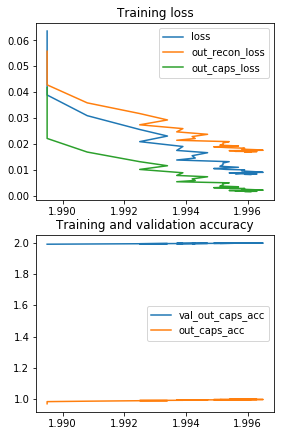

In [11]:
# train or test
if weights is not None:  # init the model weights with provided one
    model.load_weights(args.weights)
if is_training:
    history = train(model=model, data=((x_train, y_train), (x_test, y_test)))
else:  # as long as weights are given, will run testing
    if args.weights is None:
        print('No weights are provided. Will test using random initialized weights.')
    test(model=model, data=(x_test, y_test))